In [1]:
import pandas as pd
from src import data

In [2]:
data_directory = '../../../data/06_preprocessed'

datasets = data.dict_from_directory(data_directory, type='polars')

In [3]:
datasets.keys()

dict_keys(['adhd', 'animal_depression', 'atypical_antipsychotics', 'calcium_channel_blockers', 'oral_hypoglycemics', 'pancreatic_surgery'])

In [4]:
subject = 'oral_hypoglycemics'

df = datasets[subject]

In [5]:
import polars as pl

combined = df.select(
    pl.concat_str(
        pl.col('title').fill_null(''),
        pl.col('abstract').fill_null(''),
        separator=' ',
    )
)

combined = combined.fill_null('')

X = combined.to_series().to_list()

y = df['include'].to_list()

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

In [7]:
pd.Series(y_test).value_counts()

False    147
True      55
Name: count, dtype: int64

In [33]:
#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, SMOTEN, SMOTENC, KMeansSMOTE

pipe = Pipeline(
    [
        ('smote', SMOTEN(random_state=42)),
        ('tfidf', TfidfVectorizer()),
        ('rf', RandomForestClassifier(
            n_estimators=500,
            class_weight='balanced_subsample',
            n_jobs=-1,
            max_depth=50
        ))
        #('nb', MultinomialNB()),
        # ('lr', LogisticRegression(
        #     penalty='l1',
        #     class_weight='balanced',
        #     solver='liblinear',
        #     max_iter=100,
        #     C=0.5,   
        # ))
    ]
)

In [34]:
# from skopt import BayesSearchCV
# from skopt.space import Real, Categorical, Integer

# opt = BayesSearchCV(
#     pipe,
#     {
#         'tfidf__max_features': Categorical([100, 200]),
#         'lr__solver': Categorical(['liblinear', 'saga']),
#     },
#     n_iter=2,
#     random_state=42
# )

In [35]:
# _ = opt.fit(X_train, y_train)

In [36]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import recall_score

# param_grid = {
#     #'lr__solver': ['liblinear', 'lbfgs'],
#     #'lr__penalty': ['l1', 'l2'],
#     }

# grid_search = GridSearchCV(
#     pipe,
#     param_grid,
#     scoring='recall'
# )

# grid_search.fit(X_train, y_train)

In [40]:


pipe.fit(X_train, y_train)

ValueError: Expected 2D array, got 1D array instead:
array=['glucose tolerance mortality include substudy tolbutamide treatment mortality accord glucose tolerance study determine prognosis impaired glucose tolerance among person test community screen programme followed mortality end age sex adjusted mortality rate death per person years se normal glucose tolerance impair glucose tolerance diabetes world health organization criterion baseline age sex adjusted mortality rate due ischaemic heart disease death per person years respectively use criterion predate world health organization men abnormal glucose tolerance enter randomized clinical trial treat tolbutamide approximately year treat low mortality rate cause mortality rate ratio confidence interval ischaemic heart disease mortality rate ratio confidence interval receive tolbutamide thus mortality rate increase person impaired glucose tolerance diabetes small clinical trial suggest tolbutamide may beneficial men abnormal glucose tolerance diabetologia'
 'lispro insulin metformin versus combination diabetes mellitus type management secondary oral antidiabetic drug failure purpose study find difference treatment diabetes type secondary oral antidiabetic drug failure three different method treatment compare lispro insulin combination metformin glimepiride metformin combination two daily dos biphasic insulin together bed time nph insulin study include patient diabetes mellitus type randomly distribute different treatment group fasting postprandial glucose analyze enzymatic colorimetric method hba c measure ion exchange chromatography hba c significantly decrease three study group decrease mostly express among patient treat lispro metformin focus postprandial glucose control antihyperglycemic metformin insulin lispro therapy great impact overall metabolic control decrease level hba c comparison mention traditional approach'
 'factor associate switch oral hypoglycaemic agent insulin therapy aim study determine factor associate switch oral hypoglycaemic agent insulin therapy patient type diabetes mellitus general practice longitudinal observational study dutch general healthcare centre pharmacologically treat patient type diabetes mellitus include n comorbidity laboratory result medication use obtain general practitioner files total patient switch oral hypoglycaemic agent insulin therapy significantly young onset diabetes versus year fast blood glucose level hba c value significantly high switch compare patient oral treatment mmol l versus mmol l versus respectively concern comorbidity suffer frequently acute myocardial infarction lipid disorder depression retinopathy atrial fibrillation cardiovascular disease general often present patient switch insulin versus ci patients switch insulin therapy young diagnosis suffer health problem besides diabetes especially cardiovascular disease bad metabolic control compare user oral hypoglycaemic agent'
 'gliclazide improve anti oxidant status nitric oxide mediated vasodilation type diabetes abstract aim evaluate effect gliclazide oxidative status vascular response systemic administration l arginine natural precursor nitric oxide type diabetic patient method thirty type diabetic patient receive glibenclamide n gliclazide n week randomize observer blinded parallel study plasma lipid peroxide total radical trapping anti oxidant parameter trap blood pressure responses intravenous bolus l arginine measure pre post treatment result week gliclazide patient low plasma lipid peroxide mol l vs mol l p high plasma trap mol l vs mol l p glibenclamide patient gliclazide glibenclamide significantly reduce systolic diastolic blood pressure p p respectively two way repeat measure analysis variance response intravenous l arginine conclusion gliclazide reduces oxidative stress type diabetic patient improve plasma anti oxidant status effect associate enhanced mediated vasodilation'
 'circulate catecholamine metabolic effect captopril niddm patient objective evaluate effect captopril circulate catecholamine level niddm patient possible relationship captopril related change circulate catecholamine level insulin sensitivity research design method fourteen nonobese normotensive niddm men age year undergo h euglycemic hyperinsulinemic clamp mu min baseline evaluation insulin sensitivity follow random assignment patient either captopril placebo treatment accord crossover double blind design euglycemic hyperinsulinemic clamp study repeat patient placebo captopril treatment plasma norepinephrine ne epinephrine e level assess clamp result result data show plasma catecholamine level increase baseline euglycemic hyperinsulinemic clamp ne time vs time min p lt e time vs time min p lt captopril treatment significantly increase total glucose uptake mmol kg min p lt reduced baseline plasma ne p lt e p lt level however magnitude ne time vs time min p lt e time vs time min p lt increment euglycemic hyperinsulinemia affect drug percentage change ratio total body glucose uptake circulate insulin level correspond decrement baseline plasma e level captopril therapy negatively correlate r p lt conclusion reduction circulate catecholamine could contribute least part captopril related amelioration insulin sensitivity'
 'addition low dose rosiglitazone sulphonylurea therapy improve glycaemic control type diabetic patient study design test efficacy safety low dose rosiglitazone potent insulin sensitizing thiazolidinedione combination sulphonylurea type diabetic patients intention treat analysis patient male mean age year available randomize receive week twice daily placebo n rosiglitazone mg n rosiglitazone mg n addition exist sulphonylurea treatment gliclazide patient glibenclamide glipizide two patient take carbutamide glimepiride change haemoglobin c hba c fast plasma glucose fpg fructosamine insulin c peptide albumin lipid measure safety evaluated mean baseline hba c fpg mmol l rosiglitazone dos mg b plus sulphonylurea produce significant decrease compare sulphonylurea plus placebo hba c respectively p fpg mmol l mmol l respectively p hdl cholesterol ldl cholesterol increase potentially beneficial decrease non esterified fatty acid gamma glutamyl transpeptidase level see rosiglitazone group overall incidence adverse experience similar three treatment group significant cardiac event hypoglycaemia hepatotoxicity overall combination rosiglitazone sulphonylurea safe well tolerate effective patient type diabetes'
 'effect food oral bioavailability pharmacodynamic action insulinotropic agent nateglinide healthy subject nateglinide starlix sdz djn new insulinotropic agent intend administer prior meal order improve early insulin release non insulin dependent diabetes mellitus patient effect meal oral bioavailability pharmacodynamic action nateglinide investigate twelve healthy male subject complete randomize single dose four way crossover study subject receive mg dose nateglinide minute start immediately high fat breakfast meal addition subject receive single mg dose nateglinide underfasting condition plasma urine concentration nateglinide determine hplc method plasma glucose insulin concentration measure standard immunoassay method compare fasted state administration nateglinide minute meal associate increase rate absorption increase cmax decrease tmax significant effect extent absorption auc alternatively nateglinide give meal food effect observe characterize decrease rate absorption decrease cmax increase tmax significant effect auc nateglinide rapidly eliminate plasma hour plasma renal clearance ml min appear due mostly active tubular secretion however dose recover nateglinide urine mg tablet dose proportional term auc cmax tmax dose independent regardless timing combination meal nateglinide produce large increase insulin level nateglinide alone meal related glucose excursion eliminate nateglinide take prior meal thus rapid onset short duration stimulation insulin release nateglinide allow good control prandial hyperglycemia limit exposure hyperinsulinemia'
 'effect obesity pharmacokinetics pharmacodynamics glipizide patient non insulin dependent diabetes mellitus summary pharmacokinetics pharmacodynamics glipizide evaluate patient non insulin dependent diabetes mellitus niddm group consist obese subject seven woman five men mean sd age year total body weight tbw kg percentage ibw ideal body weight eight nonobese subject two woman six men age year tbw kg percentage ibw week antidiabetic drug free period patient start glipizide therapy week glipizide dosage titrate achieve specify therapeutic goal maximum daily dose mg glipizide pharmacokinetics assess serum concentration obtain h pharmacokinetic evaluation perform first mg dose sd week chronic therapy cd glipizide pharmacodynamics evaluate serum glucose insulin c peptide response sustacal tolerance test baseline sd cd statistically significant difference sd pharmacokinetic parameter tmax vs h cmax vs g l area curve extrapolate infinity auci vs g h l oral clearance bioavailability cl f vs l h volume distribution bioavailability v f vs l vs h observe obese nonobese group respectively pharmacokinetic parameter assess cd condition also closely match two group difference glucose response sustacal challenge baseline sd cd auco glucose baseline vs sd vs cd vs mm h note obese nonobese group respectively however glucose concentration increase decrease small extent sd obese compare nonobese subject mean fast serum insulin c peptide concentration statistically different two group however obese subject exhibit high fasting insulin vs pm week evaluation c peptide concentration vs nm sd compare nonobese group small percentage increase c peptide response sustacal challenge observe obese compare nonobese subject baseline vs sd vs cd vs summary influence obesity glipizide pharmacokinetics appear little clinical significance observed difference pharmacodynamics require evaluation'
 'morning blood glucose determination monitoring metabolic control type elderly diabetic case treat oral hypoglycemic agent daily blood glucose profile measure type elderly diabetic case evaluate whether fasting breakfast post prandial breakfast blood glucose concentration able predict blood glucose value throughout day diet treated alone group n percentage daily blood glucose profile plasma glucose value less hour breakfast value follow supper hour respectively group treat oral hypoglycemic agent oha n follow respectively oha group mean plasma glucose value hour significantly high patient low plasma glucose level mg dl patient level mg dl vs mg dl p hour similar two group vs mg dl patient low plasma glucose level mg dl hour value correlate positively r r hour value r correlation observe hour value hand hour value associate time points value result reveal breakfast plasma glucose value predictive low blood glucose value night sleep breakfast blood glucose value predict low blood glucose value supper patient oha'
 'comparative tolerability profile oral antidiabetic agent sulphonylureas biguanides widely use adjunct dietary measure treatment non insulin dependent type diabetes mellitus niddm adverse effect profile differ markedly sulphonylureas biguanides reflect difference chemical structure mode action sulphonylureas generally well tolerate although pharmacokinetic difference agent important clinical implication main adverse effect associate sulphonylureas hypoglycaemia effect predictable consequence principal pharmacological effect drug e sensitisation islet beta cell glucose result enhance endogenous insulin secretion sulphonylurea induced suppression hepatic glucose production may cause profound protracted hypoglycaemia especially elderly patient individual intercurrent illness reduced caloric intake take combination compound hypoglycaemic potential e g alcohol ethanol sulphonylureas long duration action notably chlorpropamide glibenclamide glyburide liable induce serious hypoglycaemia particularly drug elimination reduce renal impairment drug salicylate may potentiate action sulphonylureas thereby increase risk hypoglycaemia biguanide therapy associate alteration lactate homeostasis certain clinical circumstance may result fatal lactic acidosis phenformin associate markedly great risk lactic acidosis metformin phenformin withdraw many country reason biguanides must avoid patient renal impairment hepatic dysfunction cardiac failure condition drug accumulation disorder lactate metabolism may predispose lactic acidosis phenformin give individual exhibit severe genetically confer hepatic defect hydroxylation impede metabolism drug less seriously biguanides associate relatively high incidence gastrointestinal adverse effect limit compliance acarbose competitive inhibitor intestinal alpha glucosidases recently introduce contrast sulphonylureas biguanides acarbose associate life threatening adverse effect reflect low systemic absorption drug predictably principal unwanted effect gastrointestinal disturbance result iatrogenic carbohydrate malabsorption'
 'new trend development oral antidiabetic drug large number oral antidiabetic agent available today article provide short review pharmacology clinical aspect various oral antidiabetic drug focus mainly new developing drug therapy near future commonly use old group common approach every day practice sulphonylureas primary goal review compare electrophysiological effect glibenclamide isolated normal streptozotocin induce diabetic rat alloxan induce rabbit ventricular preparation hand differentiate hypoglycaemic sulphonylureas mmol kg accord cardiovascular activity healthy diabetic animal vitro micromol l well chronically treat mg kg week glibenclamide prolong action potential duration normal fail affect diabetic ventricular preparation result suggest sensitivity glibenclamide k atp channel diabetic ventricular fiber drastically decrease effect different sulphonylureas tolbutamide glibenclamide gliclazide glimepiride ventricular ectopic beat well duration ventricular fibrillation induce min ischemia min reperfusion healthy diabetic rat compare tolbutamide gliclazide dose dependently enhanced parameter healthy diabetic group glibenclamide healthy rat increase diabetic rat decrease arrhythmogenicity glimepiride depress arrhythmogenicity healthy diabetic animal glimepiride prove dose dependently enhance myocardial tissue flow dog contrast glibenclamide result confirm glimepiride less cardiovascular action sulphonylureas new oral antidiabetic review try emphasize important basic pharmacological property mechanism action therapeutic use'
 'molecular basis kir channel inhibition adenine nucleotide k atp channel comprise pore forming protein kir x sulfonylurea receptor surx interaction adenine nucleotide kir positively charge amino acid k r c terminus cause channel closure substitution amino acid positively charge residue small effect inhibition adenine nucleotide substitution neutral negative residue major effect suggest electrostatic interaction kir positive charge adenine nucleotide negative phosphate group furthermore r mutation decrease channel sensitivity atp adp amp similar extent k mutation decrease primarily atp adp sensitivity leave amp sensitivity relatively unaffected thus channel inhibition atp may involve interaction alpha phosphate r interaction beta phosphate k addition decrease open probability due rundown sulfonylureas cause increase atp sensitivity k mutant r mutant thus beta phosphate may bind state independent fashion k destabilize channel opening r interacts alpha phosphate stabilize channel close configuration substitution r c terminus r n terminus different charge residue also affect atp sensitivity base result structural scheme propose include feature recently publish model'
 'effect pharmacokinetics oral glibenclamide glipizide caucasian chinese patient type diabetes effect kinetics oral glibenclamide gb glipizide gz study caucasian chinese patient ten group type diabetes randomised order mg gb mg gz placebo give orally administration g oral glucose concentration insulin proinsulin determine use radioimmunoassay ria without cross reactivities sulphonylurea concentration determine use high performance liquid chromatography hplc significant interethnic difference gb gz effect whether glucose insulin proinsulin insulin ratio time point follow gz however chinese patient great increment serum proinsulin min compare caucasian apart maximum plasma concentration cmax area plasma concentration time curve auc gz high among chinese significant interethnic difference pharmacokinetics find appear dosage principle could use caucasian chinese patient type diabetes gb gz prescribe'
 'treatment hypercholesterolemia niddm policosanol objective determine whether elevated level cholesterol low density lipoprotein ldl cholesterol non insulin dependent diabetes mellitus niddm patient could decrease policosanol new cholesterol lowering drug niddm predispose patient coronary artery disease cad direct action hyperglycemia artery well dyslipidemia induce niddm research design method double blind placebo controlled trial perform patient niddm hypercholesterolemia stable glycemie control achieve diet oral hypoglycemic drug patient instruct follow cholesterol lowering diet week patient meet entry criterion receive double blind condition policosanol mg placebo tablet twice day week result policosanol mg day significantly reduce total cholesterol ldl cholesterol compare baseline placebo furthermore high density lipoprotein hdl cholesterol raise significant triglyceride show statistically nonsignificant decrease change lipid profile similar induce policosanol nondiabetic patient type ii hyperlipoproteinemia conclusion glycemie control unaffected treatment clinically biochemically adverse effect attributable treatment observe one patient placebo withdrew trial adverse experience erythema conclude policosanol effective safe patient niddm hypercholesterolemia'
 'short term effect continuous subcutaneous insulin infusion treatment insulin secretion non insulin dependent overweight patient poor glycaemic control despite maximal oral anti diabetic treatment difficult treat obese non insulin dependent diabetic patient nidds whose glycaemic control remain poor despite maximal oral antidiabetic therapy study effect continuous subcutaneous insulin infusion csii associate low calorie diet metformin mg day glycaemic control basal stimulate insulin secretion series overweight nidd csii csii withdrawal patient treat day mean amount iu kg day glycaemic control good day csii remain good fast postprandial plasma c peptide level decrease significantly fast c peptide similar postprandial c peptide significantly high molar fasting postprandial plasma c peptide glycaemia ratio increase significantly glucagon injection molar delta c peptide glycaemia ratio significantly increase even high significant correlation fast postprandial c peptide level glucagon induced c peptide peak fasting postprandial c peptide level weight change correlate significantly molar fasting c peptide glycaemia ratio twenty nine patient ratio x lose weight length csii treatment correlate weight change biological parameter study show csii moderate amount insulin associate low calorie diet metformin provide rapid glycaemic control lead weight loss maintain regulation insulin secretion seem improve insulin secretion sensitivity result obtain day'
 'united kingdom prospective diabetes study ukpds relative efficacy randomly allocate diet sulphonylurea insulin metformin patient newly diagnose non insulin dependent diabetes follow three year assess relative efficacy treatment non insulin dependent diabetes three year diagnosis multicentre randomise control trial allocate patient treatment diet alone additional chlorpropamide glibenclamide insulin metformin obese achieve fast plasma glucose concentration mmol l outpatient diabetic clinic british hospitals subject three month dietary run period fast plasma glucose concentration mmol l hyperglycaemic symptoms fasting plasma glucose glycated haemoglobin fast plasma insulin concentration body weight compliance hypoglycaemia median fasting plasma glucose concentration significantly low three year patient allocate chlorpropamide glibenclamide insulin rather diet alone mmol l respectively p low mean glycated haemoglobin value respectively p mean body weight increase significantly chlorpropamide glibenclamide insulin diet kg p similar pattern see mean fasting plasma insulin concentration mu l p obese subject metformin effective drug change mean body weight significant reduction mean fasting plasma insulin concentration mu l p hypoglycaemic episode occur sulphonylurea insulin diet metformin drug similar glucose lowering efficacy although patient remain hyperglycaemic long term follow require determine risk benefit ratio glycaemic improvement side effect change body weight plasma insulin concentration'
 'gliclazide modify release gliclazide modify release mr new formulation drug gliclazide give daily hydrophilic matrix hypromellose based polymer new formulation effect progressive release drug parallel hour glycaemic profile untreated patient type diabetes mellitus formulation show high bioavailability absorption profile unaffected coadministration food mean plasma glucose level significantly reduce hour period patient type diabetes mellitus treat gliclazide mr daily fasting postprandial state cardiovascular atp sensitive potassium channel interaction observe therapeutic concentration gliclazide mr gliclazide mr also demonstrate antioxidant property independent glycaemic control randomised double blind multicentre study gliclazide mr mg daily show similar efficacy gliclazide immediate release ir mg day divide dos dos mg patient type diabetes mellitus month period reduce glycosylated haemoglobin hba c fast plasma glucose fpg similar extent drug appear efficacious patient previously treat diet alone significant reduction hba c baseline see month similarly sustained effect gliclazide mr observe subgroup elderly patient define priori hba c decrease similar degree observe general study population gliclazide mr show similar tolerability gliclazide ir month treatment randomised trial commonly observed adverse event arthralgia arthritis back pain bronchitis bodyweight remain stable study episode nocturnal hypoglycaemia hypoglycaemia require third party assistance observe treatment gliclazide mr episode symptomatic hypoglycaemia infrequent occur approximately patient'
 'high carbohydrate diet different effect niddm patient treat diet alone hypoglycemic drug compare effect nigh carbohydrate diet blood glucose plasma lipid niddm patient either mild severe glucose intolerance crossover design day intervention diet use eighteen patient separate two group basis hypoglycemic treatment diet n diet plus glibenclamide n assign day treatment high carbohydrate low fiber diet contain energy carbohydrate fat low carbohydrate low fiber diet energy carbohydrate fat cross diet days high carbohydrate diet produce significant increase postprandial blood glucose patient glibenclamide vs mmol l p difference record group diet alone vs mmol l postprandial insulin level significantly high high carbohydrate diet group diet along vs pmol l p significant difference observe group vs pmol l high carbohydrate diet also induce significant increase fast plasma triglyceride concentration group vs mmol l p vs mmol l p difference observe fast plasma cholesterol hdl effect high carbohydrate diet blood glucose control niddm patient differ accord severity glucose intolerance'
 'model cause mortality projection impact smoke cessation base nhefs nhanes epidemiologic follow study model relate clinical risk factor subsequent mortality use simulate impact smoke cessation survivor function derive multivariate hazard regression fit data first national health nutrition examination survey nhanes epidemiologic followup study longitudinal survey representative sample u adult use project death causes validation test show hazard regression agree risk relationship report others project death baseline risk factor closely match observed mortality projection attribute death appropriate level important risk factor projection impact smoke cessation show number cumulative death would low year low years model produce realistic projection effect risk factor modification subsequent mortality adult comparison projection smoke cessation estimate risk attributable smoke publish center disease control prevention suggest cessation could capture benefit possible eliminate smoking'
 'troglitazone discovery development novel therapy treatment type diabetes mellitus prior introduction troglitazone year since last significant improvement antidiabetic therapy view press need effective oral agent treatment type diabetes mellitus troglitazone grant priority review fda launch usa first thiazolidinedione insulin sensitize agent troglitazone quickly follow rosiglitazone pioglitazone glitazones prove effective lower blood glucose also beneficial effect cardiovascular risk troglitazone subsequently withdraw concern hepatotoxicity appear less problem rosiglitazone pioglitazone recent insight molecular mechanism action glitazones ligands peroxisome proliferator activated receptor open prospect design effective selective safer antidiabetic agent document review history troglitazone discovery clinical development'
 'effect carbohydrase inhibitor miglitol sulfonylurea treated niddm patient objective examine effect carbohydrase inhibitor miglitol bay metabolic profile non insulin dependent diabetes mellitus niddm patient suboptimally control maximal daily dos sulfonylurea sfu agent research design method multicenter double blind randomize placebo controlled week clinical trial six week single blind placebo lead run period niddm volunteer fast plasma glucose fpg mg dl hemoglobin c hba c least week treatment sfu maximal dose stratify baseline hba c randomly assign within stratum placebo n mg miglitol time day n mg miglitol time day n efficacy assess hba c fpg insulin lipid concentration plasma glucose serum insulin response standard meal result mg miglitol treatment group mean change baseline hba c placebo value subtract respectively highly significant p case mean peak plasma glucose level standard test meal comparably lower mg dl mg miglitol dose mg dl mg miglitol dose compare placebo p associated reduction integrated serum insulin response p lt significant drug associated change fpg insulin cholesterol level note fast triglyceride level lower significantly mg miglitol dose miglitol side effect limit flatulence loose stool abdominal discomfort dose related rapidly resolve drug discontinuation lead withdrawal study patient take mg miglitol respectively conclusion miglitol may indicate effective adjuvant therapy niddm patient suboptimal metabolic control despite conventional treatment diet maximal daily dos sfu dose mg miglitol time day may preferable mg miglitol time day comparable efficacy substantially reduce side effect'
 'tablet breaking ability old person type diabetes mellitus purpose study assess ability old person type diabetes accurately break half different formulation micronized glyburide tablets thirty person type diabetes age recruit st louis university geriatric clinic participant randomly assign group group break glynase prestabs generic tablet use different manual tablet breaking method group b break glynase prestabs generic tablet without instruction visual analog scale use assess pain difficulty tablet breaking high percentage successful tablet breaking report glynase prestabs compare generic tablet mean pain score break glynase prestabs group group b high pain score obtain generic tablet group group b glynase prestabs easy break group resultant half tablet show less variance expected theoretical weight whole parent tablet weight older adult break glynase prestabs accurately less difficulty generic micronized glyburide tablet variation ease tablet breaking accuracy different tablet formulation affect bioavailability patient compliance'
 'controversial aspect regard metformin type diabetic patient reduction late complication early single drug administration increase risk death late administration combination sulfonylurea compound '
 'endothelial dysfunction type diabetes part alter endothelial function effect treatment type diabetes mellitus coronary artery cerebrovascular peripheral vascular disease principal cause morbidity mortality type diabetes mellitus accelerated macrovascular disease type diabetes mellitus due partly increase incidence cardiovascular risk factor hypertension obesity dyslipidemia advanced glycation end product glycoxidised oxidize low density lipoprotein reactive oxygen specie link hyperglycemia identify type diabetes mellitus could accelerate macroangiopathy hence resistance insulin additional independent risk factor association oxidant stress dyslipidemias prothrombic hypofibrinolytic state endothelium major organ involve cardiovascular risk factor hypercholesterolemia hypertension inflammation age postmenopausal status smoking change endothelium function may lead coronary artery circulation unable cope increased metabolism myocardial muscle independently reduced coronary artery diameter way endothelial function alter diabetic patient yet fully understood loss normal endothelial function could involve pathogenesis diabetic angiopathy endothelial dysfunction associate diabetic microangiopathy macroangiopathy finally recent report indicate improved metabolic control diabetic patient whatever treatment use associate near normalization restoration normal endothelial function'
 'repaglinide type diabetes week fixed dose efficacy safety study week multicenter double blind randomize fixed dose trial patient type diabetes receive daily preprandial treatment placebo n repaglinide mg n repaglinide mg n last observation carried forward calculation repaglinide mg mg treatment decrease mean fasting plasma glucose fpg value mg dl mg dl placebo group increase fpg value mg dl repaglinide treatment group end study change hba c baseline value range percentage point low placebo group event severe hypoglycemia nearly hypoglycemic symptom episode blood glucose level mg dl repaglinide well tolerate preprandial fixed dose regimen mg mg assign without adjustment clinical parameter'
 'natural history insulin secretory dysfunction insulin resistance pathogenesis type diabetes mellitus pathogenesis type diabetes involves abnormality insulin action insulin secretion endogenous glucose output ego however sequence abnormality develop relative contribution deterioration glucose tolerance remain unclear absence detailed longitudinal study measure insulin action insulin secretion ego longitudinally pima indian glucose tolerance deteriorate normal ngt impair igt diabetic year transition ngt igt associate increase body weight decline insulin stimulated glucose disposal decline acute insulin secretory response air intravenous glucose change ego progression igt diabetes accompany increase body weight decrease insulin stimulated glucose disposal air increase basal ego thirty one subject retain ngt similar period also gain weight air increase decrease insulin stimulated glucose disposal thus defect insulin secretion insulin action occur early pathogenesis diabetes intervention prevent diabetes target abnormality'
 'efficacy safety profile glimepiride mexican american patient type diabetes mellitus randomized placebo controlled study background mexican american fast grow ethnic group united state fold high prevalence type diabetes mellitus relative non hispanic white population estimate mexican american year age diabetes objective goal study evaluate efficacy safety glimepiride long acting sulfonylurea adjunct diet exercise mexican american type diabetes mellitus method multicenter randomize double blind placebo controlled study mexican american uncontrolled type diabetes define fasting plasma glucose fpg level mg dl mg dl glycated hemoglobin hba c value month diet exercise enrol patient randomize ratio use low available treatment assignment number eligibility establish receive week glimepiride match placebo daily continued diet exercise start glimepiride dose mg titration mg mg fpg level mg dl primary efficacy variable change hba c baseline study end point secondary efficacy variable hba c response rat excellent good marginal change fpg fast insulin fibrinogen plasminogen activator inhibitor pai level baseline study end point tolerability glimepiride study population determine evaluate adverse event hypoglycemic episode physical examination well laboratory finding analysis perform intent treat basis per protocol analysis also conduct support primary efficacy analysis result seventy patient randomize treatment glimepiride n placebo n glimepiride placebo group similar respect mean se age year respectively sex male respectively however glimepiride group high mean body weight v kg significantly high mean fast insulin level v u ml p mean se hba c value study end point patient receive glimepiride placebo respectively adjusted mean difference hba c reduction baseline end point statistically significant favor glimepiride p pronounced hba c impairment baseline associate great glimepiride placebo difference hba c reduction glimepiride treated patient also achieve significantly great improvement fpg adjust mean se treatment difference mg dl p glimepiride appear affect fibrinogen pai level associate significantly great mean increase fast insulin v u ml p body weight vs kg p compare placebo glimepiride well tolerate adverse event profile similar placebo conclusion result indicate daily glimepiride plus diet exercise effective mexican american type diabetes whose disease inadequately control diet exercise alone appear well tolerate population study weight gain see glimepiride compare placebo give high prevalence type diabetes among mexican american far clinical study glimepiride glucose lowering therapy need ethnic subset'
 'pharmacokinetics pharmacodynamics extended release glipizide git compare immediate release glipizide patient type ii diabetes mellitus study design compare pharmacokinetic short term pharmacodynamic profile extended release glipizide git glucotrol xl give dosage mg daily immediate release glipizide glucotrol mg twice daily patient type ii diabetes mellitus open label randomize two way crossover study glipizide formulation administer day serial blood sample draw baseline th day treatment phase measurement glipizide glucose insulin c peptide concentration steady state mean cmax immediate release glipizide significantly great glipizide git tmax considerably short although mean cmin glipizide git high immediate release glipizide mean auc significantly low despite low plasma concentration glipizide git short term study two formulation similar effect serum concentration glucose insulin c peptide absence pronounced peak plasma concentration git formulation might confer advantage term maintain clinical effectiveness reduce potential cause adverse effect'
 'medical care childhood adulthood type type diabetes diabetes mellitus comprise heterogeneous group disease common development macro microvascular complication possible identify subject high risk type type diabetes especially patient family member preventive intervention quickly become available help delay onset disease thereby reduce complication subject furthermore correct etiological diagnosis diabetes fundamental provide best treatment patient maturity onset diabetes young mody syndrome suspect case subtle onset diabetes autosomal dominant inheritance mitochondrial dna mutation consider diabetic patient also suffer deafness family history combination mother side family atypical diabetes identify physician avoid mistake patient enter non insulin dependent phase case wolfram syndrome gene analysis family member perform identify heterozygote subject recently many discovery genetics help u good understand pathogenesis disease diagnose monogenic form diabetes easily family member follow center clue family history readily available differential diagnosis preventive intervention establish effectively'
 'hemodynamic metabolic hormonal response oral glibenclamide patient cirrhosis receive glucose patient cirrhosis glucose may induce splanchnic renal vasodilation since antidiabetic sulfonylurea glibenclamide know induce splanchnic renal vasoconstriction portal hypertensive animal drug may inhibit glucose induced hemodynamic response patient cirrhosis aim present study investigate patient cirrhosis short term effect glibenclamide hemodynamic humoral response glucose patients randomly assign receive either glibenclamide mg tablet placebo patient receive infusion glucose ml h h start time glibenclamide placebo administration study perform prior min glibenclamide placebo glibenclamide e glibenclamide plus glucose significantly increase plasma insulin concentration glycemia placebo e glucose alone significantly increase glycemia change plasma insulin level glibenclamide significantly change hepatic venous pressure gradient value significantly increase follow glucose alone glibenclamide significantly change renal blood flow glomerular filtration rate glucose alone significantly increase renal blood flow without affect glomerular filtration rate glibenclamide significantly decrease cardiac index glucose alone change value patient cirrhosis receive glucose glibenclamide blunt glucose induced splanchnic renal vasodilation addition glibenclamide per se induce decrease cardiac index finding take account glibenclamide administer patient cirrhosis type diabetes'
 'effect combination therapy troglitazone sulphonylureas patient type diabetes poorly control sulphonylurea therapy alone clinical efficacy troglitazone new oral hypoglycaemic agent investigate type diabetes combination sulphonylureas two hundred ninety one patient type diabetes age year whose previous glycaemic control sulphonylureas judge stable unsatisfactory fast plasma glucose fpg mmol l randomly allocate troglitazone treatment group troglitazone group n placebo treatment group placebo group n treat test drug week combination dose sulphonylureas trial one hundred twenty two patient receive troglitazone patient receive placebo evaluate efficacy baseline characteristic differ significantly two group troglitazone group fpg hba c decrease significantly treatment v fpg mmol l v mmol l p hba c v p fpg hba c change treatment placebo group v fpg mmol l v mmol l hba c v serum total cholesterol hdl cholesterol change either group however serum triglyceride significantly decrease troglitazone group serious adverse event occur either group conclusion troglitazone mg day significant hypoglycaemic effect combination sulphonylureas without serious adverse event troglitazone develop insulin action enhancer useful hypoglycaemic agent treatment patient type diabetes well control sulphonylureas alone'
 'uniform diurnal blood glucose control reduction daily insulin dosage addition glibenclamide insulin type diabetes mellitus role enhanced insulin sensitivity combination therapy insulin sulphonylurea gain acceptance management subject type non insulin dependent diabetes mellitus however role management type insulin dependent diabetes mellitus remain controversial study effect combination therapy insulin glibenclamide metabolic control daily insulin dosage insulin sensitivity assess subject type diabetes mellitus ten men type diabetes mellitus participate randomized double blind crossover clinical trial three treatment regimen namely insulin alone insulin placebo insulin glibenclamide last month combination therapy induce reduction daily insulin dosage uniform blood glucose control reflect low average h blood glucose level small difference mean preprandial h postprandial blood glucose concentration decrease h urine glucose excretion decline number hypoglycaemic event improve insulin sensitivity express rapid plasma glucose disappearance rate without significant alteration fast plasma glucagon h postprandial serum c peptide level compare treatment either insulin alone insulin placebo therefore apparent addition glibenclamide insulin reduces daily insulin dosage render great uniformity diurnal blood glucose control probably secondary enhancement insulin sensitivity'
 'effect rifampicin pharmacokinetics pharmacodynamics glimepiride study effect rifampicin pharmacokinetics pharmaco dynamics glimepiride new sulphonylurea antidiabetic drug randomise two phase cross study healthy volunteer treat day mg rifampicin placebo daily day single oral dose mg glimepiride administer plasma glimepiride blood glucose concentration measure h rifampicin decrease mean area plasma concentration time curve glimepiride p mean elimination half life p significant difference blood glucose response glimepiride observe placebo rifampicin phase however symptomatic hypoglycaemia occur placebo phase effect rifampicin pharmacokinetics glimepiride suggest rifampicin induce cyp c mediated metabolism glimepiride thereby slightly increase systemic clearance interaction modest significantly alter glucose lowering effect glimepiride healthy volunteer probably limited clinical significance however patient hypoglycaemic effect glimepiride may reduce concomitant treatment rifampicin'
 'glimerpiride type diabetes mellitus review worldwide therapeutic experience sulfonylurea sus use many year first line therapy patient type diabetes mellitus whose blood glucose level effectively control diet exercise alone glimepiride daily su introduce since considerable body evidence amass regard use type diabetes review provide comprehensive summary available data pharmacology pharmacokinetics efficacy safety profile glimepiride treatment type diabetes also examine use glimepiride achieve maintain good glycemic control patient type diabetes current clinical practice relevant article identify search medline english language study publish search term use glimepiride sulfonylureas type diabetes mellitus manufacturer glimepiride provide additional information glimepiride differs sus number respect clinical study glimepiride generally associate low risk hypoglycemia less weight gain sus result study suggest glimepiride use old patient renal compromise evidence glimepiride preserve myocardial preconditioning protective mechanism limit damage event ischemic event glimepiride use combination oral antidiabetic agent insulin optimize glycemic control based evidence date glimepiride effective well tolerated daily antidiabetic drug provide important treatment option management type diabetes'
 'population pharmacokinetics glyburide patient well controlled diabetes study objective investigate glyburide pharmacokinetics patient well controlled noninsulin dependent diabetes mellitus niddm test hypothesis intersubject variability glyburide dose due patient difference drug pharmacokinetics method prospective open label study set university affiliated internal medicine outpatient clinic patient fifty one patient niddm woman men mean age yr receive oral glyburide well controlled glycohemoglobin level intervention fast overnight patient ingest regular morning dose glyburide eat breakfast blood sample draw dose hour hour hour dose measurement main result serum glyburide assay high performance liquid chromatography pharmacokinetics nonmem glyburide clearance proportional weight great old patient yr conclusion variability glyburide dose primarily due intersubject difference drug pharmacokinetics'
 'metabolic clearance rate insulin type diabetic patient treat combined insulin sulfonylurea therapy metabolic clearance rate insulin mcri non obese type diabetic patient treat either insulin alone combine insulin plus sulfonylurea therapy investigate classical hour euglycaemic hyperinsulinaemic glucose clamp use artificial pancreas perform randomized order two week period treatment either subcutaneous injection insulin alone insulin plus oral administration sulfonylurea compound glipizide dose x mg day mcri calculate know constant insulin infusion rate u kg h measure basal steady state plasma free insulin c peptide level test perform end period treatment insulin plus glipizide min ingestion last dose mg glipizide plasma c peptide level significantly increase steady state free insulin level tend slightly high whereas metabolic clearance rate glucose affect mcri significantly reduce glipizide ml kg min p result demonstrate sulfonylurea glipizide decrease mcri effect may play role hypoglycemic action sulfonylurea'
 'low dose oral glyburide reduces fast blood glucose decrease hepatic glucose production healthy volunteer without increase carbohydrate oxidation glyburide effective hypoglycemic agent patient type ii diabetes even loss ability increase insulin secretion exact mechanism unknown attempt describe direct effect glyburide glucose metabolism low dose glyburide micrograms kg body weight give orally healthy volunteer attempt increase blood concentration drug without cause marked increase insulin secretion fast hepatic glucose production hgp carbohydrate oxidation co leucine appearance leucine oxidation fat oxidation determine hour hour change see glyburide treated volunteer compare change see non treated healthy volunteer hour period mean blood glucose decrease great glyburide treated volunteer vs p insulin c peptide concentration glyburide administration hour differ significantly baseline hour value insulin pmol l v pmol l c peptide ng ml v ng ml low dose glyburide result significantly great decrease hgp p see fast alone p abstract truncate word'
 'interaction sulfonylurea exercise glucose homeostasis type diabetic patient determine whether plasma glucose lowering effect sulfonylurea acute submaximal exercise additive accordingly determine whether may increase risk hypoglycemia combine fast patients eight postabsorptive type diabetic patient examine three occasion oral sulfonylurea mg glibenclamide min ergometer cycle exercise vo max exercise glibenclamide heart rate vo lactate response exercise comparable p day without glibenclamide plasma insulin concentration always increase glibenclamide lower identically exercise without glibenclamide however throughout exercise absolute concentration insulin low day without glibenclamide compare day glibenclamide vs pmol l p start exercise glucose concentration similar experiment p rate decrease glucose exercise high p day glibenclamide exercise compare day glibenclamide alone day exercise alone vs mmol l min respectively consequently glucose nadir low day glibenclamide exercise day glibenclamide exercise alone vs mmol l respectively p exercise rate appearance plasma glucose determine h glucose infusion low day glibenclamide day without glibenclamide vs mg min kg p contrast glucose clearance identical p postabsorptive type diabetic patient hypoglycemic action glibenclamide exercise enhance treatment combine interaction reflect increase inhibition glibenclamide enhanced insulin level hepatic glucose production hepatic glucose production accelerate exercise'
 'influence bromfenac pharmacokinetics pharmacodynamic response glyburide diabetic subject study objective assess effect bromfenac sodium nonnarcotic analgesic drug development pharmacokinetics pharmacodynamics glyburide patient type ii diabetes design randomize double blind placebo controlled multiple dose study two period crossover design patient eleven men one woman age yr whose diabetes responsive oral sulfonylurea therapy intervention placebo bromfenac mg give single oral dose times day first day study day patient receive alternative treatment least month study patient take usual single daily dose glyburide mg measurement main result bromfenac concentration measure high performance liquid chromatography ultraviolet detection glyburide concentration measure gas chromatography nitrogen phosphorus detection glycemia measure repeatedly day treatment pharmacokinetic analysis perform noncompartmental technique significant difference pharmacokinetics glyburide pharmacodynamic response serum glucose level observe placebo bromfenac intersubject variability concentration modest glyburide glucose cv less conclusion glyburide level change concomitant administration bromfenac'
 'metformin effect glucose lipid metabolism patient secondary failure sulfonylureas objective compare result obtain metformin versus obtain dna recombinant insulin obese patient niddm suffer secondary failure sulfonylureas research design method conduct open prospective randomize comparative study comprise total patient select place two parallel group previously confirm subject secondary failure high dos sulfonylurea initial metformin dosage single mg tablet dosage increase two three tablet depend patient metabolic change initial dosage dna recombinant insulin u subcutaneously administer divide two portion two thirds around breakfast remain third p dinner dosage adjust base patient clinical metabolic response result initial average glucose value metformin group mg dl decrease end study mg dl insulin group figure go mg dl beginning study mg dl decrease correlate reduction glycosylated hemoglobin first group second well reduction triglyceride value mg dl mg dl respectively bmi blood pressure systolic mmhg diastolic mmhg total cholesterol level mg dl decrease metformin group conclusion metformin effective safe well tolerated treatment improve metabolic control favorably modifies secondary clinical alteration due insulin resistance arterial hypertension overweight hyperlipidemia obese patient niddm suffer secondary failure sulfonylurea'
 'clinical study glibenclamide combination kelening treatment non insulin dependent diabetes mellitus asses efficacy combination therapy glibenclamide kelening treat non insulin dependent diabetes mellitus niddm sixty five patient niddm randomly divide two group one group treat glibenclamide kelening glibenclamide alone treatment week level fast blood glucose fbg postprandial blood glucose pbg hbaic reduce significantly glibenclamide kelening group group degree drop level fbg almost level pbg hbaic glibenclamide kelening group reduce significantly glibenclamide group incidence hyperinsulinemia drop considerably glibenclamide combination kelening treatment niddm effective less toxic combination may reduce dosage glibenclamide niddm'
 'influence orlistat pharmacokinetics pharmacodynamics glyburide healthy volunteer assess influence orlistat pharmacokinetics pharmacodynamics blood glucose lowering effect glyburide open label placebo controlled randomize two way crossover study healthy male volunteer subject receive single mg oral dos glyburide micronase upjohn company kalamazoo mi fifth day treatment placebo treatment mg orlistat treatment b three time day day two treatment separate five day washout period serial blood sample collect appropriate interval glyburide dose determine plasma concentration blood glucose level value c max auc glyburide show equality two treatment analysis variance apparent correlation blood glucose level logarithm plasma glyburide concentration relationship appear alter glyburide administer orlistat conclusion orlistat administer dos mg three time daily significantly alter pharmacokinetics blood glucose lowering effect single mg oral dose glyburide healthy volunteer'
 'patient perception prandial oral therapy type diabetes purpose survey conduct assess patient perception glycemic control convenience flexibility prescribed prandial oral therapy type diabetes mellitus method questionnaire distribute physician yield baseline response patient begin repaglinide treatment data analyze respondent also complete follow questionnaire week treatment result among respondent take repaglinide antidiabetic agent combination therapy take metformin take troglitazone respondent indicate satisfied satisfied repaglinide therapy wish continue use believe treatment improve attitude toward take antidiabetic medication patient perceive fast blood glucose level reduce treatment incidence hyperglycemia correspond change perceived frequency hypoglycemia repaglinide treatment minimal conclusion patient perception prandial oral therapy repaglinide predominantly positive due mostly perception glucose control achieve minimal perception increase hypoglycemic episode'
 'pharmacokinetics pharmacodynamics glyburide metformin tablet glucovance versus equivalent dos glyburide metformin patient type diabetes objective compare effect two different formulation glibenclamide glyburide combine metformin postprandial glucose excursion assess pharmacokinetics formulation combination glibenclamide metformin tablet glucovance controlled particle size glibenclamide metformin versus glibenclamide micronase metformin glucophage coadministered separately design randomised double blind two way crossover study patient type diabetes receive either glibenclamide metformin mg tablet glibenclamide mg metformin mg twice daily day week washout patient cross treatment day patient consume standardised meal day pharmacokinetic pharmacodynamic evaluation perform participant forty patient type diabetes enrol randomise men woman complete study mean age year mean body mass index kg baseline glycated haemoglobin hba c treatment group main outcome measure two hour postprandial glucose excursion ppge use assess postprandial glucose dynamic result treatment glibenclamide metformin result significantly small mean ppge attain treatment glibenclamide plus metformin accord measurement take day afternoon standardise meal vs mg dl p mean glibenclamide peak concentration c max significantly great approximately glibenclamide metformin treatment day glibenclamide metformin treatment associate fold great area concentration time curve hour glibenclamide auc p although auc administration interval equivalent formulation conclusion patient type diabetes glibenclamide metformin result low ppge suggest high glibenclamide auc observe formulation may contribute good postprandial glycaemic control attain glibenclamide plus metformin separately'
 'effect glucosidase inhibitor combine sulphonylurea treatment glucose metabolism patient non insulin dependent diabetes mellitus ten patient non insulin dependent diabetes mellitus treat sulphonylureal compound whose glucose metabolism need improvement give combination usual sulphonylurea treatment alpha glucosidase inhibitor treatment alpha glucosidase inhibitor mg day addition glibenclamide mg day two patient mg day four mg day one tolbutamide mg day three patient week improve hyperglycaemia meal mg dl mg dl reduce glycosylated haemoglobin level without cause hypoglycaemia'
 'glucose intolerance year risk coronary heart disease total mortality honolulu heart program association glucose intolerance measure study entry date year incidence coronary heart disease chd chd mortality total mortality examine honolulu heart program prospective study follow cohort japanese american men year old living island oahu hi baseline glucose measure nonfasting state h g glucose load history use medication diabetes obtain interview cohort divide four category glucose tolerance low normal high normal asymptomatic hyperglycemia know diabetes year follow incident case chd death chd total death occur relative risk rrs obtain use cox proportional hazard model low normal category reference rrs adjust age well age bmi hypertension cholesterol triglyceride smoking alcohol japanese diet index age adjusted risk factor adjusted rrs outcome significant asymptomatic hyperglycemic know diabetes group p age adjusted rrs chd incidence total mortality marginally significant high normal group rrs significant adjust risk factors result suggest dose response relation glucose intolerance baseline chd incidence chd mortality total mortality independent risk factor cohort middle aged old japanese american men'
 'effect magnesium supplementation increase dos control type diabetes hypomagnesemia occur patient type diabetes several study suggest association magnesium mg depletion insulin resistance reduction insulin secretion case purpose evaluate mg supplementation magnesium oxide mgo would improve metabolic control patient type diabetes study patient type diabetes men woman age year treat diet diet plus oral antidiabetic drug bahia federal university hospital brazil patient risk hypomagnesemia reduced renal function exclude study clinical randomized double blind placebo controlled trial patient receive either placebo mmol mgo mmol mgo daily elementary mg day mg concentration measure plasma mononuclear cell h urine sample fast blood glucose hba fructosamine use parameter metabolic control patient low plasma mg low intramononuclear mg level intracellular mg patient diabetes significantly low normal population blood donor vs micrograms mg total protein correlation find plasma intracellular mg concentration r p mg concentration glycemic control r p intracellular mg level low patient peripheral neuropathy without vs micrograms mg similar finding observe patient coronary disease vs micrograms mg placebo mmol mg group neither change plasma intracellular level improvement glycemic control observe replacement mmol mg tend increase plasma cellular urine mg cause significant fall mmol l fructosamine normal mmol l mg depletion common poorly control patient type diabetes especially neuropathy coronary disease prolonged use mg dos high usual need establish routine selective administration patient type diabetes improve control prevent chronic complication'
 'sulfonylurea treatment type diabetic patient reduce vasodilator response ischemia sulfonylurea block activation vascular potassium dependent atp channel impair vasodilating response ischcmia nondiabetic individual know whether occur type diabetic patient chronic treatment drug glimepiride new sulfonylurea apparently cardiovascular interaction aim study compare effect widely use compound glibenclamide pancreas specific glimepiride diet treatment alone brachial artery response acute forearm ischemia brachial artery examination perform high resolution ultrasound technique type diabetic patient age mean sd year nondiabetic patient match age hypertension dislipidemia diabetic subject underwent three separate evaluation end week treatment period receive glibenclamide glimepiride diet alone accord crossover design scan obtain min forearm ischemia postischemic vasodilation hyperemia express percent variation vessel diameter blood flow postischemic vasodilation hyperemia respectively glibenclamide glimepiride diet treatment ns result similar find nondiabetic patient n type diabetic patient vasodilating response forearm ischemia whether patient treat diet treatment alone glibenclamide glimepiride blood glucose lowering equipotent close'
 'role sulphonylurea combination therapy assess trial sulphonylurea withdrawal summary aim evaluate effect add insulin sulphonylurea su effect su withdrawal glycaemic control type diabetic patient fail treatment su alone method one hundred seventy five patient include placebo controlled multicentre study phase month premixed insulin add glibenclamide therapy phase ii month depend response insulin dose fix placebo glibenclamide replace open su therapy insulin sensitivity kitt beta cell function c peptide metabolic control hba c monitor result hba c improve p phase high hba c value p high kitt value p baseline associate beneficial response combination treatment phase ii glycaemic control unchanged control glibenclamide group placebo group su withdrawal fast blood glucose fbg increase within week patient patient fbg increase phase ii define su responder protocol multivariate analysis long duration diabetes associate su response gad antibody positive patient among non responders vs p conclusion poor glycaemic control combination preserved insulin sensitivity lack gad antibody predict beneficial response combination therapy achieve patient su failure'
 'pharmacokinetics safety glimepiride clinically effective dos diabetic patient renal impairment pharmacokinetics efficacy safety glimepiride investigate single multiple dose open study patient non insulin dependent diabetes mellitus renal impairment initial creatinine clearance ml min patient divide three group creatinine clearance ml min ml min ml min fifteen fast patient receive single dose mg glimepiride serial blood urine sample take h pharmacokinetic efficacy analysis patient receive glimepiride month period initial dose mg glimepiride adjust within range mg achieve good glucose control pharmacokinetic evaluation day month mean relative total clearance mean volume distribution single ml min litre respectively creatinine clearance ml min multiple dos glimepiride increase proportion degree renal impairment ml min litre respectively creatinine clearance ml min single dose whereas terminal halflife mean time remain unchanged lower relative total clearance renal clearance glimepiride metabolite correlate significantly low creatinine clearance value patient require mg glimepiride stabilize fasting blood glucose glimepiride well tolerated drug related adverse event conclusion glimepiride safe effective clearly definable pharmacokinetics diabetic patient renal impairment increased plasma elimination glimepiride decrease kidney function explainable basis altered protein bind increase unbound drug'
 'united kingdom prospective diabetes study year randomize control trial compare sulfonylurea insulin metformin therapy patient newly diagnose type diabetes could control diet therapy articles february united kingdom prospective diabetes study year randomize control trial compare sulfonylurea insulin metformin therapy patient newly diagnose type diabetes could control diet therapyauthor article disclosure informationhttps doi org sectionsaboutfull textpdf toolsadd favoritesdownload citationstrack citationspermissions sharefacebooktwitterlinkedinredditemail abstractbackground uncertainty exist suitability oral hypoglycemic drug insulin therapy patient newly diagnose type diabetes objective assess compare response sulfonylurea insulin metformin year patient newly diagnose type diabetes disease could could control diet therapy alone design multicenter randomize control trial setting outpatient diabetes clinic hospital united kingdom intervention sulfonylurea chlorpropamide glyburide insulin metformin patient obese patients patient newly diagnose type diabetes could control diet hyperglycemic symptom fast plasma glucose level great mmol l initial month diet therapy primary diet failure group patient disease control diet therapy fast plasma glucose level mmol l hyperglycemic symptom receive diet therapy alone measurements fast plasma level glucose insulin hemoglobin c concentration body weight therapy required results compare diet controlled group primary diet failure group young less obese retinopathy low fast plasma insulin level reduce cell function year patient allocate insulin low fasting plasma glucose level patient allocate oral agent hemoglobin c concentration similar forty eight percent ci patient primary diet failure group maintain hemoglobin c concentration less year patient ci allocate ultralente insulin require additional short acting insulin patient ci allocate sulfonylurea require additional therapy metformin insulin control symptom maintain fast plasma glucose level less mmol l patient allocate insulin gain weight hypoglycemic attack patient allocate sulfonylurea obese patient allocate metformin gain least weight hypoglycemic attack therapy control achieve year worse primary diet failure group diet controlled group conclusions initial insulin therapy induce hypoglycemic reaction weight gain without necessarily provide well control may reasonable start oral agent change insulin goal glycemic level achieved references guideline good practice diagnosis treatment non insulin dependent diabetes mellitus report joint work party british diabetic association research unit royal college physician royal college general practitioner j r coll physicians lond google scholar consensus statement pharmacological treatment hyperglycemia niddm diabetes care suppl google scholar uk prospective diabetes study ukps viii study design progress performance diabetologia google scholar united kingdom prospective diabetes study ukps relative efficacy randomly allocate diet sulphonylurea insulin metformin patient newly diagnose non insulin dependent diabetes follow three year bmj google scholar phillips simpson rw holman rr turner rc simple rational twice daily insulin regime distinction basal meal insulin requirement q j med google scholar uk prospective diabetes study complication newly diagnose type diabetic patient association different clinical biochemical risk factor diabetes google scholar uk prospective diabetes study ukps xi biochemical risk factor type diabetic patient diagnosis compare age matched normal subject diabet med google scholar rudenski matthew dr levy jc turner rc understanding insulin resistance glucose resistance insulin resistance require model human diabetes metabolism google scholar matthew dr hosker jp rudenski naylor ba treacher df turner rc homeostasis model assessment insulin resistance cell function fast plasma glucose insulin concentration man diabetologia google scholar uk prospective diabetes study v characteristic newly present type diabetic patient estimate insulin sensitivity islet cell function multicentre study diabet med google scholar davis md hubbard ld trautman j klein r conference insulin pump therapy diabetes multicenter study effect microvascular disease study retinopathy methodology assessment classification fundus photograph diabetes suppl google scholar user manual statistical analysis system version cary nc sas institute google scholar harris mi undiagnosed niddm clinical public health issue diabetes care google scholar nabarro jd oral hypoglycaemic agent first thirty year j r coll physicians lond google scholar groop l schalin c franssila kallunki widen e ekstrand eriksson j characteristic non insulin dependent diabetic patient secondary failure oral antidiabetic therapy j med google scholar u k prospective diabetes study overview year therapy type ii diabetes progressive disease u k prospective diabetes study group diabetes google scholar university group diabetes program study effect hypoglycemic agent vascular complication patient adult onset diabetes v evaluation pheniformin therapy diabetes suppl google scholar kilo c miller jp williamson jr achilles heel university group diabetes program jama google scholar effect intensive treatment diabetes development progression long term complication insulin dependent diabetes mellitus diabetes control complication trial research group n engl j med google scholar turner r stratton horton v manley zimmet p mackay ir et al ukps autoantibody islet cell cytoplasm glutamic acid decarboxylase prediction insulin requirement type diabetes uk prospective diabetes study group lancet google scholar author article disclosure informationaffiliations acknowledgment author thank patient national health serviceand non national health service staff center cooperation grant support grant united kingdom medical research council british diabetic association united kingdom department health national eye institute u ey national institute diabetes digestive kidney disease r dk national institute health british heart foundation health promotion research trust clothworkers foundation charles wolfson charitable trust alan babette sainsbury trust oxford university medical research fund committee corresponding author united kingdom prospective diabetes study group diabetes research laboratory radcliffe infirmary woodstock road oxford ox united kingdom current author address drs wright cull holman turner united kingdom prospective diabetes study group diabetes research laboratory radcliffe infirmary woodstock road oxford ox united kingdom nextarticle advertisement figuresreferencesrelateddetails metric cite byreal world efficacy glucagon like peptide glp receptor agonist dulaglutide metabolic parameter japanese patient type diabetes retrospective longitudinal studydietary fiber intake relate skeletal muscle mass body fat mass muscle fat ratio among people type diabetes cross sectional studyk rperliche und psychische folgeerkrankungen bei diabetes mellitusmetformin improves skeletal muscle microvascular insulin resistance metabolic syndromerecommendations practical use metformin central pharmacological therapy type diabeteschoosing medication type diabetes weighting give cardiovascular risk reduction long term outcome add alpha glucosidase inhibitor insulin treated patient type diabetesa review metformin clinical significance side effectsprevalence incidence micro macro vascular complication diabetic population bangladesh retrospective cohort studyramadan fasting diabetes late evidence technological advancement updateramadan fast diabetes late evidence technological advancement updatehypoglycemia induces mitochondrial reactive oxygen specie production increase fatty acid oxidation promote retinal vascular permeability diabetic micethe age vasculature glucose tolerance hypoglycemia role serum response factorbioactive component salvia potential antidiabetic property reviewpersonalized diabetes management patient diabetes mellitus prefer discrete choice experimentthe association metformin treatment outcome type diabetes mellitus patient heart failure preserved ejection fraction retrospective studyimpacts early insulin treatment v glimepiride diabetic patient background metformin therapymetabolic control determinant among hiv infected type diabetes mellitus patient attend tertiary clinic botswanahypoglycaemia management primary care settingjapanese clinical practice guideline diabetes japanese clinical practice guideline diabetes metformin monotherapy adult type diabetes mellitusspotlight experience medicine unavailability access medicine challenge ncds ntds contrasting case insulin praziquantelefficacy safety empagliflozin add insulin japanese patient type diabetes randomized double blind placebo controlled trialpioglitazone exposure reduce risk cause mortality insulin treated patient type diabetes mellitusoral insulin updateeffect diabetes self management education glycemic control latino adult type diabetes systematic review meta analysisthe metformin paradoxtype ii diabetes mellitusdriver versus navigator causation biology case insulin fast glucoseall cause mortality insulin plus dipeptidyl peptidase inhibitor person type diabetesunderstanding glucoregulatory mechanism metformin type diabetes mellitusdiabetes education impact hypoglycemia outcome systematic review evidence gap literatureendocrine pharmacologysystemic effect periodontitis treatment patient type diabetes month single centre investigator masked randomise trialrelationship serum adipsin first phase glucose stimulated insulin secretion individual different glucose tolerancepharmacokinetics metformin patient gastrointestinal intolerancecardiovascular outcome dipeptidyl peptidase inhibitor patient type diabetes insulin therapyjapanese clinical practice guideline diabetes pharmacologic glycemic management type diabetes adultshigh glucose mediated tyrosine nitration pi kinase molecular switch survival apoptosis endothelial cellsjapanese clinical practice guideline diabetes mobile diabetes intervention study patient engagement impact blood glucose mixed method analysiscardiovascular safety non insulin pharmacotherapy type diabetesoral insulin delivery physiologic context reviewestimation insulin secretion glucose uptake tissue liver handling glucose use mathematical model glucose insulin homeostasis lean obese micerelationship hla haplotype bmi change japanese slowly progressive type diabetes patientsweight change initiation oral hypoglycemic monotherapy diabetes predicts year mortality observational studyanti diabetic medication make choice efficacy safety basal supported prandial glp receptor agonist therapyhypoglycemia diabetesefficacy safety insulin type diabetes meta analysis randomise control trialsefficacy safety canagliflozin combination insulin double blind randomize placebo controlled study japanese patient type diabetes mellitusaddition sulphonylurea metformin relevantly change body weight prospective observational cohort study zodiac importance multidisciplinary team management complex obesity patient diabetesdiabetes medication monotherapy metformin based combination therapy type diabetes systematic review meta analysisnisa maruthur md mhs eva tseng md mph susan hutfless phd lisa wilson scm catalina suarez cuervo md zackary berger md phd yue chu msph emmanuel iyoha mbchb mph jodi b segal md mph shari bolen md mphcombination therapy sglt inhibitor incretin based therapy treatment type diabetes mellitus effect mechanism actionefficacy safety sglt inhibitor luseogliflozin japanese patient type diabetes mellitus stratify accord baseline body mass index pool analysis data week phase iii trialss breast cancer focus metformin integrative metformin mimic medicine real natural optionshypoglycemiaantidiabetic property bioactive constituent therapeutic effect scoparia dulcissafety efficacy early clinical experience insulin degludec japanese people diabetes mellitus first year report japanpharmacogenetics individual response treatment hyperglycemia type diabetesevidence based practice guideline treatment diabetes japan cardiovascular risk diabetes mellitus complication disease antihyperglycemic medicationsa randomize controlled trial liraglutide versus insulin detemir plus sitagliptin effective switch intensive insulin therapy daily injection patient well controlled type diabetesdifferential cardiovascular outcome dipeptidyl peptidase inhibitor sulfonylurea pioglitazone therapy combination metformin type diabetes population based cohort studypharmacologic treatment type diabetescontrol cardiovascular risk factor revascularized patient diabetes subanalysis icp bypass studycontrol de factores de riesgo cardiovascular en pacientes diab ticos revascularizados un suban lisis del estudio icp bypassoral antihyperglycemic treatment option type diabetes mellitushypoglycemia carea combine analysis type diabetes genetic risk variant show discriminative value predict time first prescription glucose lowering drug danish patient screen detect type diabetesglucose lowering drug patient chronic kidney disease narrative review pharmacokinetic propertieseconomic impact therapeutic choice case incretinsinsulin glargine add therapy oral hypoglycaemic agent achieve target fast plasma glucose level type diabetes patient indian setupweight gain glucose lowering agentsglucose control non insulin therapiesage specific effectiveness safety newly initiate insulin therapy japanese patient uncontrolled diabetespersonalizing guideline diabetes management twilight dawn expert additive postprandial glucose lowering effect mitiglinide sitagliptin patient type diabetes mellitushypoglycaemia type diabetes elderly peoplecounterregulatory deficiency diabetespharmacoth rapie du diab te de type get people diabetes cyclingsafety efficacy sulfonylurea drug type diabetes mellituspharmacologic management type diabetesnoninsulin glucose lowering agent treatment patient dialysiskomorbidit tenhypoglycemia associated autonomic failure diabetesendocrine pharmacologyclinical application different cross reactivities anti insulin antibody insulin lispro evaluate endogenous insulin secretiondosage antihyperglycemic drug patient renal insufficiencyfuture detection monitoring diabetes may entail analysis cell function volume marker cell loss may assistthe glucose lowering effect pde inhibitor roflumilast roflumilast n oxide db db miceevolution insulin development focus key parametersthe semdsa guideline management type diabetes revise hypoglycaemia diabetesbaseline factor associate glycemic control weight loss exenatide twice daily add optimize insulin glargine patient type diabetesthe semdsa guideline management type diabetesindividuelle therapieziele bei diabetes und extremer adipositaseffective management hypoglycaemia diabetesevaluation perception insulin therapy among chinese patient type diabetes mellitussulfonylureas need introspect safety manage hypoglycaemiamedically minimise impact hypoglycaemia type diabetes reviewinsulin detemir attenuate food intake body weight gain fat mass gain diet induced obese sprague dawley ratsutilities disutilities attribute injectable treatment type diabetesclinical audit hypoglycaemic symptom type diabetic patient singhealth polyclinicscomparative effectiveness safety medication type diabetes update include new drug drug combinationswendy l bennett md mph nisa maruthur md mhs sonal singh md mph jodi b segal md mph lisa wilson scm ranee chatterjee md mph spyridon marinopoulos md mba milo puhan md phd padmini ranasinghe md mph lauren block md wanda k nicholson md mph susan hutfless mph phd eric b bass md mph shari bolen md mphtaking hypoglycaemia seriously diabetes dementia heart diseasehypoglycemiaa comparison intermediate long acting insulin people type diabetes start insulin observational database studyweight management type diabetes mellitushypoglycemia diabetesglycaemic goal patient type diabetes current status challenge recent advancesclinical analysis elderly patient elderly onset type diabetes mellitus china assessment appropriate therapypioglitazone use combination insulin prospective pioglitazone clinical trial macrovascular event study proactive expression characterization momordica chanrantia anti hyperglycaemic peptide escherichia colirisk fatal nonfatal lactic acidosis metformin use type diabetes mellitusepidemiology diabetic retinopathythe continuation oral medication initiation insulin therapy type diabetes review evidencesuccesses challenge insulin therapy type diabetes managed care settinginsulin resistance cell dysfunction conversion type diabetes multiethnic populationsimultaneous pancreas kidney transplantation type diabetesdiabetes medication body weighttransplantation type diabetesmyocardial infarction stroke early year diagnosis type diabetes risk factor relation self monitoring blood glucosepro con early use insulin management type diabetes clinical evaluationorlistat mg improves glycaemic control type diabetic patient without concurrent weight losscontinuous glucose monitoring system free living healthy subject result pilot studyactivation amp activated protein kinase metformin improves leave ventricular function survival heart failuredrug evaluation vildagliptin metformin single tablet combinationinsulin monotherapy versus combination insulin oral hypoglycaemic agent patient type diabetes mellitusdiabetes mellituseffect diabetes medication cardiovascular risk surrogate marker patient type diabeteseffect weight reducing agent glycaemic parameter progression type diabetes reviewsuboptimal glycaemic control primary care need intensification therapy recognise hypoglycemia still limit factor glycemic management diabetesinsulin use weight maintenance well controlled type diabetes prospective cohort studysafety efficacy glargine compare nph insulin treatment type diabetes meta analysis randomize control trialsgps approach insulin prescribe old patient qualitative studyinsulin may role play protect beta cell deterioration diabetes reply del parigi letter primary care physician insulin initiation multiple barrier lack knowledge impact therapeutic advance hypoglycaemia type diabetesbarriers obesity treatmentpharmacogenetics potential role treatment diabetes obesitytailoring diabetes self care intervention use old rural african american womenan audit diabetes management asian patient treat specialist diabcare asia studiestype diabetes mellitus evidence based approach practical managementanalisi di costo efficacia di exenatide versus insulina glargine nel trattamento dei pazienti diabetici di tipo fallimento secondario al doppio ipoglicemizzante oraleriesgo elevado de disfunci n lipoproteica en la diabetes mellitus tipo delayed initiation subcutaneous insulin therapy failure oral glucose lowering agent patient type diabetes population based analysis ukhypoglycemia type diabetesoral hypoglycemic agentssystematic review comparative effectiveness safety oral medication type diabetes mellitusshari bolen md mph leonard feldman md jason vassy md mph lisa wilson b scm hsin chieh yeh phd spyridon marinopoulos md mba crystal wiley md mph elizabeth selvin phd renee wilson eric b bass md mph frederick l brancati md mhskombinierte niere pankreas transplantationcontinuous glucose monitoring patient type diabetes premixed insulin treatment type diabetes analogue human short term economic impact body weight change among patient type diabetes treat antidiabetic agent analysis use claim laboratory medical record dataobesity nutrigenomics metabolic syndrome type diabetesinsulin therapy hypoglycemia type diabetes mellitusafter pregnancy complicate diabetes postpartum care educationa double blind randomize study compare effect continue continue rosiglitazone metformin therapy start insulin therapy people type diabetes lean patient type diabetes characteristic therapy challengethe use basal insulin nph compare pre mixed biphasic insulin patient type diabetes mellitusmetformin associated lactic acidosis burn patientsicherheitsaspekte oraler antidiabetikatype diabetes get good startthe place insulin secretagogues treatment type diabetes twenty first centuryhealthcare professional bias obese know problem weight change follow initiation new anti hyperglycaemic therapiescontemporary analysis secondary failure successful sulfonylurea therapyoptimal glucose control type diabetes mellitus guide family practitionerlong term efficacy metformin therapy nonobese individual type diabetesinsulin aspart reviewaccuracy continuous subcutaneous glucose monitoring glucoday type diabetic patient treat subcutaneous insulin infusion exercise low versus high intensityinsulin sensitivity oral glucose tolerance test relation parameter glucose metabolism endothelial function type diabetic subject metformin thiazolidinedioneefficacy conversion bedtime nph insulin morning insulin glargine type diabetic patient basal prandial insulin therapyinterventions improve diabetes self managementan evaluation well research report facilitate use finding practiceeffect cyp c genetic polymorphism efficacy pharmacokinetics glimepiride subject type diabetesthe place sulfonylurea therapy type diabetes mellituscost hypoglycemia patient type diabetes swedendevelopment validation economic assessment glycemic control long term effect diabetes eagle modelprevalence inadequate glycemic control among patient type diabetes united kingdom general practice research database series retrospective analysis data challenges strategy move patient injectable medicationsrisk fatal nonfatal lactic acidosis metformin use type diabetes mellitusnateglinide glibenclamide examination use respiratory quotient rq hypoglycemia type diabetestype diabetes dyslipidemia vascular risk rationale evidence correct lipid imbalanceeffect increase cost sharing oral hypoglycemic use five managed care organizationsthe economic quality life impact hypoglycemiabasic approach manage hyperglycemia nonendocrinologistblood pressure control risk stroke untreated treated hypertensive patient screen clinical practice result forlife studyislet autoantibody clinically diagnose type diabetes prevalence relationship metabolic control ukpds association middle aged mother father body mass index year old son waist circumference birth weight serum hepatic enzyme levelsevaluation drug therapy risk factor diabetic hypertensive study quality care provide diabetic clinic bahrain exercise metformin hypoglycaemia neglected entityhypoglycemia stable insulin treated veteran type diabeteslower within subject variability fast blood glucose reduced weight gain insulin detemir compare nph insulin patient type diabetesbarriers follow dietary recommendation type diabetesefficacy glimepiride patient poorly control insulin treated type diabetes mellitusinsulin sensitivity oral glucose tolerance test relation parameter glucose metabolism endothelial function type diabetic subject metformin thiazolidinedionepractical consideration guideline dose sulfonylurea monotherapy combination therapythe effect different nutritional feed postprandial glucose response healthy volunteer patient type ii diabetesachieving glycemic control type diabetes practical guide clinician oral hypoglycemicsthe diabetes continuity care scale development initial evaluation questionnaire measure continuity care patient perspective impact insulin glargine clinical humanistic outcome patient uncontrolled insulin oral agent office based naturalistic study systematic approach manage hypertension metabolic syndrome primary caremanagement type diabetes mellitus time paradigm shift effect liraglutide long acting glucagon like peptide derivative glycemic control body composition h energy expenditure patient type diabetesanalisi di costo efficacia della terapia combinata con pioglitazone nel trattamento del diabete mellito di tipo italiahypoglycemia type diabetesdiverse cause hypoglycemia associated autonomic failure diabetesserum adiponectin associate high density lipoprotein cholesterol triglyceride low density lipoprotein particle size young healthy mencombination therapy type diabetesa placebo controlled crossover study compare effect nateglinide glibenclamide postprandial hyperglycaemia hyperinsulinaemia patient type diabetesclinical evaluation continuous minimally invasive glucose flux sensor place ultrasonically permeate skinorlistateffects moderate weight loss orlistat insulin resistance regional adiposity fatty acid type diabetesinappropriate medication elderly patientsaddition biphasic insulin aspart rosiglitazone type diabetes mellitus poorly control glibenclamide monotherapyhypoglycemiaprevention treatment type diabetes mellitus child special emphasis american indian alaska native childrenc reactive protein young apparently healthy men association serum leptin qtc interval high density lipoprotein cholesterolcommon problem outpatient management patient diabetes age insulin analoguesrisk fatal nonfatal lactic acidosis metformin use type diabetes mellitusclinical evaluation obese patientthe management obese diabetic patienthypoglycemia diabetesaddressing dose frequency diabetes simple approach improve adherence therapy clinical outcomesassociation hypoglycemia cardiac ischemiainsulin hypoglycemic agentstherapie de diabetes mellituspharmacotherapy diabetes mellitus implication prevention treatment cardiovascular diseasetroglitazone discovery development novel therapy treatment type diabetes mellitusbiomarkers functional food obesity diabetesthe improve primary care african american diabetes ipcaad projectadherence oral hypoglycaemic agent prior insulin therapy type diabetesorlistat use type diabetesclinical efficacy orlistat therapy overweight obese patient insulin treated type diabetesyoung men high normal blood pressure low serum adiponectin small ldl size high elevated heart rate optimal blood pressurepromoting physical activity people type diabetesorlistat treatment type diabetes mellitusimproved postprandial glycemic control biphasic insulin aspart relative biphasic insulin lispro biphasic human insulin patient type diabeteshypoglycemia associated autonomic failure advanced type diabetescontinuous subcutaneous glucose monitoring diabetic patientstreatment type diabetes mellitus pharmacologic interventionobesity type diabetes mellitus treatment challengenegotiating barrier hypoglycemia diabeteseffect acarbose weight maintenance dietary weight loss obese subject hypoglycemia associated autonomic failure diabetesrevis da hiperglicemia p prandial e hipoglicemia controle diabetes mellitus papel da insulina lispro e suas pr misturas picos e valesmanagement type diabetesthe effect metformin body mass index glucose tolerance obese adolescent fast hyperinsulinemia family history type diabetesbasal insulin therapy type diabetesglucose induced insulin resistance phosphatidylinositol oh kinase akt pkb mediate hexosamine biosynthesis pathwayonce twice daily dosing rosiglitazone improve glycemic control patient type diabetesmonotherapy metformin improve hypoxia type diabetic patient abnormality cell function development progression type diabetesglukosenuevos enfoques terap uticos en la diabetes tipo effect metformin cardiovascular risk factor obese type diabetic patientsnon insulin dependent diabetes mellitus type secondary failure metformin glibenclamide treatmenthormone replacement therapy postmenopausal woman diabetes mellitusafferent signal regulate food intakeenergy metabolism substrate oxidative pattern type diabetic patient treat sulphonylurea alone combination metforminpostpartum care woman diabetesbarriers control blood glucose diabetes mellitusmedical cost manage care patient type diabetes mellituscurrent potential drug treatment obesitypharmacologic therapy type diabetes mellitusralph defronzo mdeffects metformin patient poorly control insulin treated type diabetes mellitus randomized double blind placebo controlled triallarissa avil santa md joyce sinding msn rn philip raskin mddiabetische nephropathieglucose control guideline current conceptseffect high carbohydrate versus high monounsaturatedfatty acid diet metabolic control diabetes hyperglycemic patientstherapie de diabetes mellitushypoglycemia type diabetes february volume issue page keywordsattentionblood plasmadietglucosehemoglobinhyperglycemiahypoglycemicsinsulinoverweighttype diabetes epublished august issue publish february copyright permissionscopyright american college physician right reserved pdf downloadloading'
 'pitfall treatment oral antidiabetic agent treatment type diabetes niddm possess three group oral hypoglycaemic drug sulfonyl urea derivative biguanides metformin alpha glucosidase acarbose inhibitor oral treatment diabetes favourable impact patient metabolic deviation involve also certain danger pitfall side effects oral antidiabetic reduce minimum respect consequentially contraindication administration different preparation knowledge mechanism action individual selection suitable antidiabetic every patient'
 'thiazolidinediones type diabetes new drug old disease medical journal australiavolume issue p new drug old drug thiazolidinediones type diabetes new drug old disease correction article thiazolidinediones type diabetes new drug old disease trisha moore sullivan mb b fracp johannes b prins mb b phd fracp volume issue medical journal australia page first publish online october trisha moore sullivan mb b fracp correspond author trisha moore sullivan mb b fracp visit endocrinologist senior lecturer department medicine university queensland nmhrc postgraduate medical research fellow tomoore medicine pa uq edu au department diabetes endocrinology princess alexandra hospital woolloongabba brisbane qld correspondence tomoore medicine pa uq edu ausearch paper authorjohannes b prins mb b phd fracp johannes b prins mb b phd fracp director associate professor department medicine university queensland wellcome senior research fellow department diabetes endocrinology princess alexandra hospital woolloongabba brisbane qld search paper author trisha moore sullivan mb b fracp correspond author trisha moore sullivan mb b fracp visit endocrinologist senior lecturer department medicine university queensland nmhrc postgraduate medical research fellow tomoore medicine pa uq edu au department diabetes endocrinology princess alexandra hospital woolloongabba brisbane qld correspondence tomoore medicine pa uq edu ausearch paper authorjohannes b prins mb b phd fracp johannes b prins mb b phd fracp director associate professor department medicine university queensland wellcome senior research fellow department diabetes endocrinology princess alexandra hospital woolloongabba brisbane qld search paper author first publish april http doi org j tb xcitations read full textaboutpdf toolsrequest permissionexport citationadd favoritestrack citation shareshare give accessshare full text accessshare full text accessplease review term condition use check box share full text version article read accept wiley online library term condition useshareable linkuse link share full text version article friend colleague learn copy url share linkshare onfacebooktwitterlinkedinredditwechat cite literature volume issue april pages relatedinformation'
 'treatment oral antidiabetic agent troglitazone improve beta cell response glucose subject impaired glucose tolerance impaired glucose tolerance igt associate defect insulin secretion action carry high risk conversion non insulin dependent diabetes mellitus niddm troglitazone insulin sensitize agent reduces glucose concentration subject niddm igt know affect insulin secretion seek determine role beta cell function mediate improve glucose tolerance obese subject igt receive wk either mg daily troglitazone n placebo n randomized double blind design study measure baseline treatment glucose insulin response g oral glucose tolerance test insulin sensitivity index si assess frequently sample intravenous glucose tolerance test insulin secretion rate graded glucose infusion beta cell glucose sensing ability oscillatory glucose infusion troglitazone reduce integrate glucose insulin response oral glucose p p respectively si increase x min pm p average insulin secretion rate adjust si glucose interval mmol liter increase p ability beta cell entrain exogenous oscillatory glucose infusion evaluate analysis spectral power improve p significant change parameter demonstrate placebo group addition increase insulin sensitivity demonstrate troglitazone improve reduced beta cell response glucose characteristic subject igt appear important factor observed improvement glucose tolerance'
 'near normoglycaemic remission african americans type diabetes mellitus associate recovery beta cell function summary aim prospectively determine frequency remission possible mechanism beta cell recovery non whites type diabetes mellitus setting intensive glycaemic regulation use pharmacological agent method twenty six consecutive newly diagnose african american type diabetic patient present primarily severe hyperglycaemia mmol l follow least year initial hospitalization include treatment insulin fluid electrolyte outpatient intensive glycaemic regulation include insulin glibenclamide diabetes education diet alter nutrient content plasma glucose c peptide response oral glucose tolerance test hba c measure day presentation remission define hba c fasting plasma glucose mmol l month discontinue pharmacological agent result eleven patient develop remission mean day pharmacological treatment remain remission follow day one relapse day fifteen patient develop remission follow day require continue pharmacological therapy well controlled mean hba c significant difference age sex plasma glucose presentation initial glycaemic regulation final body mass index magnitude weight change pharmacological agent use treatment two group plasma c peptide response oral glucose initially day suppress subject subsequently increase increase significantly great undergo remission neither significant weight loss severe hypoglycaemia observe either group intensive treatment conclusion forty two per cent newly diagnose unselected african americans type diabetes treat intensively use pharmacological agent education diet developed near normoglycaemic remission remission associate great recovery glucose stimulated insulin secretion suggest therapy direct promote beta cell recovery preservation potentially useful approach treatment type diabetes mellitus'
 'bioequivalence study two brand glipizide tablet open randomize two way crossover bioequivalence study two mg tablet preparation glipizide glipizyd tabl mg tarchomi skie zak ady farmaceutyczne polfa glibenese tabl mg pfizer compare healthy male volunteer pharmacokinetic variable mean maximum plasma concentration mean time reach maximum plasma concentration mean area plasma concentration time curve statistically significantly different two formulation conclude two tablet preparation glipizide likely bioequivalent'
 'fda approves nateglinide treatment type diabetes '
 'dietary advance glycation end product potential role cardiometabolic disease child rise incidence obesity metabolic disease diabetes mellitus cardiovascular disease adolescent young adult grave concern recent study favor role lifestyle factor genetics perpetuation inflammation insulin resistance oxidative stress pathophysiologic process common disease furthermore importance dietary factor addition calorie physical activity process increasingly recognize advanced glycation end product age belong category dietary oxidant implicate pathogenesis inflammation oxidative stress insulin resistance cell failure endothelial dysfunction paper review study age focus role cardiometabolic disease child medline search perform use key word childhood obesity metabolic syndrome advance glycation end product article publish english reference review study perform adult study also demonstrate role age obesity associate cardiometabolic comorbidities young population available evidence suggest involvement age pathogenesis adiposity cell failure child potential area research investigate underlying mechanism propose'
 'comparison micro macro vascular effect glimepiride gliclazide metformin treated patient type diabetes double blind crossover study compare metabolic vascular effect two sulphonylureas su gliclazide specific pancreatic sur receptor glimepiride nonspecific agent also bind vascular cardiac sur receptor chronic administration metformin treated patient type diabetes dm randomize double blind crossover study gliclazide mg bid glimepiride mg od week add therapy metformin week washout period patient attend four study morning first dose week su treatment measurement arterial distensibility ax pressor responsiveness v angiotensin ii angii cutaneous microvascular vasodilator response iontophoresis acetylcholine ach sodium nitroprusside snp glycaemic response similar e g serum fructosamine vs micro mol l week change augmentation index treatment either su vs mmhg week confidence interval similarly difference treatment pressor responsiveness e g pd dose agonist require increase mean bp mmhg angii vs ng kg min cutaneous microvascular vasodilator response peak ach response vs perfusion unit evidence sur specific nonspecific sus differential effect arterial distensibility endothelial function vasodilator mechanism metformin treated patient dm'
 'effect troglitazone insulin sensitivity pancreatic cell function woman high risk niddm conduct randomize placebo controlled study determine effect thiazolidinedione compound troglitazone whole body insulin sensitivity si pancreatic cell function glucose tolerance latino woman impaired glucose tolerance igt history gestational diabetes mellitus gdm characteristic carry risk develop niddm within year baseline oral ogtt intravenous ivgtt glucose tolerance testing subject assign take placebo mg troglitazone daily week subject per treatment group ogtt ivgtt repeat th week treatment five subject fail complete trial personal reason medication compliance average remain subject none experience serious adverse event si calculate minimal model analysis ivgtt result change week placebo administration increase basal treatment mg troglitazone respectively p among group troglitazone administration also associate dose dependent reduction total insulin area ivgtts highly significant p lt reduction ogtts approach statistical significance p glucose tolerance improve slightly group magnitude change differ significantly among group whether assess number subject continue manifest igt week p among group change total glucose area ogtts p change fractional glucose disappearance rate ivgtts p among woman receive troglitazone great improvement si occur woman high diastolic blood pressure best ivgtt insulin response baseline testing finding indicate troglitazone improve whole body insulin sensitivity lower circulate insulin concentration woman prior gdm high risk niddm lack improvement glucose tolerance despite improved insulin sensitivity may manifestation cell defect predispose woman niddm overall pattern response troglitazone high risk patient indicate drug ideal agent test whether amelioration insulin resistance delay prevent diabetes woman limited cell reserve'
 'effect gliclazide plasma insulin intact split proinsulin south asian subject type diabetes mellitus diabetic medicinevolume issue p effect gliclazide plasma insulin intact split proinsulin south asian subject type diabetes mellitus first publish december http doi org j xcitations aboutpdf toolsrequest permissionexport citationadd favoritestrack citation shareshare give accessshare full text accessshare full text accessplease review term condition use check box share full text version article read accept wiley online library term condition useshareable linkuse link share full text version article friend colleague learn copy url share linkshare onfacebooktwitterlinked inredditwechat cite literature volume issue february pages relatedinformation'
 'management type diabetes mellitus cardiovascular risk although diagnosis type noninsulin dependent diabetes mellitus make blood glucose level exceed value increase risk microvascular complication macrovascular disease major complication type diabetes mellitus epidemiological prospective data demonstrate treatment hyperglycaemia markedly effective reduce risk microvascular disease less potent reduce myocardial infarction stroke peripheral vascular disease treatment cardiovascular risk factor although definition less prevalent hyperglycaemia appear effective prevent macrovascular disease treatment hyperglycaemia recent year data intervention trial suggest great benefit respect prevention macrovascular disease achieve effective treatment hypertension hypercholesterolaemia use small dos aspirin acetylsalicylic acid treat hyperglycaemia alone hand uk prospective diabetes study ukpds examine impact intensive glucose blood pressure bp control micro macrovascular complication intervention trial include patient type diabetes mellitus ukpds data epidemic increase number patient type diabetes mellitus high cardiovascular risk however initiate several new trial address particular possible benefit treatment common form dyslipidaemia high serum triglyceride low high density lipoprotein cholesterol level patient type diabetes mellitus thus disease associate high vascular risk majority patient need likely benefit pharmacological treatment several cardiovascular risk factor provide treatment target achieve life style modification'
 'amylin amyloid type diabetes mellitus amyloid deposit within islet pancreas know century islet amyloid precursor polypeptide iapp amylin amino acid discover recently explosion amylin importance development type diabetes mellitus dm review intend share understood amylin derive amyloid role play dm whether islet amyloid epiphenomenona tombstone trigger leave indelible footprint great patient dm current data support damaging role intermediate size toxic amyloid particle beta cell result beta cell defect contribute relative deficiency loss insulin secretion within islet intense redox stress may associate unfolding amylin native secondary structure compound amyloidogenic property addition beta cell defect may absorptive defect result amyloid deposition basement membrane form envelope around inta islet capillary endothelium opportunity change current treatment modality new medication attempt diagnose dm earlier use newer treatment strategy combination decrease glucotoxicity without elevate endogenous insulin amylin st century goal prevent remodeling save pancreatic islet conquer islet amyloid amyloid diabetes'
 'new therapy type diabetes progress knowledge relate non insulin dependent diabetes mellitus niddm associate new therapeutic development different respective target allow classify drug stimulate insulin secretion glimepiride repaglinide glucagon like peptide medication reduce insulin resistance thiazolidinediones insulinmimetic agent vanadium alpha glucosidase inhibitor available france since constitute another therapeutic approach reduce postprandial hyperglycemia delay digestion complex carbohydrate new medication safer sometimes effective single daily administration represent alternative classic oral antidiabetic agent allow therapeutic combination global management niddm'
 'diastolic dysfunction normotensive men well controlled type diabetes pseudonormal pattern ventricular filling never consider study report prevalence left ventricular diastolic dysfunction lvdd aim completely evaluate prevalence lvdd subject diabetes study men type diabetes age year without evidence diabetic complication hypertension coronary artery disease congestive heart failure thyroid overt renal disease maximal treadmill exercise test show ischemia lvdd evaluate doppler echocardiography include use valsalva maneuver pulmonary venous recording unmask pseudonormal pattern left ventricular filling lvdd find subject pseudonormal pattern ventricular filling impair relaxation systolic function normal subject correlation lvdd index metabolic control lvdd much common previously report subject well controlled type diabetes free clinically detectable heart disease high prevalence phenomenon high risk population suggest screen lvdd type diabetes include procedure valsalva maneuver pulmonary venous recording unmask pseudonormal pattern ventricular filling'
 'economic assessment troglitazone adjunct sulfonylurea therapy treatment type diabetes assess economic efficiency add troglitazone sulfonylurea therapy improve glycemic control despite high prevalence type diabetes exist treatment strategy often fail new oral agent give wider segment population type diabetes hope achieve near normal blood glucose level troglitazone novel chemical entity one promise new agent conduct economic analysis base glycemic control data randomized clinical trial compare troglitazone placebo add glyburide patient simulation model use translate data long term outcome associate diabetes patient poorly control type diabetes mellitus despite glyburide therapy risk function develop progress nephropathy retinopathy neuropathy hypoglycemia macrovascular disease develop diabetes control complication trial large epidemiologic study cost estimate base data state payor database survey literature main outcome model cost consequences number patient develop type complication mean time development complication cost per life year gain lyg cost per quality adjusted life year model predict every patient treat troglitazone improved glycemic control could mean patient would experience one severe diabetic complication eg blindness end stage renal disease amputation may increase life expectancy year benefit obtain additional per lyg undiscounted ratio remain per lyg variation input clinical trial demonstrate troglitazone glyburide improve glycemic control compare glyburide alone base result model estimate diabetic complication cost well accept cost effective threshold'
 'rosiglitazone pioglitazone new preparation two new oral antidiabetic poorly assess treatment type non insulin dependent diabetes base lifestyle measure management cardiovascular risk reference first line drug therapy type diabetes drug therapy need single agent treatment metformin biguanide overweight patient glibenclamide glucose lowering sulphonylurea patient monotherapy fail control blood glucose level adequately clinical guideline recommend combination metformin glucose lowering sulphonylurea although available comparative clinical data raise possibility excess mortality treatment rosiglitazone pioglitazone glitazones reduce insulin resistance authorize european union combination glucose lowering sulphonylurea patient metformin ineffective poorly tolerate metformin obese patient none available trial rosiglitazone pioglitazone include data mortality morbidity data pioglitazone rosiglitazone accord short term comparative trial rosiglitazone pioglitazone effective placebo blood glucose level combination rosiglitazone pioglitazone metformin glucose lowering sulphonylureas compare metformin glucose lowering sulphonylurea combination insulin rosiglitazone pioglitazone frequently cause weight gain pioglitazone slightly favourable effect lipid profile unlike rosiglitazone increase ldl cholesterol level main side effect rosiglitazone pioglitazone sodium water retention provoke oedema anaemia haemodilution even heart failure rosiglitazone pioglitazone also hepatotoxic combine rosiglitazone insulin contraindicate owe increase risk heart failure applies pioglitazone practice neither rosiglitazone pioglitazone place management type diabetes except context strictly control long term comparative clinical trial'
 'randomize study glibenclamide versus traditional chinese treatment type diabetic patient chinese french scientific committee study diabetes purpose study evaluate efficacy traditional chinese treatment tct base three plant association sulfonylurea glibenclamide mg x x factorial design adopt multicentre randomize double blind trial involve group placebo p tct p glibenclamide b p tct verum glibenclamide c verum tct p glibenclamide verum tct verum glibenclamide patient include type diabetic outpatient year age treat diet alone oral anti diabetic drug endpoint criterion evaluate hba blood glucose plasma insulin fasting h test meal visit clinical examination perform questionnaire side effect associate symptom complete dose reduce half case hypoglycaemia patient recruit centre shanghai shanghai beijing canton chengdu randomize treatment group b c respectively eleven patient withdraw administrative reason patient treat glibenclamide significant increase weight insulinaemia observe together significant decrease blood glucose value receive tct blood glucose value significantly decrease h test meal synergistic effect blood glucose observe treatment give hypoglycaemia occur patient two verum glibenclamide group first multicentre control trial show chinese plant test well tolerated effective type diabetes indicate significant synergistic effect association sulfonylurea'
 'use octreotide treat prolonged sulfonylurea induced hypoglycemia patient chronic renal failure diabetic patient chronic renal failure develop recurrent prolong episode hypoglycemia associate use sulfonylurea agent present patient hospitalize neuroglycopenic symptom hypoglycemia persist spite large dos parenteral glucose replacement administration somatostatin analogue octreotide hypoglycemia resolve blood glucose level maintain even cessation parenteral glucose patient receive subcutaneous dos octreotide hour apart make complete recovery experience suggest use octerotide treat refractory prolong sulfonylurea included hypoglycemia renal failure patient safe effective large prospective study would need validate finding'
 'efficacy metformin patient non insulin dependent diabetes mellitus sulfonylurea drug oral therapy available patient non insulin dependent diabetes mellitus niddm united state recently however metformin approve treatment niddm perform two large randomized parallel group double blind controlled study metformin another treatment give week moderately obese patient niddm whose diabetes inadequately control diet protocol metformin vs placebo patient diet plus glyburide protocol metformin glyburide vs metformin vs glyburide patient determine efficacy measure plasma glucose patient fast oral administration glucose lactate lipid insulin glycosylated hemoglobin end study protocol end study patient metformin group compare patient placebo group low mean se fast plasma glucose concentration vs mg per deciliter vs mmol per liter p glycosylated hemoglobin value percent vs percent p protocol patient give metformin glyburide compare patient treat glyburide alone low mean fast plasma glucose concentration vs mg per deciliter vs mmol per liter p glycosylated hemoglobin value percent vs percent p effect metformin alone similar glyburide alone eighteen percent patient give metformin glyburide symptom compatible hypoglycemia compare percent glyburide group percent metformin group protocol patient give metformin statistically significant decrease plasma total low density lipoprotein cholesterol triglyceride concentration whereas value respective control group change significant change fast plasma lactate concentration groups metformin monotherapy combination therapy metformin sulfonylurea well tolerate improve glycemic control lipid concentration patient niddm whose diabetes poorly control diet sulfonylurea therapy alone'
 'oral antihyperglycemic therapy type diabetes diabetes mellitus affect u population great majority type diabetes mellitus dm old group prevalence dm metabolic forerunner impair glucose tolerance igt approach throughout past decade increase prevalence dm record united state dramatic increase young individual long term complication disease cost consider implication statistic sober whether relationship exist macrovascular complication myocardial infarction stroke less clear simultaneously rapidly expand therapeutic armamentarium available treat hyperglycemia type dm number oral antihyperglycemic agent class unique mechanism action increase fold throughout past years often confuse increase new category drug biguanides glucosidase inhibitor thiazolidinediones tzds nonsulfonylurea insulin secretagogues therapeutic option translate complex decision making primary care physician diabetic pa tients article review individual oral agent drug class publish evidence demonstrate'
 'issue surround tight glycemic control people type diabetes mellitus review prospective evidence surround issue tight glycemic control people type diabetes mellitus resultant long term complications conference proceeding medline search february identify pertinent english language publication type diabetes human key search term include insulin resistance diabetes mellitus non insulin dependent macrovascular complication microvascular complication intensive glycemic control selection prospective epidemiologic clinical study limit focus management type diabetes article pertinent information relevant scope article reviewed pathophysiology type type diabetes differ however share chronic complication significantly affect morbidity mortality people type diabetes absolute deficiency insulin whereas people type diabetes vary degree insulin resistance inadequate compensatory insulin secretory response diabetes control complication trial dcct clearly indicate intense control blood glucose type diabetes prevents slow progression microvascular e retinopathy nephropathy neuropathic complication kumamoto study show similar result nonobese patient type diabetes intense insulin therapy population proven advantageous thus support common pathophysiologic process microvascular neuropathic complication trend see toward macrovascular atherosclerotic disease complication intensive insulin arm dcct conversely trend see toward increase macrovascular complication va cooperative study people type diabetes use intensive insulin therapy may suggest discordance pathophysiology macrovascular disease type type diabetes additionally remain uncertain whether tight glycemic control prevent onset slow progression macrovascular disease two study university group diabetes program veteran affair cooperative study glycemic control complication type diabetes date examine pharmacotherapy option patient type diabetes resultant macrovascular complication yet determine whether therapeutic intervention decrease morbidity mortality macrovascular disease population type diabetes limited prospective evidence support tight glycemic control help prevent slow progression microvascular neuropathic complication uncertain whether tight glycemic control decrease macrovascular complication pharmacotherapeutic agent best option however therapy improve glucose control combination aggressive risk factor management initiate enforce patient type diabetes effort reduce long term complication'
 'post stenotic coronary blood flow rest alter therapeutic dos oral antidiabetic drug glibenclamide patient coronary artery disease investigate whether blood flow normal post stenotic coronary artery alter therapeutic dos sulfonylurea agent glibenclamide patient high grade stenosis left anterior descend coronary artery n leave circumflex coronary artery n angiographically normal correspond leave circumflex artery leave anterior descend artery respectively two doppler ultrasound wire position normal post stenotic artery simultaneous measurement coronary blood flow velocity baseline condition intravenous glibenclamide mg kg body weight local coronary blood flow calculate average peak velocity cross sectional area derive quantitative coronary angiographic analysis coronary flow reserve determine intracoronary injection microg adenosine mg papaverine one hour glibenclamide serum insulin increase mean sd mu l p c peptide ng l p normal coronary artery coronary flow reserve adenosine papaverine post stenotic arterial segment adenosine p papaverine p significant difference glibenclamide non stenotic artery average peak velocity cm calculate coronary blood flow ml min alter glibenclamide cm ml min respectively post stenotic artery baseline average peak velocity ml min coronary blood flow ml min without significant change glibenclamide cm ml min glibenclamide mg kg intravenously effective increase serum insulin suggest k atp channel block effect pancreatic beta cell compromise coronary blood flow vasodilatation response adenosine papaverine post stenotic angiographically normal coronary artery rest'
 'sulfonylurea treatment prevents recurrence hyperglycemia obese african american patient history hyperglycemic crisis objective many newly diagnose obese african american patient history severe hyperglycemia diabetic ketoacidosis dka able discontinue pharmacological treatment continued good metabolic control however many individual relapse hyperglycemia within year patient compare effect low dose sulfonylurea dietary therapy prevention recurrence hyperglycemia research design method conduct intention treat study obese newly diagnose diabetic patient dka severe hyperglycemia discontinuation insulin seven patient dka seven patient hyperglycemia manage diet glyburide mg day whereas patient follow diet alone patient pancreatic insulin reserve documented day resolution hyperglycemic crisis within week discontinuation insulin recurrence hyperglycemia define fast blood glucose gt mmol l mg dl random blood glucose gt mmol l mg dl two consecutive determination hba c gt result treatment group comparable age sex duration diabetes month insulin therapy bmi glucose hba c presentation acute c peptide response glucagon obese dka patient low patient hyperglycemia p lt response comparable discontinuation insulin sulfonylurea treatment significantly reduce recurrence hyperglycemia obese dka obese hyperglycemic patient p median follow month hyperglycemia recur six dka patient five hyperglycemia patient treat diet alone compare one seven dka one seven hyperglycemia patient treat glyburide readmission metabolic decompensation occur four patient treat diet none patient treat diet glyburide conclusion low dose sulfonylurea therapy prevents recurrence hyperglycemia newly diagnose obese african american patient history hyperglycemic crisis'
 'effect prandial glucose regulation repaglinide treatment satisfaction wellbeing health status patient pharmacotherapy na type diabetes placebo controlled multicentre study prospective week randomised double blind parallel group study assess differential impact prandial glucose regulate oral hypoglycaemic drug repaglinide placebo upon perception quality life qol treatment satisfaction pharmacotherapy naive patient type diabetes addition study assess whether outcome influence patient level glycaemic control total patient randomise ratio repaglinide placebo dos take flexibly main meal per day whenever eat repaglinide initiate mg per meal increase mg week fasting plasma glucose exceed mmol l qol treatment satisfaction outcome compare use generic disease specific self assessment measure previously apply diabetes wellbeing questionnaire wbq diabetes treatment satisfaction questionnaire dtsq euroqol eq trial period repaglinide treated patient report significant improvement dtsq treatment satisfaction score p significant increase associate placebo correlation decrease glycated haemoglobin hba c increase treatment satisfaction dtsq p score obtain measure change significantly trial either group cohort exhibit slight reduction wellbeing wbq health status eq baseline compare background population conclusion flexible mealtime dose oral medication appear well accept pharmacotherapy na patient type diabetes result suggest repaglinide provide high level treatment satisfaction placebo may part relate improve glycaemic control'
 'metformin hydrochloride antihyperglycemic agent pharmacology pharmacokinetics clinical efficacy adverse effect drug interaction dosage administration metformin hydrochloride review metformin antihyperglycemic agent lower blood glucose concentration without cause hypoglycemia propose mechanism action include decrease intestinal absorption glucose increase glucose uptake blood tissue decrease glucose production liver decrease insulin requirement glucose disposal metformin slowly absorb small intestine undergo hepatic metabolism half life five hour major route elimination renal drug contraindicate patient impaired renal function double blind placebo controlled trial metformin show efficacy treatment non insulin dependent diabetes mellitus niddm drug effective sulfonylurea patient diabetes nonobese obese whose diabetes uncontrolled diet alone metformin may useful addon therapy obese patient diabetes uncontrolled sulfonylurea diet lipid profile may favorably influence common adverse effect gastrointestinal rare potentially fatal adverse effect lactic acidosis metformin potential interact cationic drug eliminate renal tubular pathway usual effective dosage g day orally two three divide dos metformin hydrochloride effective alternative sulfonylureas obese non obese patient niddm diet alone achieve glycemic control may useful addon therapy patient whose diabetes respond adequately sulfonylureas plus dietary measure'
 'oral hypoglycaemic agent failure type diabetic patient initially respond satisfactorily diet exercise oral hypoglycaemic agent oha fraction acquire resistance drug right beginning primary oha failure due course time secondary oha failure become insulin require ultimately poor diet compliance deterioration beta cell function major cause oha failure annual incidence keep mind benefit organ salvage diabetes failure oha treatment detect early necessary measure adopt early possible recognition appraisal assessment total problem help diabetic enjoy normal life'
 'effect insulin glipizide combination skeletal muscle capillary basement membrane width diabetic patient study investigate long term effect insulin combination insulin oral hypoglycemic compound glipizide skeletal muscle capillary basement membrane width insulin requiring diabetic patient seventy diabetic patient randomize treatment either insulin placebo insulin glipizide mg year patient complete study patient receive insulin placebo patient receive insulin glipizide three skeletal muscle quadriceps femoris biopsy perform patient year period glycosylated hemoglobin determine every day include plasma glucose level muscle capillary basement membrane width quantitated previously describe method approximately month glycosylated hemoglobin decrease significantly group baseline p insulin glipizide group p insulin placebo although statistically significant difference see two group year decrease statistically significant p insulin glipizide group baseline statistically significant difference find muscle capillary basement membrane width two group spite significant decrease glycosylated hemoglobin group month muscle capillary basement membrane width insulin glipizide group decrease significantly compare baseline patient receive insulin placebo show gradual increase muscle capillary basement membrane width year significantly high baseline p although mechanism addition glipizide insulin treatment reduce thickening muscle capillary basement membrane clearly understood current finding suggest diabetic microangiopathy necessarily progressive prophylaxis may attain'
 'nateglinide new agent postprandial glucose control type diabetes '
 'metformin old drug treatment diabetes new drug protection endothelium anti diabetic oral hypoglycaemic agent metformin first use clinically today first choice gold standard drug treatment type diabetes polycystic ovary disease particular importance treatment diabetes metformin affords protection diabetes induced vascular disease addition retrospective analysis suggest treatment metformin provide therapeutic benefit patient several form cancer despite almost year clinical use precise cellular mode action metformin remain controversial direct indirect role adenosine monophosphate amp activated protein kinase ampk fuel gauge cell infer many study evidence activation ampk may result mild inhibitory effect metformin mitochondrial complex turn would raise amp activate ampk discrepancy however concentration metformin use vitro study versus therapeutic level suggest caution apply extend inference derive cell based study therapeutic benefit see patient conceivably effect may least partially independent ampk mitochondrial respiration reflect direct effect either metformin minor yet unidentified putative metabolite metformin target protein signalling cascade review critically evaluate data study investigate pharmacokinetic property cellular clinical basis oral hypoglycaemic insulin sensitising vascular protective effect metformin'
 'effect month ingestion ginkgo biloba extract egb pancreatic cell function response glucose load individual non insulin dependent diabetes mellitus first report journal clinical pharmacology show ingestion mg ginkgo biloba extract egb daily month normal glucose tolerant individual cause significant increase pancreatic beta cell insulin c peptide response measure area curve auc hour standard g oral glucose tolerance test ogtt follow study design determine effect ginkgo biloba treatment glucose stimulated pancreatic beta cell function non insulin dependent diabetes mellitus niddm subject diet controlled subject fast plasma glucose fpg mg dl fast plasma insulin fpi microu ml n ingestion ginkgo biloba produce significant effect insulin auc vs microu ml h ingest ginkgo biloba respectively hyperinsulinemic niddm subject take oral hypoglycemic medication n fpg mg dl fpi microu ml ingestion ginkgo biloba cause blunted plasma insulin level minute ogtt lead reduction insulin auc vs microu ml h ginkgo biloba respectively c peptide level increase auc parallel insulin auc create dissimilar insulin c peptide ratio indicative enhanced hepatic extraction insulin relative c peptide thus pancreatic beta cells already maximally stimulate ingestion ginkgo biloba may cause reduction plasma insulin level niddm subject pancreatic exhaustion fpg mg dl fpi microu ml n also take oral hypoglycemic agent ginkgo biloba ingestion significantly increase pancreatic beta cell function response glucose loading insulin auc increase microu ml h p parallel c peptide auc increase p whether increase due resuscitation previously exhaust islet increased activity remain functional islet unclear however even group increase pancreatic beta cell activity cause reduction blood glucose ogtt conclude ingestion ginkgo biloba extract niddm subject may increase hepatic metabolic clearance rate insulin also hypoglycemic agent result reduce insulin mediated glucose metabolism elevate blood glucose'
 'comparison bedtime insulin regimen patient type diabetes mellitus background compare insulin regimen combination therapy oral hypoglycemic agent bedtime insulin produce similar improvement glycemic control induces le weight gain objective determine whether bedtime insulin regimen differ respect effect weight gain patient type diabetes design randomize control trial setting four outpatient clinic central hospital patient patient mean age year mean body mass index kg whose type diabetes poorly control sulfonylurea therapy mean glycosylated hemoglobin value mean fast plasma glucose level mmol l mg dl intervention random assignment year treatment bedtime intermediate acting insulin plus glyburide mg placebo metformin g placebo glyburide metformin second injection intermediate acting insulin morning patient teach adjust bedtime insulin dose basis fast glucose measurement measurement body weight biochemical symptomatic hypoglycemia index glycemic control result year body weight remain unchanged patient receive bedtime insulin plus metformin mean change kg p compare group increase kg kg kg patient receive bedtime insulin plus glyburide receive bedtime insulin plus oral drug receive bedtime morning insulin respectively great decrease glycosylated hemoglobin value observe bedtime insulin metformin group difference percentage point year p compare month p compare group group also significantly symptomatic biochemical case hypoglycemia p group conclusion combination therapy bedtime insulin plus metformin prevents weight gain regimen also seem superior bedtime insulin regimens respect improvement glycemic control frequency hypoglycemia'
 'increase prandial insulin secretion administration single preprandial oral dose repaglinide patient type diabetes examine dose related pharmacodynamics pharmacokinetics single preprandial oral dose repaglinide patient type diabetes total caucasian men type diabetes participate two placebo controlled double blind randomize cross study patient randomize receive single oral dose repaglinide mg study mg study placebo study administer min first two sequential identical standard meal breakfast lunch h apart study day week apart blood sample take frequent interval period approximately h measurement plasma glucose insulin c peptide repaglinide concentrations first meal period min administration repaglinide reduce significantly area curve auc glucose concentration significantly increase auc insulin level c peptide level insulin secretion rate result compare administer placebo dose dependent log linear effect repaglinide administration insulin secretion pronounced early prandial period within min cause relative increase insulin secretion second meal period min difference repaglinide placebo administration auc glucose concentration c peptide concentration estimate insulin secretion rate single dose repaglinide mg breakfast improves insulin secretion reduce prandial hyperglycemia dose dependently administration repaglinide effect insulin secretion second meal consume h breakfast'
 'pharmacokinetics pharmacodynamics glipizide daily divide dos determine pharmacokinetics pharmacodynamics glipizide give single oral mg dose versus three different divided dose regimen total mg randomized order dose regimen open label crossover study university medical center clinical research center six subject noninsulin dependent diabetes mellitus patients study four separate occasion separate least day divided dose regimen design simulate delayed absorption drug hour blood sample measure glipizide glucose c peptide obtain hours glipizide peak concentration time peak differ significantly dosage schedule small dos administer often peak concentration low delayed mean value area curve time zero infinity range micrograms l hr nmol l hr clearance ml min kg ml sec kg post distribution phase volume l kg half life hr significantly different among regimen neither morning fasting glucose maximum minimum time concentration glucose c peptide hour statistically different among regimen similarly significant difference find area concentration time curve glucose c peptide measure hour meal time zero hours timing glipizide dose relation meal simulated delayed prolonged absorption appear little influence drug pharmacodynamic effect'
 'glimepiride unlabelled glimepiride sulphonylurea agent stimulate insulin release pancreatic beta cells may act via extrapancreatic mechanism administer daily patient type non insulin dependent diabetes mellitus glycaemia control diet exercise alone may combine insulin patient secondary sulphonylurea failure great blood glucose lower effect glimepiride occur first hour dose glimepiride less severe effect cardiovascular variable glibenclamide glyburide pharmacokinetics mainly unaltered elderly patient renal liver disease drug interaction glimepiride document patient type diabetes glimepiride effective dosage range mg day although little difference efficacy dosage mg day glimepiride similar efficacy glibenclamide glipizide year study however glimepiride appear reduce blood glucose rapidly glipizide first week treatment glimepiride gliclazide compare patient good glycaemic control baseline week study note difference effect glimepiride plus insulin effective insulin plus placebo help patient secondary sulphonylurea failure reach fasting blood glucose target level mmol l although low insulin dosage rapid effect glycaemia see glimepiride although glimepiride monotherapy generally well tolerate hypoglycaemia occur patient treat year patient receive concomitant insulin month pool clinical trial data suggest glimepiride may low incidence hypoglycaemia glibenclamide particularly first month treatment dosage usually start mg day titrate glycaemic control week interval usual dosage range mg day maximum mg day uk mg day u conclusion glimepiride conveniently administer alternative sulphonylureas patient type diabetes mellitus well control diet alone possible tolerability advantage use combination oral antidiabetic drug require study glimepiride also report reduce exogenous insulin requirement patient secondary sulphonylurea failure administer combination insulin'
 'effect glipizide glucose metabolism muscle content insulin regulatable glucose transporter glut glycogen synthase activity hyperglycaemia type diabetic patient examine whether sulphonylureas influence hyperglycaemia induced glucose disposal suppression hepatic glucose production hgp type diabetes mellitus min hyperglycaemic plasma glucose mmol l clamp concomitant somatostatin infusion use eight type diabetic patient week glipizide gz therapy clamp small replacement dose insulin give mu kg per min isotopically determine glucose induced glucose uptake similar gz administration lead improve glycaemic control basal plasma glucose vs mmol l p glucose induced suppression hgp however pronounced gz treatment vs mg kg per min p follow gz treatment hyperglycaemia fail stimulate glycogen synthase activity moreover gz result significant increase immunoreactive abundance insulin regulatable glucose transport protein glut p conclusion result suggest gz therapy type diabetic patient enhance hepatic sensitivity hyperglycaemia glucose induced glucose uptake remain unaffected addition gz tends normalize activity glycogen synthase increase content glut protein skeletal muscle'
 'effect antihyperglycaemic therapy proinsulin relation proinsulin cardiovascular risk factor type diabetes summary aim assess effect oral antihyperglycaemic therapy fast proinsulin relation proinsulin level cardiovascular risk factor type diabetes method one hundred sixty five patient type diabetes fast blood glucose concentration fbg mmol l recruit five diabetes outpatient clinic primary health care diet antihyperglycaemic medication aim fbg mmol l maintain month complete dose titration randomized double blind double dummy trial metformin glibenclamide g primary combination drug mg study compare g mg low dose mgl also different high dose regimen e g add g add g g primary combination mgh outcome measure fast proinsulin glycaemia body mass index blood pressure lipid insulin c peptide result low proinsulin level find therapy initiate metformin vs g p g vs g p g equally effective glucose level group whole fbg decrease mean mmol l change proinsulin proinsulin associate cardiovascular risk factor link high proinsulin atherogenic risk marker profile mean proinsulin change baseline inconsistently associate marker insulin resistance meal stimulated glucose net auc decrease treatment low baseline proinsulin level conclusion may advantageous initiate oral antihyperglycaemic therapy metformin rather sulphonylurea high proinsulin level associate atherogenic risk marker profile impaired therapeutic postprandial glucose response treatment patient type diabetes proinsulin change therapy inconsistently associate marker insulin resistance unrelated fast blood glucose reduction'
 'year multicenter randomize double blind comparison repaglinide glyburide treatment type diabetes dutch german repaglinide study group objective repaglinide newly develop oral blood glucose lowering agent exert effect stimulate insulin secretion multicenter study design compare efficacy safety drug glyburide year randomized double blind study outpatient type diabetes research design method total subject woman men participate following characteristic age year duration diabetes year range bmi kg hba c fast plasma glucose mmol l majority subject previously treat sulfonylurea alone combination metformin patient randomize ratio repaglinide mg glyburide mg daily treatment study protocol include screen visit assess patient eligibility titration period week dosage repaglinide glyburide optimize subsequent month treatment period fixed optimal dosage result trial complete subject repaglinide glyburide group hba c initially decrease group increase second half year maintenance period similar extent repaglinide glyburide subject vs screening respectively small group subject previously control condition diet n sustained improvement metabolic control could observe drug slightly good glyburide repaglinide theta hba c vs p lt trend see fast plasma glucose change serum lipid course study repaglinide treated glyburide treated subject withdraw due adverse event mostly hyperglycemia difference adverse event drug report difference incidence hypoglycemia conclusion repaglinide safe efficacious oral blood glucose lowering agent potency similar glyburide rapid onset action hepatic clearance allow meal related administration include subject impaired kidney function'
 'short term cost effectiveness model oral antidiabetic medicine europe short term month cost effectiveness model develop simulate current medical practice disease progression patient type non insulin dependent diabetes mellitus uncontrolled diet exercise model base decision analytical technique include probability switch treatment reason switch common switch option effectiveness economic measure main outcome order assess effectiveness use symptom free day acceptable control sfdacs represent day treatment without adverse event symptom acceptable control glucose lipid economic evaluation incremental cost incur directly health insurance system consider model prove useful evaluation new oral antidiabetic agent since short term aim antidiabetic therapy provide adequate control absence adverse effect symptom prerequisite successful long term treatment furthermore short term analysis provide data compare initial investment drug therapy potential saving longer treatment period'
 'diet diabetes elderly article draw attention unique aspect diabetes mellitus elderly outline principle management diabetes age group emphasis diet therapy implication diabetes control complication trial elderly person diabetes also briefly discuss new nutrition recommendation american diabetes association summarize evolving enhance role dietitian management diabetes highlight'
 'insulin lispro treatment patient type diabetes mellitus oral agent failure study assess safety profile efficacy new combination therapy insulin lispro plus sulfonylurea patient type diabetes mellitus experience secondary oral agent failure total patient randomly assign treatment group preprandial insulin lispro plus sulfonylurea l bedtime neutral protamine hagedorn nph insulin plus sulfonylurea n preprandial insulin lispro plus bedtime nph insulin l n mean decrease glycosylated hemoglobin baseline patient receive l receive n receive l n within treatment p l vs n p fast blood glucose level higher patient receive l mg dl l n mg dl receive n mg dl p comparison conversely postprandial blood glucose level low patient receive l mg dl l n mg dl receive n mg dl p comparison overall rate hypoglycemia episode per day statistically significant l n l n therapy compare vs vs respectively rate nocturnal hypoglycemia low l group vs n group vs l n group p l safety profile equal n l n effective treatment patient type diabetes experience oral sulfonylurea agent failure l offer alternative establish combination therapy patient whose type diabetes control sulfonylurea alone'
 'effect oral hypoglycaemic agent dyslipidaemia nigerian patient newly diagnose non insulin dependent diabetes mellitus prospective study thirty five patient non insulin dependent diabetes niddm treat follow week six manage diet metformin nine receive glibenclamide twelve combination metformin glibenclamide remain eight patient receive metformin type sulphonylurea chlorpropamide glipizide analysis variance different drug regime show equivalent glycaemic controlling effect influence dyslipidaemia variable within treatment group change insignificant group thus conclude commonly use oral hypoglycaemic agent adversely affect plasma lipid level nigerian patient niddm'
 'effect glipizide gastrointestinal therapeutic system islet cell hormonal response test meal niddm objective determine whether abnormal glucagon amylin secretion niddm secondary hyperglycemia relative hypoinsulinemia research design method total patient niddm study treatment glipizide gastrointestinal therapeutic system git randomized double blind placebo controlled fashion subject randomize glipizide gits arm randomize placebo arm study serum glucose insulin c peptide plasma glucagon plasma amylin concentration measure fasting postprandial post sustacal ingestion condition sustacal challenge perform baseline week treatment either glipizide git placebo result glipizide git treatment result significant reduction hyperglycemia increase insulin c peptide secretion hyperglucagonemia ameliorate amylin secretion alter glipizide git treatment placebo treated patient show significant change parameter measure conclusion glipizide git treatment fail ameliorate hyperglucagonemia niddm alter amylin secretion even though increase insulin secretion significantly ameliorate hyperglycemia observation suggest niddm related abnormality islet cell hormonal response result change inherent islet cell may independent hyperglycemia relative hypoinsulinemia'
 'u k prospective diabetes study overview year therapy type ii diabetes progressive disease u k prospective diabetes study group objective u k prospective diabetes study determine whether improved blood glucose control type ii diabetes prevent complication diabetes whether specific therapy advantageous disadvantageous study report median duration randomization year report efficacy therapy year follow overall incidence diabetic complication subject comprise newly diagnose type ii diabetic patient month diet asymptomatic fast plasma glucose fpg mmol l study consist randomize control trial two main comparison patient allocate conventional therapy primarily diet allocate intensive therapy additional sulfonylurea insulin increase insulin supply aim fpg mmol l obese patient allocate conventional therapy allocate intensive therapy metformin enhance insulin sensitivity first comparison subject study year intensive therapy sulfonylurea insulin similarly improve glucose control compare conventional therapy median fpg year mmol l respectively p median hba c respectively p next year fpg increase progressively therapy p median year conventional intensive group fpg mmol l hba c respectively glycemic deterioration associate progressive loss beta cell function second comparison obese subject study year metformin improve glucose control similarly intensive therapy sulfonylurea insulin metformin increase body weight increase incidence hypoglycemia extent therapy sulfonylurea insulin high incidence clinical complication occur year follow subject suffer one diabetes related clinical endpoint macrovascular microvascular endpoint sulfonylurea metformin insulin therapy similarly effective improve glucose control compare policy diet therapy study examine whether continue improved glucose control obtain intensive therapy compare conventional therapy median year hba c compare clinically advantageous maintain health'
 'high throughput inhibition screening major human cytochrome p enzymes use vitro cocktail liquid chromatography tandem mass spectrometry method develop high throughput inhibition screening major human cytochrome p cyp enzymes cyp cyp c cyp c cyp cyp use vitro substrate cocktail liquid chromatography tandem mass spectrometry lc ms ms cocktail consisting selective substrate phenacetin cyp tolbutamide cyp c omeprazole cyp c bufuralol cyp midazolam cyp incubate human liver microsome metabolic reaction terminate methanol contain dextrorphan internal standard follow centrifugation supernatant analyze lc ms ms employ fast gradient concentration substrate metabolites paracetamol hydroxytolbutamide hydroxyomeprazole hydroxybufuralol hydroxymidazolam sample determine lc ms ms single assay method validate incubate know cyp inhibitor furafylline cyp sulfaphenazole cyp c mephenytoin cyp c quinidine cyp troleandomycin cyp individual substrate know inhibit substrate cocktail ic microm determine use substrate cocktail good agreement obtain individual substrate furafylline vs sulfaphenazole vs mephenytoin vs quinidine vs troleandomycin vs previously report value literature'
 'effect oral antidiabetic agent plasma amylin level patient non insulin dependent diabetes mellitus type purpose study comparison effect oral therapy non insulin dependent diabetes mellitus niddm either sulphonylurea biguanide derivative plasma amylin level healthy individual fasting plasma amylin level pmol l mean sem min v injection mg glucagon fourfold increase observe patient niddm receive glibenclamide cas fast plasma amylin level twofold high healthy control pmol l p follow glucagon administration increase twofold patient treat metformin cas fast plasma amylin level similar healthy individual pmol l glucagon stimulation increment plasma amylin minimal relevant mean value significantly low compare healthy individual niddm patient treat glibenclamide untreated obese patient newly diagnose niddm administration glibenclamide day result increase basal pmol l p glucagon stimulate p plasma amylin concentration whereas patient receive metformin show decrease fast plasma level peptide pmol l p glucagon injection pmol l p respect trophic effect amyloid deposit pancreatic islet hypothetic effect amylin increase insulin resistance present result emphasize particular usefulness metformin pharmacological treatment niddm contraindication side effect metformin take account drug administration'
 'serum insulin assay important therapeutic tool management freshly diagnose type diabetes mellitus study perform see whether metabolic control response treatment freshly diagnosed patient type diabetes mellitus affect primary pathology hyperinsulinemia inappropriate insulin secretion one hundred eight freshly diagnose patient type diabetes mellitus age range year follow period three month blood glucose serum triglyceride serum insulin level determine patient patient find either high normal low serum insulin value fasting accordingly patient distribute two group group one normal low initial fasting serum insulin level e microu ml group two high fasting serum insulin level e microu ml group far divide two subgroup b subgroup treat glipizide b metformin diabetic patient fast hyperinsulinemia n blood pressure time presentation patient fast serum insulin within normal range n hypertension patient group one good recovery hyperglycemia reduction triglyceride value treat sulphonylurea subgroup compare patient treat biguanide subgroup b contrary patient group two show poor glycemic control increase blood pressure rise serum triglyceride titre treat sulphonylurea subgroup group biguanide effectively produce euglycemia normalization blood pressure decrease triglyceride level subgroup b assessment initial serum insulin level helpful guide decide type oral hypoglycemic agent use freshly diagnose patient type diabetes mellitus'
 'type diabetes overview type diabetes heterogeneous disorder clinical expression disorder require genetic environmental factor one theory concern etiology result evolution thrifty genotype survival benefit past detrimental current environment oppose theory represent adult metabolic response fetal malnutrition hyperglycemia type diabetes result absolute relative insulin deficiency often relative insulin deficiency attributable inability adequately compensate insulin resistance insulin resistance may cause variety genetic metabolic factor common etiological factor insulin resistance central obesity insulin resistance associate cluster metabolic abnormality include glucose intolerance hypertension unique dyslipidemia procoagulant state increase macrovascular disease clinical intervention study demonstrate reduction chronic microvascular macrovascular complication type diabetes require treatment hyperglycemia achieve hemoglobin c blood pressure mmhg plasma ldl cholesterol mmol l mg dl oral antihyperglycemic agent increase endogenous insulin secretion decrease insulin resistance low postprandial plasma glucose rise delay absorption complex carbohydrate long term glycemic control type diabetes require progressive stepwise combination treatment oral agent eventually combination treatment oral agent insulin'
 'plasminogen activator inhibitor physiologic role regulation influence common pharmacologic agent plasminogen activator inhibitor pai major inhibitor endogenous thrombolysis thereby promote thrombosis pai also primary contributor development recurrence acute myocardial infarction renin angiotensin system hypertriglyceridemia hyperglycemia hyperinsulinemia estrogen influence fibrinolytic system pai particular available data strongly suggest angiotensin converting enzyme ace inhibitor hormone replacement therapy estrogen beneficially reduce pai production metformin agent commonly use non insulin dependent diabetes mellitus niddm appear favorably decrease pai production niddm patient nondiabetic patient among cholesterollowering statin clinical literature evaluate pravastatin provide compelling data support agent favorable effect pai available statin either display effect pai clear data conclusively define effect fibrinolytic system'
 'insulin release isolate human islet acute prolonged exposure glimepiride '
 'effect glibenclamide blood pressure cardiovascular responsiveness non insulin dependent diabetes mellitus objective compare effect chronic glibenclamide therapy placebo blood pressure cardiovascular responsiveness patient non insulin dependent diabetes design method fourteen patient non insulin dependent diabetes mellitus seven receive angiotensin convert enzyme inhibitor therapy receive glibenclamide placebo month double blind randomize crossover study end treatment period patient attend study forearm vascular responsiveness intra brachial arterial infusion angiotensin ii acetylcholine sodium nitroprusside noradrenaline response blood pressure intravenous infusion noradrenaline angiotensin ii h ambulatory blood pressure monitoring result administration glibenclamide produce significantly well glycaemic control placebo fast blood glucose level versus mmol l p plasma insulin level significantly high glibenclamide treatment placebo versus mu l p body weight end glibenclamide treatment placebo phase similar versus kg p night time systolic blood pressure significantly high glibenclamide treatment placebo versus mmhg p due small day night difference systolic blood pressure glibenclamide treatment appear occur mainly patient receive angiotensin convert enzyme inhibitor response diastolic blood pressure intravenous infusion angiotensin ii forearm vascular response intra brachial arterial infusion angiotensin ii significantly great glibenclamide treatment placebo p however enhancement forearm vascular response glibenclamide treatment appear restrict patient receive angiotensin convert enzyme inhibitor response blood pressure intravenous infusion noradrenaline forearm vascular response infusion noradrenaline acetylcholine nitroprusside differ glibenclamide treatment placebo neither basal forearm vascular resistance conclusion glibenclamide therapy associate great response blood pressure forearm vascular response infusion angiotensin high nocturnal blood pressure effect appear influence concomitant angiotensin convert enzyme inhibition j hypertens lippincott raven publisher'
 'recent advance pharmacological treatment type diabetes mellitus several new pharmacological agent attempt correct abnormality pathogenesis type diabetes mellitus availability agent different mechanism action side effect profile permit design individualized regimen address various pathophysiologic abnormality'
 'previous episode hypoglycemic coma associate permanent cognitive brain dysfunction iddm patient intensive insulin treatment intensive insulin treatment iddm associate increased frequency hypoglycemic coma extent possible cerebral sequela recovery still unknown study impact previous hypoglycemic coma neurophysiological measure cognitive brain function patient adult onset iddm receive intensive insulin treatment study iddm patient age year mean sd history gt median range comatose hypoglycemic event compare iddm patient age year history hypoglycemic event use p event related potential psychometric test mini mental state exam trailmaking test part finding patient compare match healthy control subject difference observe p latency psychometric test patient without history hypoglycemic coma p latency vs trailmaking test vs mini mental state exam vs n diabetic patient however p latency delay compare healthy control subject vs p lt correlate diabetes duration total hypoglycemic episode score mini mental state exam vs p trailmaking test vs p different patient control subject conclusion previous episode hypoglycemic coma associate permanent impairment cognitive brain function patient adult onset iddm receive intensive insulin treatment compare patient without episode cognitive brain function however subclinically impair relation duration diabetes'
 'sulfonylurea inadequacy objective evaluate efficacy addition insulin maximal sulfonylurea therapy inadequate individual type diabetes research design methods glycemic control hypoglycemia body weight monitor year patient newly diagnose type diabetes u k prospective diabetes study ukpds center use modified protocol patient randomly allocate conventional glucose control policy primarily diet n intensive policy insulin alone n main study however patient randomize intensive policy sulfonylurea n insulin add automatically fasting plasma glucose remain gt mg dl mmol l despite maximal sulfonylurea dos results year patient allocate treatment sulfonylurea require additional insulin therapy median hba c sulfonylurea insulin group significantly low interquartile range iqr group take insulin alone iqr p significantly patient sulfonylurea insulin group hba c lt vs respectively p weight gain similar intensive therapy group major hypoglycemia occur less frequently sulfonylurea insulin group compare insulin alone group vs per annum respectively p conclusions early addition insulin maximal sulfonylurea therapy inadequate significantly improve glycemic control without promote increase hypoglycemia weight gain'
 'eprosartan angiotensin ii receptor antagonist affect pharmacodynamics glyburide patient type ii diabetes mellitus potential eprosartan nonbiphenyl tetrazole angiotensin ii receptor antagonist affect hour plasma glucose profile type ii diabetic patient treat glyburide investigate randomized placebo controlled double blind eprosartan placebo phase two period period balanced crossover study patient receive stable oral dose mg day glyburide least day first dose double blind study medication administer patient randomize receive either mg oral dos eprosartan twice daily match oral placebo dos concomitantly glyburide day treatment period minimum washout period day patient cross alternate treatment serial sample measure glucose concentration plasma collect hour period day administration eprosartan placebo day mean glucose concentration comparable treatment group administration eprosartan placebo point estimate confidence interval ratio average mean hour plasma glucose concentration eprosartan glyburide placebo glyburide day administration eprosartan significantly alter hour plasma glucose profile patient type ii diabetes mellitus previously stabilize glyburide'
 'lipid lipoprotein response oral combine hormone replacement therapy normolipemic obese woman controlled type diabetes mellitus study investigate effect oral combine hormone replacement therapy ochrt lipid concentration subpopulation distribution lipoprotein nine postmenopausal woman type diabetes mellitus moderate glycemic control week continuous daily therapy conjugated estrogen mg medroxyprogesterone mg mean concentration high density lipoprotein hdl cholesterol show statistically significant increase predominantly hdl subfraction statistically significant change mean concentration total cholesterol low density lipoprotein ldl cholesterol triglyceride low density lipoprotein vldl triglyceride apolipoprotein apolipoprotein b evident likewise change find average diameter vldl ldl hdl particle triglyceride concentration vldl subfractions cholesterol concentration ldl subfractions chemical composition plasma ldl finding lend support use ochrt postmenopausal woman diabetes decrease risk coronary artery disease'
 'maternal fetal transport hypoglycaemic drug due legal ethical monetary problem drug study pregnancy rare numerous pharmacokinetic pharmacodynamic change occur pregnancy affect efficacy safety drug difficult predict without appropriate study drug potentially useful safe pregnancy either cross placenta harmless fetus clinically relevant concentration first characteristic predict use vitro model placenta perfusion model case glibenclamide glyburide vitro experiment show minimal maternal fetal transfer lead completion successful clinical trial drug gestational diabetes insulin main drug use diabetes pregnancy also show cross placenta vitro insulin lispro animal insulin may cross placenta complexed anti insulin antibody sulphonylurea drug tolbutamide chlorpropamide show cross placenta vitro vivo produce toxicity fetus review summarise pharmacokinetic data available hypoglycaemic drug pregnancy well potential role vitro placenta perfusion model preclinical evaluation drug potential usefulness pregnancy'
 'sibutramine new preparation slight weight loss also slight rise blood pressure reference treatment achieve weight loss obese patient combination dietary measure exercise behavioural intervention currently drug treatment demonstrated efficacy morbidity mortality associate excess body weight sibutramine serotonin noradrenaline reuptake inhibitor structurally relate amphetamine grant market authorisation france treatment obesity excess body weight patient associated risk factor clinical file sibutramine contain trial focus morbidity mortality end point accord comparative clinical trial weight loss month course sibutramine average kg great placebo patient regain weight sibutramine cessation sibutramine little benefit blood sugar lipid parameter main known adverse effect sibutramine increase blood pressure sibutramine also amphetamine like side effect practice sibutramine currently place management obesity'
 'beta cell deterioration determine onset rate progression secondary dietary failure type diabetes mellitus year follow belfast diet study secondary failure plasma glucose control follow initial successful response diet therapy may due dietary indiscretion progression intrinsic diabetic condition report year prospective natural history study newly diagnose diabetic patient age year undertaken assess effect intensive dietary management patient transfer insulin oral hypoglycaemic therapy tolbutamide metformin predetermine criterion weight plasma glucose secondary failure diet therapy occur patient year patient year patient year patient remain diet alone death end study continuation diet alone associate low ongoing fast plasma glucose great beta cell function assess oral glucose tolerance test month increase age rate rise fast plasma glucose inversely relate duration successful dietary therapy mean weight remain constant group diet alone ongoing fall beta cell function assess homa model closely mirror progressive rise fast plasma glucose change mean insulin sensitivity group john wiley son ltd'
 'pharmacotherapy diabetes mellitus implication prevention treatment cardiovascular disease diabetes mellitus adult associate increase risk premature vascular disease high mortality rate presence risk factor often see diabetic patient systemic hypertension augment rate vascular disease evidence grow tight control hyperglycemia use insulin oral hypoglycemic agent modify risk aggressive control concomitant hypertension hyperlipidemia also require diabetic patient myocardial infarction bad nondiabetic patient various strategy improve outcome include use tight blood glucose control various coronary intervention currently clinical study'
 'diabetes control elderly randomized comparative study glyburide versus glipizide non insulin dependent diabetes mellitus study seek compare efficacy safety glyburide glipizide elderly patient well controlled non insulin dependent diabetes mellitus niddm one hundred forty five patient age year niddm control least month oral sulfonylurea therapy enrol washout phase patient randomize receive glyburide mg day glipizide mg day week titration phase dos adjust accord prescribe guideline patient achieve glycemic control fast plasma glucose mmol l mg dl two consecutive occasion enter maintenance phase total treatment period month hypoglycemia define fasting plasma glucose mmol l mg dl random plasma glucose mmol l mg dl associate sign symptom patient glyburide glipizide group achieve satisfactory glycemic control significant difference group fast plasma glucose hemoglobin c level time note mean dose glyburide mg day approximately half glipizide mg day end maintenance period p regimen well tolerate associate similarly low incidence hypoglycemia conclude glyburide glipizide suitable treatment niddm properly select elderly patient'
 'metabolic effect metformin addition chronic glibenclamide treatment type diabetes randomized double blind cross study addition metformin chronic glibenclamide treatment assess conventionally plasma glucose profile hba c measurement euglycaemic hyperinsulinaemic glucose clamp ten non obese body mass index se kg type diabetic patient poor metabolic control metformin mg twice day placebo add randomized sequence week usual sulphonylurea treatment glibenclamide mg three time day meal last day administration period euglycaemic glucose mmol l hyperinsulinaemic insulin pmol l clamp perform together study insulin binding circulate monocyte metformin reduce fast glucose level vs mmol l p mean daily plasma glucose concentration mmol l p hba c vs p variation register fast plasma insulin body weight significant reduction basal hepatic glucose production vs mumol kg min p together increase glucose utilization clamp vs mumol kg min p find metformin whereas residual glucose production insulin infusion change insulin bind circulate monocyte high metformin vs p lipaemic profile show reduction triglyceride vs mmol l p increase hdl cholesterol vs mmol l p without variation total cholesterol finding offer evidence metabolic control improve biguanide addition sulphonylurea treatment support hypothesis biguanides improve insulin sensitivity hepatic peripheral muscular level well triglyceride metabolism'
 'evaluation biguanide metformin mechanism action tolerability metformin biguanide antidiabetic medication use year mechanism action unknown year ago link improved peripheral sensitivity insulin stimulated tissue glucose uptake transporter link system interest metformin revive recent observation specific activity agent major trait called polymetabolic syndrome syndrome x characterize insulin resistance hypertriglyceridemia hypertension reduced fibrinolytic activity metformin study examine one show possibly peripheral insulin sensitize mechanism correct major symptom characterize insulin resistance syndrome metformin similarly biguanide phenformin rat potentially dangerous possible induction lactic acidosis case fatal outcome metformin however associate low incidence lactic acidosis differently phenformin undergo liver metabolism consequence high risk group display impaired metabolic handling review addition overall evaluation recent data mechanism action clinical use metformin detailed clinical analysis publish case lactic acidosis provide data indicate risk metformin use negligible provide care take prescribe drug patient suspected clinical risk lactic acidosis'
 'improve management type diabetes mellitus meglitinides '
 'alternative therapy type diabetes type diabetes chronic metabolic disease significant impact health quality life life expectancy patient well health care system exercise diet weight control continue essential effective mean improve glucose homeostasis however lifestyle management measure may insufficient patient compliance difficult rendering conventional drug therapy e oral glucose lowering agent insulin injection necessary many patient addition adverse effect drug treatment always satisfactory maintain euglycemia avoid late stage diabetic complication alternative approach medicinal herb antihyperglycemic activity increasingly seek diabetic patient health care professional commonly use herb alternative therapy less likely side effect conventional approach type diabetes review'
 'comparative dose related time action profile glibenclamide new non sulphonylurea drug ag ee zw euglycaemic clamp healthy subject insulin glucose response glibenclamide study comparison novel non sulphonylurea drug ag mean euglycaemic clamp technique nine fast male subject connect biostator mg glibenclamide mg ag give blood glucose concentration clamp basal value glucose infusion rate register h administration tablet maximal glucose infusion rate glibenclamide high compare ag vs mg v mg v mg respectively reach h dos glibenclamide area glucose infusion curve maximal incremental serum insulin response high compare ag low medium high dos drug test however linear dose relationship obtain drug glucose infusion rate plot area insulin curve fact drug equipotent molecular weight basis hypoglycaemic index drug integrate glucose infusion rate divide integrated insulin release express per mumol drug reveal dose dependent parallel inverse curvilinear relation increase dos methodological approach allow u quantify compare metabolic effect oral hypoglycaemic agent standardised experimental condition'
 'efficacy safety miglitol therapy compare glibenclamide patient niddm inadequately control diet alone compare therapeutic effect alpha glucosidase inhibitor miglitol bay sulfonylurea glibenclamide placebo parameter metabolic control safety patient niddm inadequately control diet alone week placebo run period patient center country randomize double blind manner miglitol mg follow mg glibenclamide mg q b placebo week efficacy criterion change baseline hba c fast postprandial blood glucose insulin level body weight serum triglycerides efficacy assess patient complete full protocol result similar obtain patient fulfil validity criterion analysis compare placebo mean baseline adjusted hba c decrease p p miglitol glibenclamide treatment group respectively blood glucose decrease slightly fasting state considerably postprandial state treatment group placebo group fast insulin level increase slightly n treatment group however postprandial insulin level decrease miglitol increase markedly glibenclamide p treatment group gastrointestinal side effect flatulence diarrhea occur mostly miglitol treated patient glibenclamide treated patient symptom suggestive hypoglycemia miglitol monotherapy effective safe niddm patient compare glibenclamide reduce hba c less effectively cause gastrointestinal side effect hand glibenclamide unlike miglitol tend cause hypoglycemia hyperinsulinemia weight gain desirable patient niddm'
 'restrict home glucose monitoring strip patient take oral antidiabetic agent journal article restrict home glucose monitoring strip patient take oral antidiabetic agent get access joseph p rindone pharm joseph p rindone pharm clinical pharmacist veteran affair medical center prescott az search work author oxford academic google scholar american journal health system pharmacy volume issue december page http doi org ajhp publish december'
 'effect regular insulin insulin lispro glucose metabolism oral glucose load patient type diabetes mellitus seven obese type diabetic patient study two h period ingestion glucose load determine effect preprandial subcutaneous injection insulin lispro min meal regular insulin min meal glucose metabolism glucose production utilisation measure use dual isotope method lispro mean postprandial increase plasma glucose low increase insulin concentration high regular insulin p suppression endogenous glucose production similar type insulin thus preprandial injection lispro reduce postprandial glucose increment type diabetic patient compare regular insulin effect best explain increase postprandial bioavailability lispro'
 'type diabetes management comprehensive clinical review oral medication diabetes major grow health problem u incredible array different oral medication market clinician understand new medication clinical picture work best'
 'short term effect switch glybenclamide metformin blood pressure microalbuminuria patient type diabetes mellitus renal hyperfiltration albuminuria deleterious effect kidney function therefore study effect metformin blood pressure renal hemodynamics microalbuminuria type diabetic patients clinical trial design type diabetic patient incipient nephropathy patient age normotensive without evidence malignant hepatic cardiovascular disorder randomly allocate receive glibenclamide metformin baseline week thereafter measure body mass index bmi serum insulin blood glucose lipid profile glycosylated hemoglobin blood pressure glomerular filtration rate renal plasma flow urine albumin study patient glibenclamide group metformin group difference baseline variable group metabolic control obtain group metformin group following variable decrease microalbuminuria reduce mean mg day p systolic diastolic blood pressure mean mmhg p mmhg p respectively insulin level average microiu ml p total cholesterol level triglyceride average mmol l respectively insulin resistance measure homeostasis model decrease metformin group glibenclamide group patient treat glibenclamide increase hdl cholesterol mmol l p metformin significantly decrease urine albumin excretion rate none expect change renal hemodynamics probably due favorable effect blood pressure lipid profile metabolic control insulin resistance'
 'double blind randomized comparison meal related glycemic control repaglinide glyburide well controlled type diabetic patient objective study design compare diurnal blood glucose excursion effect accidental dietary noncompliance type diabetic patient well controlled either repaglinide glyburide treatment research design method single center double blind randomize study comprise type diabetic patient whose mean fast blood glucose value repaglinide glyburide titration stabilization range mg dl study consist initial screening day titration period week week stabilization period study period end study day day study period half patient group receive two meal first day three meal next day half sequence reverse repaglinide administer preprandially meal glyburide administer recommend current labeling e either one two daily dos breakfast dinner regardless whether lunch omit diurnal blood glucose excursion day three meal eat compare two group minimum blood glucose concentration bgmin measurement compare lunch dinner day three two meal result randomized patient enter day study period complete trial result show significant difference repaglinide glyburide group average blood glucose excursion fast blood glucose p influence mean bgmin omit meal differ significantly repaglinide glyburide group p latter group bgmin decrease mg dl result omit lunch whereas repaglinide group bgmin unchanged two meal day mg dl three meal day mg dl hypoglycemic event n occur glyburide group two meal day connection omit lunch hypoglycemic event record repaglinide group conclusion result suggest treatment repaglinide well controlled type diabetic patient miss delay meal superior treatment longer acting sulfonylurea drug glyburide respect risk hypoglycemic episode'
 'beneficial detrimental effect intensive glycaemic control emphasis type diabetes mellitus diabetes mellitus major health problem world several clinical trial show major complication diabetes mellitus partially prevent delay intensive glycaemic control however benefit risk aim near normal blood glucose level intensive glycaemic control delay onset progression retinopathy nephropathy neuropathy epidemiological observational study show cardiovascular event may correlate severity duration diabetes mellitus major randomise trial show weak nonsignificant benefit intensive glycaemic management decrease event rate modest improvement lipid profile result blood glucose control although majority case enough reach current target detrimental effect intensive glycaemic control include bodyweight gain hypoglycaemia controversial issue management patient diabetes mellitus include unproven increase cardiovascular morbidity sulphonylureas hyperinsulinaemia still unknown long term effect new oral antihyperglycaemic agent alone combination traditional therapy sulphonylureas metformin important individualise management set glycaemic goal control cardiovascular risk factor blood pressure lipid control treatment aspirin acetylsalicylic acid ace inhibitor consistently show benefit prevention macro microvascular complication patient diabetes mellitus measure deserve priority'
 'improve control mealtime glucose excursion coadministration nateglinide metformin objective nateglinide new short acting phenylalanine derivative treat type diabetes reduces mealtime blood glucose excursion physiologic regulation insulin secretion study evaluate pharmacokinetic pharmacodynamic interaction nateglinide metformin subject type diabetes research design method total type diabetic subject following baseline characteristic enrol age year bmi kg hba c fast plasma glucose mmol l subject previously treat glyburide switch metformin monotherapy week study start subject randomly receive combination mg metformin either mg nateglinide placebo meal day follow alternate treatment day later week washout drug subject receive day open label nateglinide treatment plasma concentration glucose insulin nateglinide metformin assess frequently inpatient period result postmeal plasma glucose level significantly low subject treat nateglinide plus metformin treat either drug alone p lt especially lunch dinner coadministration nateglinide metformin affect pharmacokinetics either drug treatment safe well tolerate conclusion combination therapy nateglinide metformin effective either treatment alone result pharmacokinetic interaction coadministration nateglinide metformin appear excellent option treat patient type diabetes control monotherapy'
 'nateglinide therapy type diabetes mellitus review pharmacology pharmacokinetics dose guideline adverse effect drug interaction clinical efficacy nateglinide primary review article regard nateglinide identify medline search january abstract identify institute scientific information web science january american diabetes association additional information obtain nateglinide product information article meet abstract identify data source evaluate information deem relevant include review much information abstract product labeling since clinical study publish medical literature nateglinide novel nonsulfonylurea oral antidiabetic agent stimulate insulin secretion pancreas rapid onset short duration action allow administration meal reduce postprandial hyperglycemia improvement glycemic control nateglinide monotherapy demonstrate patient previously treat antidiabetic medication great improvement glycemic control observe nateglinide administer combination metformin nateglinide similar repaglinide quicker onset action quicker reversal usually require dosage titration base pharmacodynamics nateglinide repaglinide nateglinide produce rapid postprandial increase insulin secretion duration response short repaglinide risk postabsorptive hypoglycemia low either sulfonylurea repaglinide'
 'activity superoxide dismutase erythrocyte leukocyte level zinc copper blood patient diabetes effect diabetic treatment examined parameter purpose present work assess relationship leukocyte erythrocyte superoxide dismutase activity cofactor concentration e zinc copper plasma erythrocyte diabetic patient treatment variability patient include study person control group patient divide group niddm iddm patient niddm divide subgroup depend treatment insulin gliclazide dietary treat group assess follow parameter leucocyte erythrocyte sod activity accord method misra fridovich zinc copper concentration plasma erythrocyte measure flame absorption spectrophotometry statistical analysis perform use crisp program leukocyte erythrocyte superoxide dismutase activity significantly lower diabetes mellitus diabetic patient type type ii healthy people close correlation sod activity cofactor e zinc copper erythrocyte concentration insulin gliclazide treatment increase sod activity delay late diabetic complication'
 'angiotensin receptor blocker antihypertensive cardiovascular round medication year angiotensin receptor blocker part antihypertensive treatment armamentarium since mid period number agent increase greatly number indication drug test randomize controlled clinical trial begin efficacious well tolerated antihypertensive angiotensin receptor blocker show benefit patient diabetes heart failure attributable reduce blood pressure support recently conclude trial expand treatment area agent widen interest applicability across entire cardiovascular continuum number large scale study set report within next year far determine effect angiotensin receptor blocker range cardiovascular indication beyond hypertension'
 'effect physical exercise glycemia healthy subject follow administration glimepiride sulfonylurea predispose hypoglycaemia exercise hypoglycaemic effect novel sulfonylurea glimepiride g ca male healthy volunteer condition subject expose three experimental situation administration mg g rest administration mg g min bicycle ergometry e work load adjust heart rate bpm placebo p bicycle ergometry mention precede follow min physical rest base line glycaemia comparable pe mg dl gr mg dl ge mg dl fell gr mg dl min ge glycaemia cease decline min exercise rise thereafter reach value comparable pe min vs mg dl serum insulin concentration rise exercise follow administration g microu ml auc period min administration ge microu ml min gr microu ml min fell pe microu ml microu ml p vs ge gr ge serum insulin concentration fell microu ml end exercise thereafter auc period min administration microu ml min whereas remain microu ml gr microu ml min p vs ge conclusion exercise blunts hypoglycaemic effect glimepiride healthy individual'
 'influence drug interact cyp pharmacokinetics pharmacodynamics safety prandial glucose regulator repaglinide object study analyze drug interaction repaglinide short acting insulin secretagogue five drug interact cyp ketoconazole rifampicin ethinyloestradiol levonorgestrel oral contraceptive simvastatin nifedipine two open label two period randomize crossover study healthy subject receive repaglinide alone repaglinide day ketoconazole treatment repaglinide day rifampicin treatment three open label three period randomize crossover study healthy subject receive day repaglinide alone day ethinyloestradiol levonorgestrel simvastatin nifedipine alone day repaglinide concomitant ethinyloestradiol levonorgestrel simvastatin nifedipine compare administration repaglinide alone concomitant ketoconazole increase mean auc repaglinide mean c max concomitant rifampicin decrease mean auc repaglinide mean c max concomitant treatment cyp substrate alter mean auc h mean c max repaglinide ethinyloestradiol levonorgestrel simvastatin nifedipine profile blood glucose concentration follow repaglinide dose alter less ketoconazole rifampicin five study adverse event relate hypoglycemia expect normal population give blood glucose regulator safety profile repaglinide alter pretreatment ketoconazole rifampicin coadministration ethinyloestradiol levonorgestrel incidence adverse event increase coadministration simvastatin nifedipine compare either repaglinide simvastatin nifedipine treatment alone clinically relevant pharmacokinetic interaction occur repaglinide cyp substrates ethinyloestradiol levonorgestrel simvastatin nifedipine pharmacokinetic profile repaglinide alter administration potent inhibitor inducer ketoconazole rifampicin less degree expect result probably explain metabolic pathway repaglinide involve enzyme cyp reflect extent small change repaglinide pharmacodynamics thus careful monitoring blood glucose repaglinide treated patient receive strong inhibitor inducer cyp recommend increase repaglinide dose may necessary safety concern observe except high incidence adverse event patient receive repaglinide simvastatin nifedipine'
 'minimal model analysis insulin sensitivity glucose dependent glucose disposal black white american study person risk type diabetes abstract examine impact race positive family history type diabetes glucose insulin dynamic two component glucose disposal healthy first degree relative black white american patient type diabetes mellitus great risk disease healthy control subject seventeen black white relative study twenty two black people white people without family history type diabetes serve healthy control subject standard oral glucose tolerance test ogtt tolbutamide modified frequent sample intravenous glucose tolerance fsigt test perform subject insulin sensitivity index glucose effectiveness g calculate use mini mod method describe bergman et al mean fasting post stimulation serum glucose level significantly different black white relative however mean serum insulin response oral intravenous stimulation significantly great black white irrespective positive family history diabetes mean significantly p low black white time min mul relative compare healthy control mean significantly p low black white control vs time min mul mean g k g great p black white irrespective family history diabetes summary present study demonstrate non diabetic black people manifest insulin resistant hyperinsulinaemia irrespective family history diabetes compare white people speculate metabolic change could play potential role high prevalence type diabetes black american'
 'ethnic difference secretion sensitivity hepatic extraction insulin black white american hyperinsulinaemia abnormality hepatic insulin extraction commonly coexist ethnic group severe insulin resistance therefore compare effect ethnicity glucose insulin c peptide dynamic hepatic insulin extraction insulin sensitivity healthy black n white n american standard oral glucose tolerance test ogtt tolbutamide modified frequently sample intravenous glucose tolerance fsivgt test perform subject insulin sensitivity index calculate use minimod method describe bergman et al basal post stimulation hepatic insulin extraction calculate molar ratio c peptide insulin concentration basal steady state area post stimulation hormone curve respectively apart slightly great mean serum glucose peak response oral glucose white mean glucose level identical black white stimulation contrast serum insulin level basal stimulation significantly great fold black white however corresponding c peptide response identical group basal postprandial hepatic insulin extraction low black compare white respectively mean significantly p low black white mu l conclude ethnicity may major determinant mechanism peripheral hyperinsulinaemia insulin insensitivity black white american'
 'efficacy safety nateglinide treatment type ii diabetes mellitus nateglinide new short acting phenylalanine derivative represent new chemical class drug treat type diabetes pharmacologically therapeutically distinct currently exist agent study normal patient type diabetes show nateglinide reduces mealtime blood glucose excursion physiologic regulation insulin secretion nateglinide bind inhibit k atp channel beta cell cause membrane depolarisation subsequent influx extracellular calcium result insulin secretion total patient centre type ii diabetes mellitus take accord inclusion criterion give drug treatment evaluate improvement fasting postprandial plasma glucose glycosylated haemoglobin value efficacy besides physician assessment overall safety efficacy nateglinide dose mg three main meal give increase maximum mg thrice daily first week nateglinide take minute meal duration treatment week patient show decrease fast plasma glucose nd week onwards reduction glycosylated haemoglobin th week onwards postprandial glucose reduction also significant end th week frequency adverse effect low serious adverse effect encounter'
 'accelerated oral absorption gliclazide human subject soft gelatin capsule contain peg suspension gliclazide whether rapid elevation serum gliclazide concentration human subject achieve acceleration dissolution gliclazide formulation examine soft gelatin capsule contain peg peg tween glycerin prepare formulation may accelerate dissolution gliclazide vitro dissolution gliclazide ph identical soft capsule conventional tablet diamicron diberin however ph dissolution soft capsule rapid compare tablet bioavailability parameter compare follow oral administration soft capsule diamicron healthy korean male subject parameter represent amount absorption e area serum gliclazide concentration vs time curve h auc peak serum concentration cmax statistically different formulation however time require reach peak tmax significantly short soft capsule diamicron result therefore indicate rapid elevation serum gliclazide concentration follow oral administration formulation achieve accelerate vitro dissolution gliclazide formulation acidic buffer thus rate gastrointestinal absorption gliclazide appear dependent vivo dissolution rate gastric fluid soft capsule contain peg suspension gliclazide appear appropriate formulation accelerate dissolution'
 'blood pressure rise onset microalbuminuria child follow diagnosis type diabetes objective examine whether rise blood pressure could detect onset microalbuminuria cohort child follow diagnosis type diabetes research design methods oxford regional prospective study incident cohort study child type diabetes age mean sd year diagnosis subject assess annually diagnosis measurement hba c arterial blood pressure random zero three urine sample estimation albumin creatinine ratio follow child develop one annual assessment designate case nested case control study case match sex age diagnosis two normoalbuminuric control subject blood pressure bp data compare correspond year diabetes duration results cases similar normoalbuminuric control subject respect age bmi high mean hba c level mean difference p lt year onset diastolic bp standard deviation score sd significantly high zero case mean p lt control subject p lt difference could detect case control subject onset either systolic diastolic bp mean difference systolic mmhg ci mean difference diastolic mmhg however within case onset associate elevation systolic diastolic bp sd f p lt f p lt bmi hba c associate systolic diastolic bp sd subject f p f p however association bp remain significant systolic bp p diastolic bp p lt adjust bmi conclusions rise systemic bp detect first appearance child type diabetes bp rise concurrently onset also closely relate bmi'
 'drug induced hypoglycemic coma diabetic patient hypoglycemic coma continuous threat diabetic patient treat insulin oral hypoglycemic agent may associate substantial morbidity mortality retrospectively review clinical experience drug induced hypoglycemic coma year period study consist patient include female male median age year ninety two patient suffer type diabetes mellitus patient type diabetes mellitus median low blood glucose level mmol l mg dl drug induced hypoglycemic coma occur patient hospital patient develop hospitalization drug induced hypoglycemic coma occur patient undergo treatment insulin glyburide combine therapy insulin glyburide insulin metformin glyburide metformin ninety three patient least following risk factor age old year renal dysfunction decrease intake energy infection fourteen patient concomitantly receive drug potentiate hypoglycemia forty patient respond treatment within first hour patient protract hypoglycemia hour duration morbidity include physical injury patient myocardial ischemia patient stroke patient death occur patients hypoglycemic coma serious uncommon problem among elderly patient diabetes mellitus treat insulin oral hypoglycemic drug risk factor contribute substantially morbidity mortality patient drug induced hypoglycemic coma enhance therapeutic monitoring may warrant hypoglycemic drug administer elderly patient predisposing factor potentiate drug hypoglycemia'
 'influence treatment acarbose glibenclamide insulin sensitivity type diabetic patient aim double blind placebo controlled study compare effect acarbose glibenclamide insulin sensitivity type diabetes investigate patient mean age year mean bmi kg treat diet alone least week subject randomize three treatment group week mg acarbose n mg glibenclamide n one placebo n therapy level fast plasma glucose glycosylated haemoglobin fast insulin plasma glucose insulin h standardized breakfast measure insulin sensitivity determine euglycaemic hyperinsulinaemic clamp test treatment period bmi acarbose placebo group decrease significantly whereas glibenclamide group significant increase observe fast plasma glucose significant reduce glibenclamide postprandial glucose decrease significantly acarbose vs mmol l p glibenclamide treatment vs mmol l p unchanged placebo vs mmol l fasting insulin level remain unchanged three group whereas postprandial insulin value increase significantly glibenclamide neither acarbose glibenclamide significantly change insulin sensitivity acarbose glucose disposal rate treatment mg kg body weight min insulin treatment glibenclamide vs placebo vs result show substantial improvement glucose control glibenclamide acarbose however associate increase insulin sensitivity'
 'american diabetes association annual meeting etiology type ii diabetes obesity treatment type ii diabetes '
 'model pharmacokinetics pharmacodynamics unique oral hypoglycemic agent use neural network purpose develop predictive population pharmacokinetic pharmacodynamic pk pd model repaglinide rep oral hypoglycemic agent use artificial neural network anns method rep glucose concentration demographic data dose range phase trial divide training set test set neuroshell predictor use create predictive pk pk pd model use population covariates evaluate relative significance different covariates simulate effect covariates pk pd rep predictive performance evaluate calculate root mean square error mean error training test set value compare naive averaging na randomly generate number rn result covariates find influence pk rep include dose gender race age weight covariates affect glucose response include dose gender weight difference expect clinically significant conclusion come following three conclusion anns precise na rn pk pd bias acceptable anns compare na rn neural network offer quick simple method predicting identify significant covariates generate hypothesis'
 'drug interaction rifampicin glibenclamide rifampicin potent inducer hepatic microsomal enzyme system however drug show cause clinically important interaction many drug study design test interaction rifampicin oral hypoglycaemic agent glibenclamide twenty nine well controlled diabetic patient combination therapy diet glibenclamide willing participate trial receive daily dose mg body weight kg mg body weight kg rifampicin days significant p worsening fast post prandial blood sugar administration rifampicin dose modification glibenclamide require patient diabetes become uncontrolled blood sugar normalize day stop rifampicin patients rifampicin glibenclamide interact therefore necessary dose modification make order achieve euglycaemia two drug give together'
 'glibenclamide acarbose increase leptin concentration parallel change insulin subject niddm hypothesize glibenclamide increase insulin level also increase leptin concentrations leptin hormone regulate weight mouse obese human leptin concentration increase suggest resistance effect hormone although short term infusion insulin hyperinsulinemiceuglycemic clamp increase leptin concentration effect oral antidiabetic agent leptin concentration unknown differ effect expect since glibenclamide act via stimulation insulin secretion whereas acarbose inhibit alpha glucosidases small intestine direct effect insulin level examine effect acarbose n glibenclamide n placebo n insulin leptin level h period week therapy observe significant diurnal variation leptin concentration inversely relate insulin level h follow usual diet neither placebo acarbose altered leptin concentration however glibenclamide increase leptin concentration parallel insulin level minor change body weight l week follow decrease placebo group change kg p acarbose change kg p increase glibenclamide group change kg p however individual subject gain weight increase leptin concentration diurnal variation leptin concentration preserve glibenclamide glibenclamide increase circadian leptin insulin concentration whereas acarbose observation may help explain weight gain subject treat glibenclamide stable weight treat acarbose long run'
 'comparative study efficiency ultralente insulin nph insulin combine sulfonylurea type diabetes patient secondary tolerance sulfonylurea possible selection criterion treatment niddm patient secondary failure sulfonylurea still debated problem study compare niddm patient secondary failure glyburide effect add single low dose bed time either nph ultralent insulin injection u kg previously ineffective sulfonylurea treatment nph ultralent insulin therapy demonstrate effective ameliorate metabolic control niddm patient secondary failure sulfonylurea however addition bed time ultralent insulin cause great significant decrease post prandial plasma glucose contrast average fasting plasma glucose decrease significantly great nph insulin administration result indicate niddm patient secondary failure glyburide bed time ultralent insulin administration good tool improve post prandial plasma glucose'
 'comparison repaglinide glibenclamide treatment type diabetic patient previously treat sulphonylureas objective compare efficacy safety repaglinide novel oral prandial glucose regulator glibenclamide oral hypoglycaemic agent treatment patient type diabetes method week double blind parallel group trail total type diabetic patient treat oral hypoglycaemic agent randomize receive either repaglinide administer preprandially three time daily glibenclamide give preprandially twice daily per manufacturer recommendation result end study h postprandial blood glucose value low repaglinide group glibenclamide group difference approach statistical significance repaglinide mol x l v glibenclamide mmol x l p statistically significant difference mean blood glucose level end study two group repaglinide mmol x l v glibenclamide mmol x l p baseline hba c value decrease degree repaglinide glibenclamide group significant difference repaglinide glibenclamide treatment group level fast blood glucose fructosamine fast c peptide insulin proinsulin neither treatment group show clinically significant change blood lipid profile repaglinide glibenclamide well tolerate significant difference observe two treatment group respect adverse event include hypoglycaemic episode weight change accumulation repaglinide apparent maintenance period conclusion repaglinide well tolerate glibenclamide equally effective management type diabetes repaglinide may however offer improvement postprandial blood glucose control compare glibenclamide thereby help reduce relative long term risk diabetic complication'
 'repaglinide new compound treatment patient type diabetes repaglinide new oral blood glucose lower agent member carbamoylmethyl benzoic acid cmba family mechanism action partly similar sulphonylurea release insulin pancreatic beta cell stimulate closure atp dependent potassium channel however repaglinide regulate channel via different binding site beta cell glibenclamide drug cause insulin release absence glucose voltage clamping oral administration drug rapidly absorbed eliminate therefore use meal related dosing regimen repaglinide take main meal meal related use may give physiological mimick daytime insulin requirement daily twice daily use sulphonylurea patient use repaglinide less likely develop hypoglycaemic symptom miss postpone meal comparison patient glibenclamide treatment long term comparative phase clinical study find repaglinide equally effective maintain glycaemic control exist sulphonylurea give significantly good control postprandial blood glucose level repaglinide use monotherapy obese non obese type diabetic patient also effective combination drug like metformin thiazolidines excretion liver bile also attractive drug diabetic patient diminished kidney function especially elderly diabetic although overall incidence hypoglycaemia similar use repaglinide sulphonylurea serious hypoglycaemic episode observe repaglinide treated patient'
 'randomized placebo controlled trial repaglinide treatment type diabetes objective study assess efficacy safety repaglinide compare placebo treatment patient type diabetes phase ii multicenter double blind placebo controlled randomize dose adjustment maintenance trial screen week washout period patient randomize receive either repaglinide n placebo n patient underwent week dose adjustment follow week dose maintenance fasting stimulate glycosylated hemoglobin hba c plasma glucose insulin c peptide measure predetermined interval adverse event hypoglycemic episode recorded baseline last visit mean hba c decrease patient treat repaglinide increase patient receive placebo statistically significant difference p treatment group last visit mean fast plasma glucose postprandial glucose increase patient receive placebo decrease patient treat repaglinide statistically significant p difference group last visit concentration fasting postprandial insulin c peptide low last visit compare baseline patient treat placebo high patient treat repaglinide difference group statistically significant p overall repaglinide well tolerated study demonstrate repaglinide safe efficacious lower blood glucose concentration addition overall improvement glycemic control note repaglinide sulfonylurea treated patient oral hypoglycemic agent naive patient repaglinide potent glucose lowering effect postprandial period'
 'late recovery ventricular function child idiopathic dilate cardiomyopathy background prognosis child idiopathic dilate cardiomyopathy idc variable patient fail exhibit improvement left ventricular lv function high year mortality rate whereas improvement lv fractional shortening lvfs associate good survival however complete recovery lv performance normal examine method result clinical feature echocardiogram child idc review sixteen patient group identify demonstrate progressive improvement lvfs ultimately recover within normal range compare patient group lvfs remain depressed group lvfs first examination z improve within normal range z p group initial lvfs z change significantly z lv dilate initial examination patient z recovery group associate decrease lv dimension within normal range z p whereas lv dimension group patient remain increased z mean follow time lv function note normal year range year total duration follow year range year conclusion complete recovery lv function possible child idc recovery may occur within first year initial examination patient long period need majority patient lv function ultimately return normal heart j'
 'pharmacokinetics bioavailability metformin glyburide tablet administer alone food two randomize crossover study conduct evaluate pharmacokinetics include food effect fixed combination metformin glyburide tablet pharmacokinetics bioavailability two strength mg mg mg mg metformin glyburide tablet assess relative coadministered metformin glyburide tablet study effect high fat meal bioavailability metformin glyburide mg mg tablet assess relative fast condition study fix combination metformin glyburide tablet show bioequivalence metformin component reference metformin tablet comparable bioavailability glyburide component reference glyburide tablet food appear affect bioavailability either component appreciable extent'
 'effect glibenclamide insulin release moderate high blood glucose level normal man insulin release occur two phase sulphonylurea derivative may different potency stimulate first second phase insulin release study effect glibenclamide insulin secretion submaximally maximally stimulating blood glucose level primed hyperglycaemic glucose clamp twelve healthy male subject age mean sem year body mass index bmi kg study randomized double blind study design glibenclamide mg placebo take h hyperglycaemic clamp blood glucose mmol l first h mmol l next h hyperglycaemic clamp mmol l area insulin curve auc insulin mean sem min first phase different vs pmol l min without glibenclamide p however glibenclamide lead significantly large increase auc insulin min second phase vs pmol l min without glibenclamide respectively p true auc c peptide difference min significantly high auc c peptide min glibenclamide day p ratio mean glucose infusion rate divide mean plasma insulin concentration min measure insulin sensitivity change vs mol kg min pmol l without glibenclamide p hyperglycaemic clamp mmol l auc insulin min first phase different study day vs pmol l min without glibenclamide p auc insulin min second phase also show difference vs pmol l min without glibenclamide p auc c peptide min min slightly low glibenclamide study day p ratio min change vs mol kg min pmol l without glibenclamide p conclusion glibenclamide increase second phase insulin secretion submaximally stimulating blood glucose level without enhancement first phase insulin release additive effect insulin secretion maximally stimulate blood glucose level glibenclamide change insulin sensitivity acute experiment'
 'efficacy combination therapy insulin oral hypoglycemic agent patient type ii diabetes year period abstract retrospective study author assess efficacy combined insulin oral hypoglycemic agent ohas control glycemic level well lipid level insulin requirement patient type diabetes mellitus year period thirty two patient secondary failure oha group sixteen patient group take high dos insulin alone overall patient respond combination therapy insulin month response define decrease hemoglobin ale month patient continue respond regimen significant difference see patient total cholesterol triglyceride level responder nonresponders group year combination oha insulin therapy patient show reduction daily insulin dose'
 'pharmacokinetics tolerability fructosamine lowering effect novel controlled release formulation lipoic acid abstractobjective determine pharmacokinetics safety tolerability novel controlled release oral formulation lipoic acid la investigate whether sustain concentration la plasma would beneficial effect glycemic control patient type diabetes method pharmacokinetic study single mg dose either controlled release la crla quick release la qrla administer orally normal human subject plasma profile la determine hour administration dose pharmacokinetic analysis perform safety tolerability study patient type diabetes give mg crla daily week follow mg crla daily additional week active treatment follow week washout period throughout study patient continue take prestudy antidiabetic medication include metformin glucophage sulfonylurea amaryl glyburide glucotrol acarbose precose troglitazone rezulin insulin either monotherapy combination crla evaluate safety tolerability well effect glycemic control result tmax time maximal plasma concentration la administer crla hour approximately fold longer comparison tmax qrla tmax hour p severe side effect change either liver kidney function hematologic profile note administration crla patient mean plasma fructosamine concentration reduce mol l p week treatment crla conclusion crla increase plasma concentration la time healthy subject crla safe well tolerate effective reduce plasma fructosamine patient type diabetes endocr pract'
 'nn novo nordisk novo nordisk develop nn orally active beta cell selective regulator insulin release potential treatment type type diabetes phase efficacy trial underway november trial ongoing february conclude february'
 'troglitazone metformin combination sulfonylurea patient type diabetes combination oral therapy often use control hyperglycemia patient type diabetes compare effectiveness metformin troglitazone add sulfonylurea therapy patient type diabetes suboptimal blood glucose control use randomized group design compare efficacy safety tolerability troglitazone metformin patient type diabetes mellitus inadequately control diet oral sulfonylurea thirty two subject randomize receive either troglitazone metformin week include week drug titration period primary outcome variable mean change level glycosylated hemoglobin hb c baseline secondary outcome include mean change baseline fast plasma glucose c peptide level renal metabolic side effect symptomatic tolerability addition either troglitazone metformin oral sulfonylurea therapy significantly decrease hb c level treatment regimens also significantly reduce fast plasma glucose c peptide level find significant difference treatment arm efficacy metabolic side effect tolerability result demonstrate troglitazone metformin significantly improve hb c fast plasma glucose c peptide level add oral sulfonylurea therapy patient type diabetes inadequate glucose control'
 'sulfonylurea ischaemic preconditioning double blind placebo controlled evaluation glimepiride glibenclamide glimepiride new sulfonylurea diabetes treatment suppose impact less extra pancreatic atp dependent k channel conventional drug glibenclamide study perform evaluate whether result good maintenance atp dependent k channel mediate ischaemic myocardial preconditioning double blind placebo controlled study period total coronary occlusion balloon angioplasty high grade coronary artery stenosis use model compare effect drug quantification myocardial ischaemia achieve record intracoronary ecg time occurrence angina vessel occlusion patient underwent three dilatation first dilatation dilatation serve determine severity ischaemia vessel occlusion dilatation baseline value record thereafter glimepiride patient mg glibenclamide patient mg placebo patient intravenously administer min dilatation start min beginning drug administration mean st segment shift placebo group decrease dilatation dilatation mv ci mv p similar reduction also occur glimepiride group repetitive balloon occlusion lead reduction dilatation dilatation mv ci mv p little influence however mean st segment shift glibenclamide group dilatation dilatation mv ci mv p accordingly time angina balloon occlusion slightly increase placebo group dilatation dilatation ci p increase glimepiride group dilatation dilatation ci p remain unchanged glibenclamide group dilatation dilatation ci p result show glimepiride maintain myocardial preconditioning glibenclamide might able prevent'
 'hypoglycemic diuretic hypocholesterolemic effect winter cherry withania somnifera dunal root hypoglycemic diuretic hypocholesterolemic effect root w somnifera ashvagandha assess human subject six mild niddm subject six mild hypercholesterolemic subject treat powder root w somnifera day suitable parameter study blood urine sample subject along dietary pattern end treatment period decrease blood glucose comparable oral hypoglycemic drug significant increase urine sodium urine volume significant decrease serum cholesterol triglyceride ldl low density lipoprotein vldl low density lipoprotein cholesterol observe indicate root w somnifera potential source hypoglycemic diuretic hypocholesterolemic agent clinical observation reveal adverse effect'
 'repaglinide repaglinide carbamoylmethyl benzoic acid derivative first new class oral antidiabetic agent design normalise postprandial glucose excursion patient type diabetes mellitus like sulphonylureas repaglinide reduces blood glucose stimulate insulin release pancreatic beta cells differs antidiabetic agent structure bind profile duration action mode excretion clinical trial year duration repaglinide maintain improved glycaemic control patient type diabetes mellitus comparative year double blind randomised trial n patient receive repaglinide mg daily meal achieve similar glycaemic control patient receive glibenclamide glyburide mg day great control patient receive glipizide mg day change baseline glycosylated haemoglobin fast blood glucose level similar patient receive repaglinide glibenclamide study however repaglinide slightly good glibenclamide reduce postprandial blood glucose short term study n patient vary meal timetable repaglinide glucose lowering efficacy repaglinide similar patient consume meal day repaglinide show additive effect use combination oral antidiabetic agent include metformin troglitazone rosiglitazone pioglitazone intermediate acting insulin nph give bedtime year trial common adverse event report repaglinide recipient n hypoglycaemia upper respiratory tract infection rhinitis bronchitis headache overall incidence hypoglycaemia similar record patient receive glibenclamide glipizide gliclazide n however incidence serious hypoglycaemia appear slightly high sulphonylurea recipient unlike glibenclamide risk hypoglycaemia patient receive repaglinide increase meal miss trial conclusion repaglinide useful addition currently available treatment type diabetes mellitus preprandial repaglinide display antihyperglycaemic efficacy least equal various sulphonylureas associate reduced risk serious hypoglycaemia well tolerate wide range patient include elderly even meal miss furthermore glycaemic control improve repaglinide use combination metformin thus repaglinide consider use patient type diabetes mellitus whose blood glucose control diet exercise alone adjunct patient whose glucose level inadequately control metformin alone'
 'postchallenge hyperglycemia national sample u adult type diabetes postchallenge hyperglycemia pch know contribute suboptimal glycemic control adult non insulin requiring type diabetes objective study estimate prevalence pch among individual diabetes conduct cross sectional analysis data third national health nutrition examination survey adult age year diabetes use insulin e use oral hypoglycemics receive pharmacological therapy respondent undergo standard g oral glucose tolerance test pch define h glucose level mg dl overall pch present diagnosed diabetes although present virtually diabetic adult suboptimal glycemic control hba c pch also common among optimal control hba c likewise among sulfonylurea user pch present suboptimal control good control similar pattern observe undiagnosed diabetes isolate pch h glucose mg dl fast glucose mg dl present adult diagnosed diabetes data suggest pch common among diabetic adult u even setting optimal glycemic control sulfonylurea use intervention design lower postprandial glucose excursion may help improve overall glycemic control general population u adult diabetes'
 'glyburide metformin combination product safe efficacious patient type diabetes fail sulphonylurea therapy compare efficacy safety tolerability fixed combination glyburide metformin preparation glyburide metformin alone patient type diabetes inadequately control sulphonylurea diet exercise week randomize double blind parallel group study patient inadequate glycaemic control least half maximal dose sulphonylurea randomly assign glyburide mg b n metformin mg n glyburide metformin mg mg n glyburide metformin mg mg n titration allow maximum dos mg metformin mg mg mg mg glyburide metformin mg mg mg mg respectively primary outcome measure hba c level week secondary end points include fasting h post prandial plasma glucose adverse event aes record summarize treatment group strength glyburide metformin equally reduced mean hba c glyburide alone p metformin alone p final mean fast plasma glucose concentration also low glyburide metformin group glyburide mmol l mg dl p metformin group mmol l mg dl p safety tolerability similar across treatment group except high incidence gastrointestinal aes metformin monotherapy group patient report mild moderate symptom hypoglycaemia take glyburide metformin glyburide metformin tablet strength produce equal efficacy significantly good glycaemic control monotherapy either agent data also confirm glycaemic efficacy require maximal sulphonylurea dos combination metformin'
 'effect combination insulin acarbose compare insulin gliclazide type diabetic patient prospective study aim compare insulin plus acarbose insulin plus gliclazide respect effect insulin requirement lipid profile body mass index bmi achieve good glycemic control forty patient type diabetes mellitus conventional insulin therapy subcutaneous insulin therapy consisting regular nph insulin two time day include study randomize double blind treatment insulin combination gliclazide acarbose month group acceptable glycemic control achieve end study period mean hba c level decrease acarbose group gliclazide group difference group significant p acarbose group total cholesterol ldl concentration decrease significantly parameter change gliclazide group hdl level decrease significantly mg dl mg dl p bmi increase significantly kg kg p total daily insulin dose change acarbose group significantly increase u day significant gliclazide group p acarbose group significant difference responder nonresponders respect fasting stimulate c peptide hba c level baseline bmi value gliclazide group baseline bmi value significantly high nonresponding group compare responder p conclusion combination insulin acarbose good alternative type diabetic patient insulin therapy seem beneficial combination gliclazide may advantage achieve good glycemic control without increase insulin dose bmi also may advantage provide decrease ldl level important prevent atherosclerosis'
 'clinical pharmacokinetics pharmacodynamics bromfenac bromfenac nonsteroidal anti inflammatory drug whose peak plasma concentration reach hour oral administration bromfenac bind extensively plasma albumin area plasma concentration time curve linearly proportional dose oral dos mg relationship total plasma analgesic effect establish small amount bromfenac eliminate unchanged remain drug biotransformed glucuronide metabolite excrete urine bile rapid elimination occur healthy individual half life h renal disease hepatic disease age alter disposition kinetics bromfenac dosage adjustment may advisable bromfenac modestly decrease free phenytoin concentration bromfenac cause idiosyncratic hepatic toxicity withdraw manufacturer pending investigation case report'
 'pharma clinics medication month repaglinide novonorm repaglinide novonorm antidiabetic oral agent new glinide class insulinotropic activity action insulin secretion rapid short sulphonylurea compound thanks property repaglinide able better control postprandial hyperglycaemia associate low risk delayed hypoglycaemic episode indicate treatment type non insulin dependent diabetes mellitus monotherapy diet failure combination metformin biguanide insufficient novonorm commercialize tablet mg take meal initial dosis mg meal diabetic patient diet alone mg meal patient already receive hypoglycaemic agent necessary dosis progressively increase depend individual response mg meal maximal daily dosage mg order optimize blood glucose control'
 'lipoic acid multifunctional antioxidant improve insulin sensitivity patient type diabetes alpha lipoic acid la disulfide compound produce small quantity cell function naturally co enzyme pyruvate dehydrogenase alpha ketoglutarate dehydrogenase mitochondrial enzyme complex pharmacological dos la multifunctional antioxidant la use germany year treatment diabetes induced neuropathy patient type diabetes recent study report intravenous v infusion la increase insulin mediated glucose disposal whereas oral administration la marginal effect limitation oral therapy overcome la could emerge safe effective adjunctive antidiabetic agent insulin sensitize activity'
 'rational approach drug therapy type diabetes mellitus several new pharmacological agent recently develop optimise management type non insulin dependent diabetes mellitus aim article briefly review various therapeutic agent available management patient type diabetes mellitus suggest potential approach drug selection three general therapeutic modality relevant diabetes care first modality lifestyle adjustment aim improve endogenous insulin sensitivity insulin effect achieve increased physical activity bodyweight reduction diet behavioural modification use pharmacological agent surgery first modality discuss depth article second modality involve increase insulin availability administration exogenous insulin insulin analogue sulphonylureas new insulin secretagogue repaglinide frequently encountered adverse effect agent hypoglycaemia bodyweight gain also concern especially patient obese association hyperinsulinaemia premature atherosclerosis still debatable question third modality consist agent biguanides thiazolidinediones enhance insulin sensitivity agent decrease insulin requirement like alpha glucosidase inhibitor type diabetes mellitus heterogeneous disease multiple underlie pathophysiological process therapy individualise base degree hyperglycaemia hyperinsulinaemia insulin deficiency addition several factor consider prescribe specific therapeutic agent factor include efficacy safety affordability ease administration'
 'desensitization insulin secretion desensitization insulin secretion describe reversible state decreased secretory responsiveness pancreatic beta cell induce prolonged exposure multitude stimulus include main physiological stimulator glucose also nutrient like free fatty acid practically pharmacological stimulators act depolarization ca influx beta cell desensitization insulin secretion appear important step manifestation type diabetes secondary failure oral antidiabetic treatment commentary basic concept controversial issue field outline regard glucose induced desensitization two fundamentally oppose concept emerge first desensitization consequence functional change beta cell impair glucose recognition second long term increased secretory activity lead depletion releasable insulin often spite increased insulin synthesis latter concept appropriately termed beta cell exhaustion dichotomy applies desensitization evoke pharmacological stimulus relative contribution decreased insulin content versus alteration signal transduction dispute action tolbutamide beta cells may example desensitization cause lack releasable insulin since signaling mechanism nearly unchanged whereas action phentolamine imidazoline induce strong desensitization without reduce insulin content secretory granule apparently abolish ca influx pharmacological agent seem alteration signal transduction decreased availability releasable insulin contribute desensitized state beta cell relative contribution variable depend upon exact nature secretory stimulus'
 'comparison different insulin regimen elderly patient niddm objective compare metabolic effect three different frequently use regimen insulin administration blood glucose control serum lipid cost associate treatment subject niddm poorly control oral antihyperglycemic agent research design method study elderly patient niddm age year bmi kg median time since diagnosis diabetes year range men woman poorly control despite diet maximal dos oral antihyperglycemic agent three insulin administration regimen compare month period patient randomize treatment two injection scheme regimen combination glibenclamide one injection nph insulin administer either bedtime regimen b breakfast regimen c insulin treatment mainly institute outpatient setting result month insulin treatment fast blood glucose total patient population decrease average mmol l p lt hba c fell p lt patient reach hba c level even two insulin injection daily hba c decrease combined treatment hba c fell regimen b regimen c comparable improvement measure glycemic control lipid lipoprotein observe different treatment regimen body weight increase moderate mean kg similar patient group one third patient start one insulin injection daily need second injection control glycemia one episode severe hypoglycemia observe combine insulin sulfonylurea treatment almost expensive twice daily administration insulin alone conclusion insulin treatment safely institute elderly patient niddm however difficult obtain optimal glycemic control insulin moderate beneficial effect serum lipoprotein although basis glycemic control weight gain preference treatment regimen discern twice daily insulin administration simple cost effective regimen'
 'randomize dose range study reduction fasting postprandial glucose type diabetes nateglinide randomize crossover double blind placebo controlled study aim assess efficacy nateglinide novel phenylalanine derived insulin secretagogue type diabetic subject fast min standard meal single dose nateglinide mg placebo give eight diet treated overnight fasted type diabetic patient seven patient min standard breakfast plasma glucose radioimmunoassay insulin nateglinide measure baseline min time averaged min postdose mean decrease fast plasma glucose concentration great nateglinide mmol l ci placebo mmol l ci p hypoglycemia develop subject insulin concentration increase fold mg dos respectively p peak approximately min dose nateglinide concentration peak approximately min decrease peak min meal test mean increase mmol l plasma glucose min placebo reduce mmol l p two high dos nateglinide single dose nateglinide administer diet treated type diabetic patient fasting hyperglycemia increase insulin secretion reduced fasting glucose without hypoglycemia administer min meal nateglinide reduce postprandial glucose excursion rapid onset short duration action nateglinide promising oral prandial therapy type diabetes'
 'oral hypoglycemic agent pregnant diabetic bench bedside today criterion diagnosis treatment evolve evidence based medicine approach need evidence based information especially critical management gestational diabetes general especially use oral hypoglycemic agent agent categorically contraindicate decade united state base anecdotal weak evidence recommendation article similarity gestational type diabetes describe rationale use oral hypoglycemic agent treatment discuss author show research basic science placental transfer clinical study perinatal outcome lead significant evidence base management recommendation'
 'treatment type diabetes inadequate assessment oral antidiabetic combination metformin glibenclamide oral antidiabetic proven impact complication type diabetes treatment one drug often fail achieve recommended target hba c level one randomise trial assess preventive efficacy combination oral antidiabetic hyperglycaemia persist despite treatment glucose lowering sulphonylurea trial show combine metformin glucose lowering sulphonylurea associate high mortality therapy sulphonylurea alone despite result clinical guideline recommend metformin glucose lowering sulphonylurea combination oral antidiabetic monotherapy fails absence convince data support particular strategy option discuss patient include continue oral antidiabetic monotherapy start insulin'
 'continuous versus intermittent sulphonylurea therapy non insulin dependent diabetes mellitus although year since discovery hypoglycaemic effect sulphonylureas molecular basis effect still fully understood suggest long term sulphonylurea therapy may desensitise pancreatic beta cells drug effect intermittent sulphonylurea therapy may best approach maintain effectiveness randomised double blind study carry attempt answer question whether intermittent sulphonylurea therapy effective continuous administration responder oral glibenclamide glyburide go receive continuous intermittent treatment glibenclamide week placebo week week glycaemic control maintain continuous treatment group however glucose level deteriorate intermittent treatment group suggest merit intermittent sulphonylurea treatment strategy investigate include administration alternate day basis short period drug e g week underlying question optimal glycaemic control sulphonylureas warrant definitive answer'
 'effect treatment sulfonylurea drug insulin ischemia induced myocardial dysfunction type diabetes patient diabetes coronary artery disease potential negative role sulfonylurea drug intensive investigation assess effect treatment glibenclamide insulin extension left ventricular myocardial dysfunction induce acute ischemia nineteen consecutive patient type diabetes coronary artery disease enter study patient randomly assign either insulin glibenclamide therapy treatment cross week maintain another week end treatment leave ventricular myocardial function rest dipyridamole infusion study two dimensional echocardiography condition metabolic control glibenclamide insulin treatment influence rest value left ventricular dimension leave ventricular ejection fraction lvef wall motion score index wmsi dipyridamole infusion patient receive glibenclamide treatment decrease lvef vs p increase wmsi vs p compare baseline value insulin treatment lvef vs n wmsi vs ns change significantly peak stress lvef high vs p wmsi low vs p patient receive insulin result indicate patient type diabetes coronary artery disease ischemic myocardial dysfunction induce dipyridamole infusion less severe treatment insulin glibenclamide restitution preconditioning mechanism insulin treated patient may potential beneficial mechanism'
 'blood glucose lower effect exercise glibenclamide patient type diabetes mellitus physical exercise associate fall serum insulin level whereas sulphonylurea administration increase insulin release date oppose effect exercise sulphonylurea administration systematically study type diabetic patient infrequently treat sulphonylureas study nine patient type diabetes mellitus subject four treatment random order separate day endurance exercise administration mg glibenclamide b give mg glibenclamide c placebo rest administration mg glibenclamide exercise placebo result small decrease glycaemia rest administration mg glibenclamide lead moderate steady fall blood glucose concentration glibenclamide administration exercise combine blood glucose concentration decline markedly serum insulin concentration show physiological decrease exercise placebo administration patient rest administration glibenclamide serum insulin level rise remain elevate exercise glibenclamide combine rise serum insulin level blunt insulin level fell exercise begin thus exercise attenuate glibenclamide induce increase serum insulin moderately hyperglycaemic type diabetic patient nevertheless exercise substantial hypoglycaemic effect glibenclamide treat type diabetic patient'
 'orlistat use type diabetes review use orlistat type diabetes medline search english language literature august perform use key term orlistat obesity glucose diabetes article pertain orlistat consider inclusion emphasis place randomized placebo controlled double blind clinical trials april orlistat approve food drug administration treatment obesity randomized placebo controlled study report specific data individual type diabetes report significant weight reduction improved glycemic control placebo since weight loss difficult goal achieve patient type diabetes orlistat safe effective addition multidisciplinary approach'
 'metformin evidence based versus rational pharmacotherapy retroperitoneal fibrosis rpf uncommon collagen vascular disease unclear aetiology characterise chronic non specific inflammation retroperitoneum entrap obstruct retroperitoneal structure notably ureter protean manifestation rpf awareness disease important still uncommon detect rpf severe renal failure present comprehensive review deal various aspect rpf try provide framework diagnosis treatment follow intriguing condition although may various cause chronic periaortitis appear increasingly encountered form secondary rpf patient advanced atherosclerosis irrespective cause case non malignant rpf active cellular stage respond treatment corticosteroid thereby obviate need surgical treatment clinical radiographic improvement see start steroid therapy often impressive reassure diagnosis treatment corticosteroid may also make aneurysmectomy indicate feasible patient present perianeurysmal fibrosis renal failure accumulate data suggest alternative treatment strategy steroid resistant case e intensive immunosuppression steroid feasible e form immunosuppression hormonal treatment particularly tamoxifen although early diagnosis treatment provide excellent renal patient outcome long term follow mandatory case n r u c n retroperitoneal fibrosis rpf uncommon disorder unclear aetiology characterise chronic non specific inflammation retroperitoneum entrap obstruct retroperitoneal structure notably ureter protean manifestation rpf condition frequently detect evaluation newly diagnose renal failure hypertension true incidence unknown estimate vary per year although paper devote various aspect rpf find literature still accepted diagnostic therapeutic strategy however routine use sophisticated image technique refine diagnostic process addition increase number author propound view non surgical approach rpf support comprehensive review deal recent advance understanding intriguing condition current diagnostic therapeutic procedure discuss attempt assess present role non surgical treatment particularly corticosteroid treatment rpf c l n c l n f e n retroperitoneal fibrosis occur predominantly men fifth sixth decade life male female ratio approximate date however least case condition report child year age early symptom non specific correct diagnosis often make obstructive uropathy renal failure occur duration symptom prior diagnosis usually four six month sometimes one year symptom result entrapment ureter great vessel branch surrounding nerve majority patient presenting symptom pain low back flank abdomen insidious onset pain dull non colicky disease progress become severe frequent symptom loss weight malaise anorexia non specific gastrointestinal symptom less frequently urinary symptom present frequent micturition oliguria anuria rare symptom include fever testicular pain abdominal angina intermittent claudication oedema gross haematuria physical examination usually unremarkable except presence hypertension probably renal origin urinary tract obstruction may lead acute hypertension patient possibly rise renin release volumedependent hypertension occur result obstructive nephropathy reversibility hypertension depend history success ureterolysis rare case hypertension result entrapment renal artery note patient present malignant hypertension hypertensive encephalopathy describe occasionally abdominal pelvic mass present rare physical finding include peripheral oedema thrombosis ascites hydrocele jaundice small bowel colonic obstruction spinal cord compression scoliosis laboratory investigation primarily reflect systemic response inflammatory disease impairment renal function elevated erythrocyte sedimentation rate esr almost invariably present commonly normochromic normocytic anaemia less extent polyclonal gammopathy mild thrombocytosis although azotaemia present patient early review less common today patient diagnose renal insufficiency develop however raise serum creatinine level vary degree still frequent finding typically normal finding routine urinalysis'
 'pharmacological treatment postprandial hyperglycemia every diabetes treatment contribute control postprandial blood glucose yet agent specifically target goal alpha glucosidase inhibitor lead acarbose mainly address postprandial glucose control agent inhibit intestinal disaccharidase competitive effect use either sole treatment combination antidiabetic drug agent improve insulin secretion kinetics case repaglinide et nateglinide efficient control postprandial blood glucose less degree fast blood glucose agent shortly quickly stimulate insulin secretion available soon oral therapy secondary failure trial currently conduct clarify role fast acting insulin analog monotherapy combination finally insulin sensitizing agent investigate way improve postprandial glucose efflux potentiate insulin effect optimal strategy use different therapeutic agent remain establish well long term effect diabetic complication'
 'effect combination glipizide gits metformin fibrinolytic metabolic parameter poorly control type diabetic subject epidemiological study implicate increase plasminogen activated inhibitor pai marker predictor accelerated coronary atherosclerotic disease type diabetes seek determine whether metabolic control independent oral mode implementation affect pai patient marked hyperglycemia total subject screen subject week drug washout randomize daily treatment glipizide git maximum mg n metformin maximum mg n monotherapy monotherapy combination therapy initiate add second agent regimen plasma glucose fast postprandial hba c fructosamine pai assay randomization sequentially thereafter subject hepatic glucose output hgo abdominal fat distribution measure subset subjects glycemic control markedly impair baseline mean hba c glipizide git metformin improve comparably agent monotherapy combination p vs baseline assess meal tolerance study fructosamine value hgo body weight abdominal fat distribution change significantly either group pai concentration extraordinarily high fold normal baseline ng ml glipizide git ng ml metformin decline comparably significantly treatment either agent monotherapy decrease far combination therapy hyperglycemia profound increase pai also profound control hyperglycemia either glipizide git insulin secretagogue metformin monotherapy comparably ameliorate elevated pai'
 'pharmacokinetics nateglinide renally impaired diabetic patient treatment hyperglycemia patient diabetes mellitus renal insufficiency complicate altered pharmacokinetics hypoglycemic agent study evaluate pharmacokinetic profile safety nateglinide amino acid derivative improve early phase insulin secretion reduces mealtime glucose excursion open label single dose two center study include patient mean age year type diabetes impaired renal function irf n renal failure undergo hemodialysis n group compare age sex height weight matched healthy control n participant receive single mg dose nateglinide immediately breakfast pharmacokinetic safety evaluation undertake hour postdose subject complete study plasma nateglinide concentration increase rapidly patient undergoing dialysis match healthy subject tmax vs h respectively comparable patient irf match healthy subject tmax vs h respectively statistically significant difference cmax auc group nateglinide eliminate rapidly group h correlation level renal function systemic exposure low extent renal excretion nateglinide healthy subject diabetic patient irf nateglinide well tolerate data suggest nateglinide suitable use diabetic patient irf renal failure undergoing dialysis give comparable absorption elimination profile nateglinide renally impaired healthy subject dose adjustment appear necessary renally impaired'
 'pharmacokinetics oral antihyperglycaemic agent patient renal insufficiency paper review effect renal insufficiency pharmacokinetics oral antidiabetic drug group drug currently available treatment non insulin dependent diabetes mellitus niddm sulphonylureas metformin general well tolerated generally safe patient chronic renal insufficiency however care must exercise use many drug accumulation either active drug active metabolite lead serious adverse effect hypoglycaemia metformin lactic acidosis sulphonylurea drug great less degree metabolise liver variety active inactive compound general excrete kidney addition vary amount parent compound may depend renal elimination result sulphonylurea drug tolazamide acetohexamide chlorpropamide glibenclamide glyburide likely cause significant hypoglycaemia metabolism drug compare commonly prescribe sulphonylureas lead accumulation either parent drug active metabolite presence renal insufficiency tolbutamide glipizide gliclazide gliquidone much less likely cause hypoglycaemia metabolite either inactive minimal hypoglycaemic potency metformin dependent renal excretion significantly metabolise result caution require treat patient renal insufficiency metformin accumulation occur danger lactic acidosis although correlation creatinine clearance clcr total oral clearance drug weak correlation clcr renal clearance clr metformin clear renal insufficiency associate case metformin induced lactic acidosis reason clinician general would regard raise plasma creatinine contraindication metformin treatment acarbose alpha glucosidase inhibitor relatively new agent treat niddm likely safe patient impaired renal function drug significantly absorb gut data subject lack'
 'multicenter placebo controlled trial compare acarbose bay g placebo tolbutamide tolbutamide plus acarbose non insulin dependent diabetes mellitus background acarbose delay release glucose complex carbohydrate disaccharide inhibit intestinal glucosidases thereby attenuate postprandial increment blood glucose insulin multicenter double blind placebo controlled study compare efficacy safety diet alone acarbose tolbutamide acarbose plus tolbutamide non insulin dependent diabetes mellitus niddm patient patient method total patient niddm fast plasma glucose level least mg dl randomize receive treatment tid acarbose mg tolbutamide mg combination drug placebo week run period follow double blind treatment week week follow period result active treatment superior p placebo reduce postprandial hyperglycemia hba c level ranking order efficacy acarbose plus tolbutamide tolbutamide acarbose placebo postprandial reduction glucose approximately mg dl acarbose plus tolbutamide mg dl tolbutamide mg dl acarbose mg dl placebo tolbutamide associate increase body weight postprandial insulin level take alone ameliorate tolbutamide take combination acarbose acarbose alone combination tolbutamide cause significantly gastrointestinal adverse event mainly flatulence soft stool diarrhea tolbutamide placebo generally well tolerate clinically significant elevation hepatic transaminase level occur patient acarbose group acarbose plus tolbutamide group transaminase level return normal therapy discontinue conclusion acarbose effective well tolerate treatment niddm control glycemia significantly well acarbose compare diet alone acarbose plus tolbutamide superior tolbutamide alone acarbose delay release glucose complex carbohydrate disaccharide inhibit intestinal glucosidases thereby attenuate postprandial increment blood glucose insulin multicenter double blind placebo controlled study compare efficacy safety diet alone acarbose tolbutamide acarbose plus tolbutamide non insulin dependent diabetes mellitus niddm patient total patient niddm fast plasma glucose level least mg dl randomize receive treatment tid acarbose mg tolbutamide mg combination drug placebo week run period follow double blind treatment week week follow period active treatment superior p placebo reduce postprandial hyperglycemia hba c level ranking order efficacy acarbose plus tolbutamide tolbutamide acarbose placebo postprandial reduction glucose approximately mg dl acarbose plus tolbutamide mg dl tolbutamide mg dl acarbose mg dl placebo tolbutamide associate increase body weight postprandial insulin level take alone ameliorate tolbutamide take combination acarbose acarbose alone combination tolbutamide cause significantly gastrointestinal adverse event mainly flatulence soft stool diarrhea tolbutamide placebo generally well tolerate clinically significant elevation hepatic transaminase level occur patient acarbose group acarbose plus tolbutamide group transaminase level return normal therapy discontinue acarbose effective well tolerate treatment niddm control glycemia significantly well acarbose compare diet alone acarbose plus tolbutamide superior tolbutamide alone'
 'monitoring metabolic control patient non insulin dependent diabetes mellitus oral hypoglycaemic agent value even blood glucose determination monitoring metabolic control patient non insulin dependent type diabetes niddm usually base upon blood glucose assay morning overnight fast postprandial state breakfast lunch however schedule seek low blood glucose value especially evening conduct prospective study laboratory blood glucose profile g carbohydrate breakfast evening pm include consecutive niddm patient regularly follow clinic men age year diabetes duration year bmi kg treat sulphonylurea gliclazide alone mg h mean mg group n combination metformin mg h mg group n patient stable change dosage least month mean glycaemic control good group hba c group even blood glucose value low day patient group group mean even blood glucose level low p value group v mmol l group v value group group blood glucose value hypoglycaemic range observe hba c strongly correlate p whole group r r even blood glucose value r result indicate patient treat sulphonylurea gliclazide alone combination metformin low blood glucose value occur evening frequently morning therefore even blood glucose determination perform systematically course metabolic evaluation niddm patient oral hypoglycaemic agent john wiley son ltd'
 'effect insulin treatment serum lipoprotein non insulin dependent diabetes order evaluate whether lp lipoprotein potentially thrombogenic atherogenic potential risk factor cad non insulin dependent diabetes niddm compare lp distribution niddm patient healthy control subject furthermore study effect insulin treatment serum lp patient niddm male female niddm patient similar lp concentration healthy control median value mg l range mg l vs mg l range mg l n range mg l vs mg l range mg l n also cumulative distribution lp differ niddm patient healthy subject insulin treatment increase lp diabetic lp concentration less mg l effect relate concomitant improvement metabolic control mean change sem hba c p subject elevated lp concentration mg l lp concentration unaffected insulin despite similar improvement glycaemic control result suggest insulin may modulate concentration lp'
 'obesity type diabetes elderly type diabetes common elderly compound obesity present major challenge physician obesity play central role aetiology pathogenesis type diabetes body weight determine interaction genetic environmental psychosocial factor act physiological mediator energy intake expenditure obesity think predispose type diabetes primarily cause insulin resistance education change lifestyle remain key issue obesity management anti obesity drug may delay onset diabetes limited experience use elderly patient obesity view cosmetic problem affect individual major health hazard preventable amenable treatment'
 'evaluation potential clinical economic effect bodyweight stabilisation acarbose patient type diabetes mellitus bodyweight acknowledged independent risk factor coronary heart disease chd present model analysis undertake investigate clinical economic impact bodyweight gain patient type non insulin dependent diabetes mellitus effect development chd base retrospective evaluation data diabetes intervention study dis patient type diabetes mellitus stable bodyweight group significantly low rate combine chd event patient show bodyweight gain group b year prevention bodyweight gain therefore appear meaningful strategy management diabetes mellitus addition clinical advantage prevention chd also result economic saving associate avoided treatment coronary event base clinical outcome dis calculated per patient net saving patient type diabetes mellitus stable bodyweight amount deutschmark dm compare patient experience bodyweight increase step situation project current type diabetes mellitus practice oral first line treatment type diabetes mellitus usually initiate glibenclamide glyburide know increase bodyweight reflect group b novel alpha glucosidase inhibitor acarbose contrast appear effective glibenclamide advantage bodyweight neutral reflect group clinical viewpoint acarbose thus consider alternative glibenclamide viewpoint drug cost monotherapy acarbose time expensive glibenclamide germany result per patient incremental cost dm acarbose year balance potential year cost saving dm result potential acarbose prevent chd around one third incremental cost acarbose may recoup single effect however far possible benefit acarbose include avoidance hypoglycaemia deferral costly insulin therapy may improve economic value novel antidiabetic agent give indirect approach evaluation many limitation finding need critical appraisal comparative trial urgently require substantiate preliminary result'
 'relative contribution insulin resistance beta cell dysfunction pathophysiology type diabetes relative contribution insulin resistance beta cell dysfunction pathophysiology type diabetes debate extensively concept feedback loop govern interaction insulin sensitive tissue beta cell well elucidation hyperbolic relationship insulin sensitivity insulin secretion explain insulin resistant subject exhibit markedly increase insulin response insulin sensitive low response consideration hyperbolic relationship help identify critical role beta cell dysfunction development type diabetes demonstration reduced beta cell function high risk subject furthermore assessment number ethnic group emphasise beta cell function major determinant oral glucose tolerance subject normal reduced glucose tolerance population progression normal impair glucose tolerance subsequently type diabetes associate decline insulin sensitivity beta cell function genetic molecular basis reduction insulin sensitivity beta cell function fully understood seem body fat distribution especially intra abdominal fat major determinant insulin resistance reduction beta cell mass contribute beta cell dysfunction base great understanding relative role insulin resistance beta cell dysfunction type diabetes anticipate advance identification gene contribute development disease well approach treatment prevention type diabetes'
 'flexible meal related dosing repaglinide facilitates glycemic control therapy naive type diabetes double blind randomized placebo controlled parallel group study assess efficacy safety particular regard body weight hypoglycemia repaglinide use flexible mealtime dose regimen situation close everyday clinical practice total patient type diabetes consider poorly control diet without history previous antidiabetic medication randomize receive mg repaglinide mealtime increase mg week depend blood glucose response placebo week patient free choose flexible meal pattern adjust dose schedule two four preprandial dos per day accordance one meal one dose meal dose principle additional snack requirement treatment schedule treatment repaglinide significantly improve glycemic control respect baseline placebo reduce hba c baseline fast plasma glucose mmol l improvement glycemic control independent meal pattern adopt patient include commonly take two four meal daily correlation meal pattern risk hypoglycemia improvement glycemic control also independent degree obesity age year significant body weight increase repaglinide group mealtime dose repaglinide effective improve overall glycemic control type diabetic patient control suboptimal use diet alone patient able vary meal pattern conventional regimen three meal daily without compromise control increase risk adverse event'
 'duration action pharmacokinetics oral antidiabetic drug gliquidone patient non insulin dependent type diabetes mellitus duration action pharmacokinetics gliquidone cyclohexyl dihydro methoxy dimethyl dioxo h isochinolyl ethyl phenyl sulfonyl urea ar df se cas glurenorm beglynor investigate patient non insulin dependent type diabetes mellitus h single blinded cross design vs placebo one mg tablet gliquidone administer min breakfast concomitant measurement glucose insulin gliquidone plasma level subject determine new specific liquid chromatographic hplc assay method fluorescence detection pharmacokinetic parameter calculate follow gliquidone administration mean plasma glucose profile responder low placebo p p represent duration blood sugar lowering effect h insulin value raise peak high shortly meal subsequently insulin level return approximately level obtain placebo postprandial phase plasma concentration gliquidone show pronounced interindividual variability mean maximum concentration plasma cmax microgram ml range micrograms ml coefficient variation cv median time reach maximum plasma concentration tmax h range h area plasma concentration time curve zero time infinity auc infinity mean terminal elimination half lives beta compute patient n exhibit least five plasma level limit quantitation terminal log linear phase use two compartment model mean auc infinity micrograms h ml range micrograms h ml cv dominant half life alpha derive therapeutically relevant plasma level gliquidone ng ml approximately h range h cv mean terminal half life beta approximately h range h cv pharmacodynamic behavior well pharmacokinetic parameter deduce gliquidone belongs class short acting sulfonylurea use antidiabetic therapy'
 'pharmacokinetics repaglinide healthy caucasian japanese subject objective study investigate pharmacokinetics three different single dos mg repaglinide healthy caucasian japanese subject single center open label randomize three period crossover study healthy male subject caucasian japanese receive three different single dos repaglinide mg consecutive hour interval pharmacokinetic profile include area curve auc maximum serum concentration c max time c max max half life determine dose repaglinide relative change blood glucose level rc h area blood glucose curve augc hour dose also measure oral dosing c max auc increase linearly dose within mg dose range regardless ethnic group c max auc significantly high japanese subject caucasian subject dose repaglinide c max auc statistically significantly higher japanese caucasian subject p respectively discrepancy body weight body mass index bmi caucasian japanese subject could explain group difference c max auc statistically significant difference pharmacodynamic parameter rc h augc find ethnic group p difference pronounce rc h augc dose mg mean decrease rc h japanese subject caucasian subject hypoglycemic reaction common high dose mg observe frequently japanese case caucasian subject case conclude high serum level repaglinide great reduction blood glucose level find japanese caucasian subject follow single oral dose repaglinide within mg dose range repaglinide well tolerate ethnic group result indicate glycemic control target may achieve low dos within recommended range mg meal repaglinide use treat japanese patient comparison caucasian patient'
 'lack interaction tolcapone tolbutamide healthy volunteer assess effect tolcapone inhibitor cytochrome p cyp c vitro pharmacokinetics hypoglycemic effect cyp c substrate tolbutamide healthy male volunteer randomize receive single dose tolbutamide mg plus either placebo tolcapone mg overnight fast minute start hour glucose infusion ml h participant cross receive alternative regimen washout period least day tolcapone effect pharmacokinetics tolbutamide metabolite influence effect tolbutamide plasma glucose concentration serious adverse event abnormal laboratory result vital sign report conclusion clinically relevant drug drug interaction tolcapone tolbutamide give together clinical practice appear unlikely'
 'pharmacokinetics hypoglycemic sulfonamide ozidia new concept hypoglycaemic sulfonamide differ property vary clinical importance potency sulfonamide increase generation however potency compensate practice dose prescribed much small recent generation half life far important property effective action period correlate half life much longer action period short term sulfonamide h tolbutamide glipizide exceed h long term sulfonamide e g glibenclamide metabolism elimination reduce risk accumulation sulfonamide metabolise liver metabolite inactive except one glibenclamide function action period possibly intrinsic property sulfonamide others e g glibenclamide affect fast hepatic glucose production particularly increase early day non insulin dependent diabetic patient circadian drop insulin sensitivity dawn phenomenon finally chronic administration sulfonamide cause progressive desensitisation beta cell respond insulin secretion peak food intake condition indicate unuselessness sulfonamide fractionation contrary classic notion low risk hypoglycaemia meal skip ideal product would sulfonamide high potency ultra short half life capable maintain plasma concentration h might seem incompatible except continuous administration moreover would exert action relatively low level insulinaemia completely metabolisable glipizide osmotic oral form ozidia satisfy condition since potent sulfonamide quite short half life intestinal delivery h administration osmotic principle control fast glycaema well ordinary glipizide least well glibenclamide act hepatic glucose production compare glibenclamide advantage generation effect low level insulinaemia comparison normal glipizide allow identical control low postprandial inslinaemias proof powerful inductive effect insulin sensitivity'
 'glibenclamide improve postprandial hypertriglyceridaemia type diabetic patient reduce chylomicron low density lipoprotein subfraction level scarce data deal degree postprandial lipaemia sulphonylurea administration aim study examine effect acute glibenclamide administration postprandial lipaemia type diabetic patients eight randomly select type diabetic individual age year mean year never receive anti diabetic drug include study patient give kcal mixed meal fat carbohydrate protein twice separate day overnight fast placebo mg glibenclamide per random order two test perform interval day venous blood sample draw h h h meal consumption total triglyceride level plasma chylomicron cm cm deficient plasma low density lipoprotein vldl subfractions vldl vldl intermediate density lipoprotein idl determine free fatty acid ffa total cholesterol level plasma well high density lipoprotein hdl cholesterol low density lipoprotein ldl cholesterol level cm deficient plasma also measure finally serum glucose insulin c peptide concentration measure sample expect significant decrease postprandial glycaemia glibenclamide administration compare placebo mean area curve value auc mm h p addition mean auc value insulin c peptide significantly great drug administration auc value total plasma triglyceride cm triglyceride follow glibenclamide administration significantly low compare placebo auc value postprandial triglyceride cm deficient plasma postprandial triglyceride vldl vldl idl different drug administration compare placebo finally significant difference note auc value total cholesterol ldl cholesterol hdl cholesterol plasma ffa level glibenclamide administration result demonstrate glibenclamide administration improve postprandial hypertriglyceridaemia acutely reduce postprandial triglyceride intestinal origin'
 'metformin new treatment option non insulin dependent diabetes mellitus metformin biguanide use alone combination sulfonylurea insulin treatment non insulin dependent diabetes mellitus niddm since biguanides increase pancreatic insulin secretion refer antihyperglycemic agent oppose hypoglycemic agent biguanides reduce hyperglycemia increase insulin sensitivity decrease glucose absorption inhibit hepatic gluconeogenesis advantage metformin include achieve glycemic control without exacerbate weight gain hyperinsulinemia beneficially affect serum cholesterol concentration although metformin potential cause lactic acidosis incidence significantly low compare phenformin risk factor lactic acidosis include renal serum creatinine mg dl cardiovascular pulmonary hepatic disease metformin temporarily discontinue prior surgery administration radiologic intravenous contrast patient sepsis severe gastrointestinal disease trauma acute cardiovascular event'
 'influence multiple dosing age pharmacokinetics pharmacodynamics glipizide patient type ii diabetes mellitus study objective determine pharmacokinetics pharmacodynamics glipizide single dose week dose patient type ii diabetes mellitus evaluate influence age design comparison single multiple dos glipizide set university affiliated outpatient internal medicine clinic diabetes care unit patient twenty patient men woman mean age yr type ii diabetes mellitus currently receive oral hypoglycemic agent hyperglycemic diet intervention hour pharmacokinetic evaluation glipizide assess mg dose start therapy week therapy pharmacokinetic parameter assess use compartmental population analysis technique glipizide pharmacodynamic evaluation assess serum glucose insulin c peptide response hour sustacal tolerance test perform baseline institute glipizide therapy first mg dose week therapy glipizide dosage titrate targeted goal fast plasma glucose mmol l less reach maximum daily dos mg measurement main result significant difference time peak concentration apparent volume distribution central peripheral compartment apparent oral clearance central compartment distributional clearance central peripheral compartment terminal elimination half life observe single dose long term dosing mean sd terminal elimination half lives hour single dose week respectively fast plasma glucose concentration decrease mmol l first dose glipizide mmol l week treatment value area serum concentration time curve zero hour glucose auc glucose significantly reduce week baseline week mmol l hr glipizide provoke increase serum insulin c peptide concentration auc insulin baseline single dose long term dose pmol l hr significant change insulin response observe single multiple dos age related difference pharmacokinetic parameter pharmacodynamic response glipizide observe conclusion long term dosing age little effect pharmacokinetic profile glipizide addition glipizide stimulates insulin secretion similar extent follow glucose challenge single dose long term administration'
 'effect troglitazone body fat distribution type diabetic patient troglitazone recently report specifically promote differentiation pre adipocytes adipocytes vitro subcutaneous fat indicate relation insulin resistance improving action troglitazone expand finding investigate clinical level long term administration troglitazone influence body fat distribution type diabetic patients troglitazone mg day administer month type diabetic patient whose glycemic control poor total patient receive diet therapy alone single treatment group bmi hba c patient concomitantly receive glibenclamide mg day concomitant sulfonylurea group bmi hba c bmi hba c serum lipid level body fat distribution determine compute tomography ct scan umbilical level measure compare troglitazone treatment month troglitazone treatment hba c level decrease bmi increase group body fat distribution single treatment group visceral fat area vfa decrease cm p subcutaneous fat area sfa increase cm p result decrease visceral subcutaneous v ratio p concomitant sulfonylurea group vfa unchanged cm sfa increase cm p thereby decrease v ratio p serum triglyceride level area glucose curve g oral glucose tolerance test decrease significantly single treatment group according data troglitazone appear promote fat accumulation subcutaneous adipose tissue rather visceral adipose tissue mildly obese japanese people type diabetes shift energy accumulation visceral subcutaneous adipose tissue may greatly contribute troglitazone mediated amelioration insulin resistance'
 'impact nocturnal hypoglycemia hypoglycemic cognitive dysfunction type diabetes test hypothesis glycemic threshold cognitive dysfunction hypoglycemia like autonomic symptomatic response shift lower plasma glucose concentration recent antecedent hypoglycemia patient type diabetes mellitus dm patient study two occasion cognitive function assess morning hyperinsulinemic step hypoglycemic clamp mg dl step random sequence nocturnal hypoglycemia mg dl one occasion nocturnal euglycemia mg dl compare nondiabetic control subject n patient dm absent glucagon p reduced epinephrine p norepinephrine p neurogenic symptom p response hypoglycemia epinephrine p neurogenic symptom p response reduce far nocturnal hypoglycemia nocturnal hypoglycemia contrast nocturnal euglycemia less deterioration cognitive function overall p hypoglycemia base analysis sum standardized score z scores relative preservation measure pattern recognition memory delay non match sample task p attention stroop arrow word task p measure information processing pace serial addition task declarative memory delay paragraph recall task nocturnal hypoglycemia thus glycemic threshold hypoglycemic cognitive dysfunction like autonomic symptomatic response hypoglycemia shift lower plasma glucose concentration recent antecedent hypoglycemia patient dm'
 'comparative efficacy preprandial postprandial humalog mix versus glyburide patient year age type diabetes mellitus humalog mix mix novel premixed insulin contain neutral protamine lispro intermediate acting insulin insulin lispro purpose study compare glycemic control hypoglycemia rate mix versus glyburide preprandial versus postprandial mix patient age year type diabetes mellitus persistent hyperglycemia sulfonylurea therapy open label week parallel group study patient randomize treatment glyburide mg maximum daily dose mix mix group randomly subdivide preprandial immediately breakfast dinner postprandial within minute start breakfast dinner injection subgroup primary outcome glycemic control rate hypoglycemia total patient randomize complete study change glycosylated hemoglobin hba c baseline end point significantly great mix glyburide mean sem vs p hba c change preprandial postprandial mix significantly different vs p fast blood glucose bg hour postprandial bg mean daily bg reduction great mix glyburide p preprandial postprandial mix administration differ significantly respect bg variable hypoglycemia rate increase mix episode per patient per day change glyburide p body weight increase kg mix decrease kg glyburide p compared glyburide mix significantly improve glycemic control old patient type diabetes mellitus could administer meal without compromise glycemic control well tolerate'
 'comparison repaglinide glimepiride patient type diabetes mellitus one year randomize double blind assessment metabolic parameter cardiovascular risk factor background repaglinide glimepiride relatively new oral hypoglycemic agent data available concern effect metabolic parameter measure glycemic control objective addition assess effect repaglinide glimepiride glycemic control patient type diabetes mellitus study also examine effect agent metabolic parameter know cardiovascular risk factors lipoprotein lp plasminogen activator inhibitor pai homocysteine hcy method randomize placebo controlled double blind trial conduct single center italy eligible patient nonsmoker hypertension coronary heart disease take hypolipidemic drug diuretic beta blockers thyroxin normal renal function initial week placebo washout period patient randomize receive repaglinide mg glimepiride mg dose study drug optimize week titration period follow month treatment period measure glycemic control glycated hemoglobin hba c fast plasma glucose fpg postprandial plasma glucose ppg fast plasma insulin fpi postprandial plasma insulin ppi metabolic parameter interest assess month treatment result one hundred twenty four patient woman men complete study treatment group significant difference demographic characteristic group month treatment fpg level hba c value significantly reduce baseline group month p month p month ppg level significantly decrease repaglinide group p vs baseline month however ppg level significantly reduce baseline group p repaglinide p glimepiride significant change baseline fpi ppi level see either group month although fpi level significantly increase repaglinide group month p repaglinide significantly lower level lp pai hcy month p vs baseline glimepride significantly lower level lp hcy month p v baseline level lp p vs baseline hcy p vs baseline pai p vs baseline month conclusion repaglinide glimepiride improved glycemic control reduced level metabolic parameter interest population patient type diabetes possible reduction lp pai hcy result improve glucose metabolism however possibility repaglinide glimepiride may direct effect parameter exclude'
 'strategy good diabetes control u recent survey u indicate total diabetes care deliver primary care physician current management practice term point initiation pharmacological treatment fall considerably short american diabetes association recommendation part delay initiate treatment due fear provoke hypoglycaemia result general avoidance blood glucose monitoring part patient consequence apparent disregard diabetes care blood glucose concentration adequately control u reflect high incidence chronic complication particularly diabetic neuropathy likely major cost implication future effort improve standard diabetes care number u authority begin produce guideline primary care physician state texas treatment algorithm incorporate recommendation base current u registration trial data develop recommendation adopt state texas form part minimum standard care mandate state department health diabetes council provide guidance selection use oral antidiabetic drug include sulphonylureas metformin troglitazone repaglinide acarbose patient type diabetes glycaemic control prevention cardiovascular complication hop organised implementation treatment algorithm produce good control diabetes complication current ad hoc strategy use individual practitioner'
 'hour glycemic profile type diabetic patient treat gliclazide modify release daily type diabetes primary secondary prevention long term micro macrovascular complication require control blood glucose level hour day present study undertake assess effect new formulation gliclazide administer daily gliclazide modify release plasma glucose level hours type diabetic patient previously treat diet alone oral antidiabetic agent glycemic profile pm pm pm pm overall glycemic control acceptability compliance treatment assess week treatment gliclazide modify release mg give daily breakfast result indicate significant decrease plasma glucose level point cycle mean plasma glucose level hour mean plasma glucose level fasting postprandial period significantly improve treatment previous drug naive patient decrease hba c observe p acceptability good hypoglycemic event high compliance treatment also observed therefore conclude gliclazide modify release give daily breakfast effective hour reduce plasma glucose level type diabetes daily administration lead optimal patient compliance treatment'
 'oral hypoglycaemic agent diabetic pregnancy summary aim assess maternal neonatal complication pregnancy diabetic woman treat oral hypoglycaemic agent pregnancy method cohort study include consecutively register orally treat pregnant diabetic patient set diabetic obstetrical service university hospital woman treat metformin woman treat sulphonylurea pregnancy reference group diabetic woman treat insulin pregnancy result prevalence pre eclampsia significantly increase group woman treat metformin compare woman treat sulphonylurea insulin vs vs p difference neonatal morbidity observe orally treat insulin treated group case severe hypoglycaemia jaundice see orally treated group however group woman treat metformin third trimester perinatal mortality significantly increase compare woman treat metformin vs p conclusion treatment metformin pregnancy associate increased prevalence pre eclampsia high perinatal mortality'
 'k q variant human pc gene associate insulin resistance type diabetes among danish caucasian human plasma cell membrane differentiation antigen pc show inhibit insulin receptor tyrosine kinase activity recently k q polymorphism human pc gene find sicilian population show strongly associate insulin resistance objective present investigation examine danish caucasian population whether k q variant associate type diabetes glucose tolerant subject impaired whole body insulin sensitivity genotyped danish type diabetic patient find allele frequency variant ci whereas allele frequency ci among match glucose tolerant control subject p control subject significant difference among wild type heterozygous homozygous subject regard serum insulin plasma glucose level fasting min min oral glucose tolerance test ogtt estimate insulin resistance obtain homeostasis model assessment homa furthermore investigate impact variant danish population sample comprise young healthy subject glucose tolerant offspring type diabetic probands respectively study population polymorphism associate altered insulin sensitivity index estimate intravenous glucose tolerance test combination intravenous injection tolbutamide addition among offspring variation serum insulin serum c peptide response measure ogtt relate pc genotype conclusion k q polymorphism human pc gene associate type diabetes insulin resistance among danish caucasian'
 'current future treatment strategy type diabetes beta cell therapeutic target diabetes affect million people worldwide common variant type diabetes autoimmune destruction pancreatic beta cells type diabetes peripheral insulin resistance beta cell dysfunction spite tremendous research current pharmacological regimen still sub optimal adequate blood glucose control consequence patient diabetes significant risk development serious long term complication blindness kidney disease review discuss present future strategy treatment type diabetes focus recently recognize problem beta cell dysfunction loss treatment strategy present include promotion beta cell proliferation differentiation glucagon like peptide receptor agonist'
 'repaglinide potentially therapeutic improvement diabetes mellitus type type diabetes patient good diabetes control attainable oral blood glucose lowering drug furthermore many people diabetes disease deteriorate despite use blood glucose lower medication due decline pancreatic beta cell development new drug repaglinide therefore important repaglinide insulin secretion enhancer different mechanism action sulphonylureas mean continuously stimulate insulin secretion tablet take meal oral ingestion repaglinide resorbed quickly half life minute hour clinical trial repaglinide find equally effective glibenclamide repaglinide find particularly effective sulphonylurea na patient skip meal plus tablet combination result less frequent hypoglycaemic symptom compare glibenclamide repaglinide result great reduction postprandial glucose level glibenclamide affect insulin resistance long term data lack regard efficacy side effect repaglinide deserve place diabetes treatment newly diagnosed type diabetes patient well informed disease well patient renal failure also consider patient whose diabetes poorly control metformin monotherapy'
 'new treatment patient type diabetes mellitus summary subject type diabetes defect insulin secretion insulin resistance contribute development hyperglycaemia major goal treatment optimise blood glucose control normalise associate lipid disturbance elevate blood pressure pharmacologic treatment often necessary paper discuss new form oral treatment subject type diabetes include new sulphonylurea compound glimepiride amaryl bind different protein putative sulphonylurea receptor glibenclamide seem low risk hypoglycaemia new class drug insulin secretory capacity repaglinide novonorm lead compound phase iii clinical trial alpha glucosidase inhibitor reversibly inhibit alpha glucosidase enzyme small intestine delay cleavage oligo disaccharide monosaccharide lead delayed reduced blood glucose rise meal two compound development market ie miglitol acarbose glucobay another new class drug thiazolidine diones seem work enhance insulin action insulin sensitise effect lead compound troglitazone brl c involve effect insulin secretion drug also seem beneficially influence serum cholesterol triglyceride level oral antihyperglycaemic agent use limited period time patient diabetic state worsens insulin therapy start light two new form treatment require subcutaneous injection also discuss synthetic human amylin analogue ac pramlintide glucagon like peptide amide strong glucose dependent stimulator insulin secretion remain see whether compound develop far clinical use patient diabetes'
 'relative hyperproinsulinemia niddm persists despite reduction hyperglycemia insulin sulfonylurea therapy subject niddm increase plasma proinsulin concentration compare nondiabetic subject absolute term proportion circulate insulin like molecule remain uncertain whether reflect primary beta cell defect proinsulin processing secondary hyperglycemia address question assess effect reduce hyperglycemia relative hyperproinsulinemia subject niddm eight subject niddm underwent three week period randomized crossover design therapy diet alone sulfonylurea gliclazide insulin ultralente effect beta cell peptide concentration assessed fasting response hyperglycemic clamping response injection nonglucose secretogogue arginine compare measurement seven nondiabetic control subject sulfonylurea insulin therapy substantially reduce fast plasma glucose glycosylated hemoglobin hba e concentration compare diet therapy alone diabetic subject diet therapy relative hyperproinsulinemia assess relative c peptide concentration fast response hyperglycemic clamping arginine compare control subject neither sulfonylurea insulin therapy alter relative hyperproinsulinemia insulin therapy reduce fasting proinsulin concentration geometric mean sd range pmol l diet therapy pmol l p similar trend evident fast c peptide concentration reduction nmol l diet therapy nmol l p relative hyperproinsulinemia assess ratio fast proinsulin c peptide unchanged insulin similarly insulin therapy fail reduce ratio proinsulin c peptide concentration response hyperglycemic clamp acute incremental response arginine failure improve relative hyperproinsulinemia niddm despite significant reduction hyperglycemia exogenous insulin therapy support hypothesis relative hyperproinsulinemia niddm reflection primary beta cell defect rather secondary hyperglycemia'
 'prevention complication non insulin dependent diabetes mellitus niddm expect number patient diabetes mellitus increase near future high rate microvascular macrovascular complication develop patient place even high burden healthcare system several pathophysiological factor involve development complication among hyperglycaemia per se consequent formation advanced glycation end products age intracellular accumulation sorbitol addition hypertension dyslipidaemia also play important role especially development coronary heart disease stroke major therapeutic goal patient non insulin dependent diabetes mellitus niddm reduce obesity normalise lipid disturbance increase blood pressure order improve well patient reduce risk development late diabetic complication often pharmacological treatment hyperglycaemia necessary case sulphonylureas metformin alpha glucosidase inhibitor acarbose insulin may employ believe medical intervention effect improve metabolic control reduce incidence severity diabetic complication especially consider toxic effect glucose accumulation age consequence raise tissue glucose level concept also base extrapolation finding diabetes control complication trial intensive glycaemic control iddm prevent progression least microvascular complication like retinopathy nephropathy however long term study niddm patient show treatment oral antihyperglycaemic agent help postpone prevent complication expect uk prospective diabetes study show whether good metabolic control either oral antihyperglycaemics insulin indeed improve outcome several study aim specific risk factor intervention hypertension hyperlipidaemia lipid oxidation niddm patient currently ongoing'
 'relationship fast plasma glucose glycosylated hemoglobin contextnew criterion diagnosis type diabetes mellitus recently introduce lower diagnostic fasting plasma glucose fpg concentration mmol l mg dl objectiveto determine individual diabetes diagnose new fpg concentration criterion would excessive glycosylation elevate hemoglobin hba c level definitionswe determine distribution hba c level individual use classification normal new criterion fpg concentration mmol l mg dl impair fast glucose new criterion fpg concentration mmol l mg dl diabetes diagnose solely new fpg concentration criterion mmol l mg dl diabetes diagnose previous fpg concentration criterion mmol l mg dl higher designcross sectional analysis large data set nhanes iii meta analysis research group mrg diagnosis diabetes use glycated hemoglobin contain individual fpg concentration hour glucose concentration use oral glucose tolerance test hba c level simultaneously measure cross tabulated fpg concentration mmol l mg dl mmol l mg dl mmol l mg dl mmol l mg dl hba c level separate interval normal less upper limit normal uln slightly elevate uln uln plus high high uln plus resultsamong subject normal fpg concentration hba clevels nhanes iii mrg data set normal slightly elevate high among individual impaired fast glucose hba c concentration normal slightly elevate high among diabetic patient diagnose new fpg criterion hba c level normal slightly elevate high diabetic patient diagnose former fpg criterion hba c level normal slightly elevate high conclusionsabout new cohort diabetic patient data set normal hba c level believe diabetes diagnose fpg concentration less mmol l mg dl unless excessive glycosylation evident individual without excessive glycosylation moderate elevation fpg concentration mmol l mg dl diagnose impaired fast glucose treat appropriate diet exercise diagnostic labeling achieve goal early intervention without subject person potentially negative insurance employment social psychological consequence diagnosis diabetes mellitus'
 'effect gliclazide plasma lipid pancreatic beta cell function non insulin dependent diabetes mellitus eighteen patient non insulin dependent diabetes mellitus niddm newly diagnose oral hypoglycemic agent discontinue month study evaluate effect gliclazide glycemic control plasma lipid beta cell function mean fasting plasma glucose vs mg dl p postprandial plasma glucose vs mg dl p hba c vs p decrease significantly months gliclazide treatment beta cell function show significant increase fast serum c peptide vs ng ml p insignificant increment serum c peptide glucagon stimulation vs ng ml p case initial serum cholesterol mg dl serum cholesterol decrease significantly vs mg dl p however ldl cholesterol vs mg p hdl cholesterol vs mg p show insignificant decrease gliclazide therapy patient hypertriglyceridemia serum triglyceride decrease vs mg dl p statistically significant finding suggest hyperglycemia fast serum c peptide level hypercholesteremia significantly improve month period gliclazide therapy niddm patient'
 'comparison glyburide insulin woman gestational diabetes mellitus woman gestational diabetes mellitus rarely treat sulfonylurea drug concern teratogenicity neonatal hypoglycemia little information efficacy drug group women study woman singleton pregnancy gestational diabetes require treatment woman randomly assign week gestation receive glyburide insulin accord intensified treatment protocol primary end point achievement desired level glycemic control secondary end point include maternal neonatal complications mean sd pretreatment blood glucose concentration measure home one week mg per deciliter mmol per liter glyburide group mg per deciliter mmol per liter insulin group p mean concentration treatment mg per deciliter mmol per liter glyburide group mg per deciliter mmol per liter insulin group p eight woman glyburide group percent require insulin therapy significant difference glyburide insulin group percentage infant large gestational age percent percent respectively macrosomia define birth weight g percent percent lung complication percent percent hypoglycemia percent percent admit neonatal intensive care unit percent percent fetal anomaly percent percent cord serum insulin concentration similar two group glyburide detect cord serum infant glyburide group woman gestational diabetes glyburide clinically effective alternative insulin therapy'
 'acarbose niddm patient poor control conventional oral agent week placebo controlled study determine efficacy acarbose compare placebo metabolic control niddm patient inadequately control maximal dos conventional oral agents three center double blind study chinese niddm patient persistent poor glycemic control despite maximal dos sulfonylurea metformin randomly assign receive additional treatment acarbose mg thrice daily placebo week week dietary reinforcement efficacy assess change hba c fast h postprandial plasma glucose insulin level fast lipid levels acarbose treatment associate significantly great reduction hba c vs placebo mean sem p h postprandial glucose mmol l vs placebo mmol l p body weight kg vs placebo kg p significant difference two group regard change fast plasma glucose lipid fasting postprandial insulin level flatulence common side effect acarbose vs placebo vs p one patient acarbose asymptomatic elevation serum transaminase normalize week acarbose withdrawal another patient acarbose develop severe hypoglycemia glycemic control subsequently maintain half baseline dosage sulfonylurea niddm patient inadequately control conventional oral agent acarbose moderate dos result beneficial effect glycemic control especially postprandial glycemia mean body weight additional use acarbose consider useful alternative patient reluctant accept insulin therapy'
 'effect metabolic control second generation sulfonylurea drug patient niddm secondary failure first generation agent literature contain data examine result therapy second generation sulfonylurea drug subject non insulin dependent diabetes mellitus niddm onset secondary failure first generation agent present study undertake assess efficacy therapy second generation sulfonylurea subject niddm follow secondary failure first generation agents study include subject niddm manifest secondary failure first generation sulfonylurea therapy subject underwent therapy second generation sulfonylurea glipizide subject treat glyburide drug administer maximum daily dosage initiation second generation sulfonylurea agent end month metabolic control assess determination fast plasma glucose glycosylated hemoglobin hba c lipid profile fasting plasma glucose hba c level mg dl respectively initiation glipizide significantly change follow therapy fast plasma glucose mg dl hba c similarly significant alteration note metabolic value glyburide group glyburide therapy fast plasma glucose mg dl hba c glyburide therapy fast plasma glucose mg dl hba c lipid also significantly alter follow therapy either glipizide glyburide finally subject fast plasma glucose hba c mg dl respectively treatment first generation drug change significantly follow therapy second generation agent fast plasma glucose mg dl hba c p value comparisons treatment second generation sulfonylurea agent patient niddm follow onset secondary failure first generation sulfonylurea drug achieve good metabolic control treatment first generation agent'
 'repaglinide repaglinide novel insulin secretagogue develop management type non insulin dependent diabetes mellitus stimulate release insulin pancreatic beta cell appear bind different receptor site sulphonylureas repaglinide lower fast postprandial blood glucose level animal healthy volunteer patient type diabetes mellitus repaglinide rapidly absorbed eliminate may allow relatively fast onset offset action excretion occur almost entirely non renal mechanism comparative clinical trial patient type diabetes mellitus repaglinide mg twice time daily meal provide similar glycaemic control glibenclamide glyburide mg day addition repaglinide exist metformin therapy result improved glycaemic control contrast glibenclamide use repaglinide allow patient miss meal without apparently increase risk hypoglycaemia'
 'less nocturnal hypoglycemia good post dinner glucose control bedtime insulin glargine compare bedtime nph insulin insulin combination therapy type diabetes hoe study group available basal insulin formulation provide constant reliable h insulin supply compare efficacy safety glargine long acting insulin analog nph insulin insulin naive type diabetic patient treat oral antidiabetic agents type diabetic patient age year bmi kg mean sd poor glycemic control oral antidiabetic agent randomize treatment year bedtime insulin glargine bedtime nph insulin oral agent continue unchanged fast blood glucose fbg target mmol l mg dl average glycemic control improve similarly insulin hba c reference range vs year glargine vs nph mean sem p vs baseline however less nocturnal hypoglycemia vs patient glargine vs nph p low post dinner glucose concentration vs mmol l p insulin glargine nph insulin dos weight gain comparable patient reach target fbg hba c average glargine nph group year use insulin glargine compare nph associate less nocturnal hypoglycemia low post dinner glucose level data consistent peakless long duration action insulin glargine compare nph achievement acceptable average glucose control require titration insulin dose fbg target mmol l data support use insulin glargine instead nph insulin combination regimens type diabetes'
 'oral antihyperglycemic agent pregnancy lactation treatment approach diabetes mellitus pregnancy require combination diet exercise multiple home glucose determination intensive insulin regimen last decade increased interest use oral antihyperglycemic agent oahas alternative insulin achieve good glycemic control oahas divide four group derivative sulfonylurea biguanides glucosidase inhibitor thiazolidinediones review describe possible teratogenic effect use oahas pregnancy effect drug lactation animal human study assess teratogenic effect oahas yield conflicting data risk major malformation infant mother diabetes appear relate maternal glycemic control rather antidiabetic therapy major concern use oahas pregnancy neonatal hypoglycemia may severe persist day therefore insulin still drug choice implicate teratogen human pregnancy addition lack data regard use oahas pregnancy draw firm conclusion available drug however oahas especially glibenclamide glyburide may beneficial situation proper use insulin problematic limited clinical data exposure oahas infant via breast milk potentially serious effect neonatal hypoglycemia safe recommendation breast feed take oahas well conducted prospective controlled study regard feasibility oahas pregnant woman diabetes lactation need'
 'efficacy safety gliclazide treatment non insulin dependent diabetes mellitus canadian multicenter study postmarketing study involve office practice provide large body clinical experience date canada second generation sulfonylurea gliclazide treatment non insulin dependent diabetes mellitus niddm study focus efficacy safety niddm patient subject include patient whose disease control diet alone diet plus antidiabetic drug dose gliclazide mg day mg day patient treat month monthly evaluation fasting hour blood glucose glycated hemoglobin level measure study period value show significant decrease p total cholesterol triglyceride level also decrease significantly study p adverse effect record patient lead withdrawal study hypoglycemia symptom less frequently encounter gliclazide previous treatment p gliclazide find safe well tolerate majority patient result study appear confirm establish efficacy gliclazide treat niddm'
 'cardiovascular risk type diabetic pharmacological regulation mealtime glucose excursion type diabetic patient mealtime glucose fluctuation important determinant overall glucose control overall risk diabetes cardiovascular complication fact acute elevation plasma glucose concentration trigger array tissue response may contribute development vascular complication since may result thrombophilic condition cause endothelial dysfunction possibly reduction nitric oxide availability responsible non enzymatic glycation production free radical ensue oxidative stress keep post prandial glucose narrow range metiglinide analogue drug develop particular repaglinide nateglinide seem useful one fact drug improve st phase insulin release affect total daily amount insulin release pancreas due mechanism action pharmacokinetic property repaglinide nateglinide allow diabetic patient get tight metabolic glucose control contemporary reduction case severe hypoglycaemia conclusion repaglinide nateglinide new powerful pharmacological tool achieve good metabolic glucose control also prevent development diabetes related cardiovascular complication'
 'pharmacokinetics nateglinide metabolite subject type diabetes mellitus renal failure evaluate benefit safety nateglinide novel oral hypoglycemic agent type diabetes patient renal failure single dose pharmacokinetics study patient type diabetes low creatinine clearance range ml min hour mg nateglinide administration next treat another group patient undergoing regular hemodialysis nateglinide mg day month effect hemodialysis metabolite accumulation tested single mg dose nateglinide significantly increase post prandial secretion insulin thereby reduce plasma glucose level mean pharmacokinetic parameter auc mg l h h cl f l h comparable report healthy subject much large auc value previously report major metabolite urine healthy subject observe plasma concentration decline hour patient treat regular basis mark accumulation nateglinide could detect hour last dose plasma level significantly reduce hemodialysis sessions single mg dose nateglinide safe effective patient renal failure however repeat administration could cause prolonged hypoglycemia due accumulation know modest hypoglycemic activity hemodialysis may help eliminate excessive accumulation'
 'short term effect felodipine hypertensive type ii diabetic male sulfonylurea treatment abstract objective study effect blood pressure glucose homeostasis felodipine calcium antagonist design double blind randomize cross study compare felodipine er placebo setting university centre diabetic care malm sweden subject seventeen hypertensive type ii diabetic male oral sulfonylurea glibenclamide treatment intervention four week treatment period separate week wash period felodipine mg daily give main outcome measure blood pressure heart rate hba c response oral glucose tolerance test glucose insulin c peptide measure randomization end double blind treatment period result blood pressure significantly reduce felodipine treatment heart rate slightly increase felodipine influence insulin c peptide level significant change glucose level increase hba c conclusion study demonstrate felodipine effective agent type ii diabetic patient glibenclamide treatment effect hba c noteworthy even clinical significance short term control long term study diabetic patient need fully evaluate antihypertensive agent'
 'tissue triglyceride level type diabetes role thiazolidinediones reverse effect tissue hypertriglyceridemia review evidence animal human insulin resistance chronic low grade acute phase reaction mediate increase cytokine level van der poll romijn j endert e borm j j buller h r sauerwein h p tumor necrosis factor mimic metabolic response acute infection healthy human j physiol pt e e google scholar prominent cytokine tumor necrosis factor tnf probably link among adiposity insulin resistance type diabetes hotamisligil g spiegelman b tumor necrosis factor alpha key component obesity diabetes link diabetes crossref pubmed google scholar adipose tissue express tnf surface tnf stimulates production leptin adipocyte increase basal metabolic rate hotamisligil g shargill n spiegelman b adipose expression tumor necrosis factor alpha direct role obesity linked insulin resistance science crossref pubmed scopus google scholar kirchgessner g choi hormonal cytokine regulation leptin production adipocytes abstract diabetes suppl google scholar addition tnf stimulating lipolysis suppress lipogenesis decrease preadipocyte differentiation increase apoptosis adipocytes preadipocytes increase insulin resistance weight gain prevent grunfeld c zhao c fuller j et al endotoxin cytokine induce expression leptin ob gene product hamster j clin invest crossref pubmed scopus google scholar result action tnf free fatty acid ffas increase blood tissue situation lead decreased peripheral glucose utilization increase hepatic gluconeogenesis least initially increased insulin production overcome insulin resistance prolonged increase ffas however excessive accumulation triglyceride pancreatic beta cell result damage pancreatic beta cell insulin deficiency'
 'change treatment start oral hypoglycaemic therapy type diabetes population based study abstract aim determine change oral hypoglycaemic therapy time incidence insulin therapy people type diabetes method retrospective incidence cohort construct subject type diabetes obtain first prescription oral hypoglycaemic medication july december tayside scotland primary endpoint change oral hypoglycaemic therapy time insulin determine end follow december result overall subject switch insulin initially sulphonylurea initially metformin switch insulin therapy approximately three quarters remain class drug throughout study period median follow day die follow differ appreciably drug group male likely switch insulin compare female vs switch slightly young mean age year compare mean age year switch median time switch insulin day approximately month cohort give rate switch insulin per year poor glycaemic control hba c low body mass index bmi associate switch insulin conclusion follow initial therapy oral hypoglycaemic medication population switch insulin occur rate per year switch insulin associate young male low bmi high hba c diabet med'
 'clinical review glimepiride article review pharmacological clinical aspect glimepiride late second generation sulfonylurea treatment type diabetes mellitus dm glimepiride therapy ameliorate relative insulin secretory deficit find patient type dm direct insulin secretagogue indirectly also increase insulin secretion response fuel glucose action augment insulin secretion require bind high affinity sulfonylurea receptor result closure atp sensitive potassium channel beta cells pancreas question raise whether insulin secretagogues act vascular myocardial potassium channel may prevent ischaemic preconditioning physiological adaptation could affect outcome coronary heart disease evidence concern applicable glimepiride glimepiride antihyperglycaemic efficacy equal secretagogues pharmacokinetic property make less prone cause hypoglycaemia renal dysfunction insulin secretagogues particularly glyburide also know glibenclamide europe convenient daily dosing may enhance compliance diabetic patient often also require medication co morbid condition hypertension hyperlipidaemia cardiac disease glimepiride approve monotherapy combination metformin insulin clinically reduce risk hypoglycaemia make preferable insulin secretagogues attempt achieve recommended glycaemic control haemoglobin c hgba c use suppertime neutral protamine hagedorn nph regular insulin morning glimepiride overweight diabetic patient achieve glycaemic goal quickly insulin alone low insulin dos'
 'oral anti diabetic polychemotherapy type diabetes mellitus therapeutic guideline seventy type diabetic patient monotherapy choice base bmi patient bitherapy case blood glucose increase pathophysiologic knowledge type diabetes move disease nowadays complex loss beta cell mass insulin resistance state liver muscle adipocyte tissue associate defect gastro intestinal hormone postprandial state pathophysiologic knowledge existence new therapeutic agent lead u discuss oral antidiabetic polychemotherapy first drug prescription intuitive proposition evidence based argument prospective long term study would demonstrate benefit proposition moreover nowadays imagine tritherapy proposition progress chemistry research conduct quadri penta therapy expect difficulty therapeutic compliance patient'
 'role common sequence variant insulin secretion familial type diabetic kindred demonstrate high heritability insulin secretion measure acute insulin response glucose time insulin sensitivity disposition index furthermore show obese normoglycemic family member type diabetic proband fail compensate insulin resistance obesity increase insulin secretion study test primary hypothesis previously describe variant pancreatic sulfonylurea receptor gene sur abcc glucokinase gck gene hepatocyte nuclear factor alpha tcf hnf alpha gene contribute inherited deficiency insulin secretion beta cell compensation insulin resistance well secondary hypothesis variant alter insulin sensitivity type nondiabetic member familial type diabetic kindred undergone tolbutamide modified intravenous glucose tolerance test two variant abcc sulfonylurea gene two variant gck gene one common amino acid variant tcf hnf alpha gene family member classify normal impair glucose tolerance base oral glucose tolerance test use minimal model analysis calculate insulin sensitivity index glucose effectiveness sg acute insulin response glucose calculate mean insulin excursion baseline first min glucose bolus disposition index di measure beta cell compensation insulin sensitivity calculate insulin sensitivity time acute insulin response effect polymorphism determine use mixed effect model incorporate family membership likelihood analysis account family structure polygenic inheritance intronic variant abcc gene upstream exon significant determinant di analogous index base acute insulin response tolbutamide surprisingly heterozygous individual show low index whereas di two homozygous state differ significantly neither exon variant variant gck tcf gene significant model however combine genotype abcc exon variant significantly predict index glucose tolbutamide stimulated insulin secretion unexpectedly variant untranslated region gck gene interact significantly bmi predict insulin sensitivity exon variant abcc gene reduce beta cell compensation decreased insulin sensitivity heterozygous state may explain observation several group association abcc variant diabetes consistent study show role abcc variant pancreatic beta cell function however study focus individual relatively family ascertainment bias family structure interact gene might influence unexpected result additional study need replicate observed deficit beta cell compensation individual heterozygous abcc variant likewise role gck variant reduced insulin sensitivity obesity require study'
 'comparison miglitol glibenclamide diet treated type diabetic patient efficacy new intestinal alpha glucosidase inhibitor miglitol glibenclamide compare month double blind control protocol involve non insulin dependent diabetic patient diet alone hba c level initially reduce p miglitol glibenclamide difference two treatment significant although glibenclamide appear active miglitol p week p week fast glycaemia decrease miglitol vs mmol l p glibenclamide vs p miglitol decrease note breakfast p lunch p true glibenclamide p p respectively significant reduction glucose incremental area standard meal test note end miglitol p glibenclamide treatment p subgroup nonresponders treatment identify miglitol glibenclamide side effect record patient treat miglitol flatulence meteorism diarrhoea discontinue therapy treated glibenclamide asthenia sensation hunger study indicate miglitol suitable initial application diet resistant type diabetic patient provide persistent effect acceptable side effect'
 'differential effect glyburide glibenclamide metformin qt dispersion potential adenosine triphosphate sensitive k channel effect glyburide glibenclamide specific blocker adenosine triphosphate atp sensitive potassium k channel report result prolongation qt interval qt interval dispersion qtd potentially sensitive marker increase risk arrhythmia sudden cardiac death aim present study evaluate effect glyburide qtd compare metformin hypoglycemic agent block adenosine triphosphate sensitive k channel thirty patient type diabetes randomize glyburide metformin group lead electrocardiogram obtain month glyburide metformin therapy qt qtd measure qt correct rate qtc significant difference glyburide metformin group age v year baseline rr interval v qt v qtc v glyburide associate significant increase qtc p qtd p qtc dispersion qtcd p contrast metformin associate decrease qtc p affect qtd p n qtcd p n glyburide unlike metformin cause increase qt dispersion increase dispersion may factor underlie increase risk arrhythmia sudden cardiac death'
 'glimepiride oral antidiabetic agent glimepiride oral antidiabetic second generation sulfonylurea structurally similar glyburide glimepiride exhibit potent glucose lowering effect glyburide long duration hypoglycemic effect glimepiride useful treatment non insulin dependent type ii diabetes mellitus glimepiride indicate adjunct diet exercise non insulin dependent diabetes mellitus glimepiride reduces glucose level blood stimulate insulin release functional pancreatic beta cell response glucose glimepiride daily dose mg cause dose related decrease blood glucose level glycosylated hemoglobin fast state postprandially maximum dose glimepiride fails lower blood glucose sufficiently metformine insuline may add glimepiride monotherapy glimepiride safe drug adverse effect cause glimepiride rare risk hypoglycemia use glimepiride small therefore therapy glimepiride preferable therapy glibenclamide'
 'glimepiride improve first second phase insulin secretion type diabetes objective purpose study assess effect glimepiride insulin sensitivity secretion subject type diabetes research design methods week washout prior sulfonylurea therapy obese subject type diabetes underwent euglycemic hyperglycemic clamp study glimepiride therapy results glimepiride result mmol l decrease fast plasma glucose p correlate reduction postabsorptive endogenous glucose production egp vs mol kg min p r p postabsorptive egp glimepiride similar control subject mol kg min n fast plasma insulin vs pmol l p first phase vs pmol l p second phase incremental insulin response glucose vs pmol l p improve glimepiride therapy insulin sensitivity change treatment vs mol kg min pmol remain control subject mol kg min pmol p conclusions current study demonstrate glimepiride improve first second phase insulin secretion insulin sensitivity individual type diabetes'
 'high incidence severe hypoglycaemia lead hospital admission type diabetic patient treat long acting versus short acting sulphonylureas summary aim comparison frequency severe hypoglycaemia lead hospital admission people type diabetes mellitus dm treat long vs short acting sulphonylureas method community base study year period population city basle switzerland number diabetic patient treat oral hypoglycaemic agent establish basis tablet consumption defined daily dose e g mg glibenclamide mg glibornuride result twenty eight type diabetic patient admit severe hypo glycaemia median age year death sixteen admission patient treat long acting sulphonylureas patient treat short acting form population type dm basle treat long acting sulphonylureas person years observation incidence severe hypoglycaemia per person years long acting sulphonylureas vs per person year short acting form odds ratio confidence interval decrease food intake nine patient major contribute factor conclusion severe hypoglycaemia lead hospital admission common elderly type diabetic patient treat long acting compare short acting sulphonylureas long acting sulphonylureas avoid'
 'glibenclamide v gliclazide type diabetes elderly objective study compare effect two sulphonylureas frequency hypoglycaemic event glycaemic control elderly patient type diabetes twenty two untreated elderly patient treat glibenclamide gliclazide randomized double blind fashion prior treatment biochemical profile oral glucose tolerance test h hyperglycaemic glucose clamp glucose mmol zs baseline perform patient see regularly month assess glycaemic control frequency hypoglycaemic reaction hyperglycaemic clamp study oral glucose tolerance test repeat month area curve oral glucose tolerance test glibenclamide gliclazide mmol p n haemoglobin c glibenclamide gliclazide p n similar month hypoglycaemic reaction significantly frequent glibenclamide gliclazide v p insulin sensitivity index ml kg min pmol increase significantly glibenclamide gliclazide glibenclamide baseline vs month p gliclazide baseline vs month p n conclude glycaemic control equivalent two drug incidence hypoglycaemic reaction significantly great glibenclamide probably drug increase insulin sensitivity great degree'
 'optimize insulin secretagogue therapy patient type diabetes objective repaglinide novel antidiabetic agent rapid onset short duration action develop mealtime dosing purpose pharmacodynamic study validate prandial regimen repaglinide compare meal related dosing regimen total daily dose divide two dos morning evening meal research design methods study double blind randomize parallel group trial antidiabetic agent naive subject type diabetes mean age year know duration diabetes year hba c bmi kg patient randomly assign receive repaglinide either three main meal breakfast evening meal patient group receive total daily dose repaglinide twenty four hour profile blood glucose plasma insulin plasma c peptide concentration measure baseline week treatment results repaglinide increase postprandial insulin level markedly reduce postprandial glucose level relative baseline group significant reduction also record fast blood glucose hba c level repaglinide regimen dose take main meal effective improve glycemic control include postprandial glucose hba c level total dose repaglinide divide morning evening mealtime dose conclusions data support strategy mealtime dose repaglinide improvement glycemic control observe patient encourage addition classic parameter glycemic control improvement postprandial glucose excursion may prove important postprandial hyperglycemia suggest independent risk factor cardiovascular disease diabetes'
 'long term randomize comparative study insulin versus sulfonylurea therapy type diabetes study effect insulin sulfonylurea su therapy glycaemic control insulin resistance cardiovascular risk factor type diabetic subjects prospective parallel randomize control long term study outpatient clinic tertiary referral centre thirty six type diabetic subject treat diet su age year duration diabetes years individually adjust dos insulin glibenclamide glycosylated haemoglobin hba c insulin resistance euglycaemic glucose clamp level lipid lipoprotein blood pressure glycaemic control improve insulin treatment deteriorate su hba c level differ significantly group month therapy mean sem vs p body mass index increase significantly insulin treatment kg p increase result increase lean body mass total glucose disposal rate show small increase insulin group level triglyceride apolipoprotein b significantly reduce insulin treatment mmol l p g l p insulin prevent reduction level high density lipoprotein hdl cholesterol apolipoprotein increase lp lipoprotein observe su group blood pressure level change therapy insulin therapy superior su treatment achieve good metabolic control despite modest improvement cardiovascular risk factor insulin treated group significant difference observe group year treatment'
 'nateglinide alone combination metformin improves glycemic control reduce mealtime glucose level type diabetes objective evaluate efficacy tolerability nateglinide metformin alone combination type diabetic patient inadequately control diet focus change hba c fast plasma glucose fpg mealtime glucose excursion research design method randomized double blind study patient hba c level week placebo run receive week treatment mg nateglinide meal n mg metformin three time day n combination therapy n placebo n hba c fpg evaluate regularly plasma glucose level determine sustacal challenge week hypoglycemia adverse event record result study end point hba c reduce baseline nateglinide metformin increase placebo respectively p lt change fpg follow pattern mmol l p lt combination therapy additive hba c fpg mmol l p lt vs monotherapy sustacal challenge great reduction mealtime glucose nateglinide monotherapy compare metformin monotherapy placebo adjust area curve auc min mmol x h x l p lt even great effect observe combination therapy auc min mmol x h x l p lt vs metformin placebo regimen well tolerate conclusion nateglinide metformin monotherapy improve overall glycemic control different mechanism nateglinide decrease mealtime glucose excursion whereas metformin primarily affect fpg combination nateglinide metformin complementary effect improve hba c fpg postprandial hyperglycemia'
 'retrospective cohort analysis clinical effectiveness physician pharmacist collaborative drug therapy management diabetes clinic glycemic control patient diabetes physician supervised pharmacist managed primary care clinic compare patient receive standard care health care system retrospectively analyze glycemic control men type type diabetes whose diabetes related drug therapy manage clinical pharmacist compare control group similar patient whose care augment clinical pharmacist primary outcome difference fast blood glucose fbg glycosylated hemoglobin c level group secondary outcome relative risk rr achieve c frequency diabetes related schedule unscheduled clinic visit frequency hypoglycemic event study group clinic visit control group october june statistical difference note fbg c group rr achieve c significantly high study cohort rr confidence interval ci frequency hypoglycemic event differ group mean sd frequency unscheduled diabetes related clinic visits patient year higher control group study group p pharmacist managed diabetes care effective improve glycemic control associate increase risk hypoglycemic event unscheduled diabetes related clinic visit'
 'standard medical care patient diabetes mellitus '
 'glibenclamide v gliclazide reduce oxidative stress patient noninsulin dependent diabetes mellitus double blind randomize study parameter oxidative stress quantitated patient type diabetes mellitus uncontrolled state control use oral glibenclamide gliclazide estimate far compare two group irrespective drug use evaluate difference study double blind uncontrolled noncrossover randomized trial fifty patient uncontrolled type diabetes divide two group group patient receive capsule glibenclamide group ii patient receive capsule b gliclazide parameter study superoxide dismutase sod malonyl dialdehyde mda reduce glutathione gsh uncontrolled stage fbs mg dl pp mg dl hba group fbs mg dl pp mg dl hba group ii control stage week fbs mg dl pp mg dl hba group fbs mg dl pp mg dl hba group ii patient significantly raise level mda sod decreased level reduce glutathione gsh uncontrolled stage diabetes indicate free radical stress induce lipid peroxidation significant fall mda sod increased level gsh blood group control reveal beneficial effect glycemic control oxidative stress level normalize stay high control intergroup comparison control diabetes gliclazide group ii show improvement oxidative stress mda gsh good p glibenclamide group oxidative stress uncontrolled diabetes decrease glycemic control control diabetes gliclazide reduce oxidative stress glibenclamide indicate high antioxidant property gliclazide normalization oxidative stress achieve study require see long term effect drug therapy combat oxidative stress achieve acceptable control diabetes'
 'management type diabetes mellitus elderly principle manage type diabetes mellitus elderly different young patient priority therapeutic strategy need cautiously individualise objective treatment improve glycaemic control stepwise approach involve nonpharmacological method include diet exercise pharmacological therapy include mixture oral antihyperglycaemic agent alone combination insulin although goal treatment may elderly young patient certain aspect type diabetes elderly require special consideration treatment decision influence age life expectancy comorbid condition severity vascular complication adherence dietary therapy physical activity medication regimen may compromise comorbid condition psychosocial limitation drug induced hypoglycaemia main consideration serious potential complication addition long term macrovascular microvascular complication type diabetes source significant morbidity mortality indeed vascular neuropathic complication already present time diagnosis significant number patient impact improved diabetes control depend age life expectancy patient age related change pharmacokinetics potential adverse effect drug interaction also consider choose appropriate pharmacological therapy general conservative stepwise approach treatment elderly patient type diabetes suggest treatment may initiate monotherapy follow early intervention combination oral agent include sulphonylurea foundation insulin secretagogue addition supplemental insulin sensitiser insulin therapy eventually require significant hyperglycaemia glycosylated haemoglobin hba c persist despite oral combination therapy combination therapy even insulin long acting sulphonylurea glimepiride effective strategy improve hyperglycaemia elderly patient type diabetes polypharmacy oral agent unsuccessful addition regimen simple follow patient may able adhere complicated insulin regimen hyperglycaemia elderly manage well practical intervention straightforward treatment plan enhance compliance optimal glycaemic control possible every patient treatment individualise however strict glycaemic control may achievable patient even desirable many elderly patient'
 'effect inhibition atp sensitive potassium channel metabolic vasodilation human forearm experimental data suggest vascular atp sensitive potassium katp channel may important determinant functional hyperaemia contribution katp channel exercise induced hyperaemia human unknown forearm blood flow assess healthy subject males female age year use technique venous occlusion plethysmography rest forearm blood flow functional hyperaemic blood flow fhbf measure brachial artery infusion katp channel inhibitor glibenclamide two different dos g min gliclazide g min fhbf induce min non ischaemic wrist flexion extension exercise cycles min compare vehicle isotonic saline glibenclamide either g min g min significantly alter rest forearm blood flow peak fhbf blood volume repay min exercise diminish glibenclamide serum glucose unchanged glibenclamide plasma insulin rise units l p units l p g min infusion respectively gliclazide also affect rest forearm blood flow peak fhbf blood volume repay min exercise compare vehicle isotonic glucose gliclazide induce fall serum glucose p increase plasma insulin p thus inhibition vascular katp channel glibenclamide gliclazide appear affect rest forearm blood flow fhbf healthy human finding suggest vascular katp channel may play important role regulate basal vascular tone skeletal muscle metabolic vasodilation forearm healthy human subject'
 'glucose tolerance insulin secretion insulin sensitivity polycystic ovary syndrome polycystic ovary syndrome pcos disorder affect approximately reproductive age woman initially describe stein leventhal combination polycystic ovary amenorrhoea hirsutism obesity define different way year finally national institute health nih establish new diagnostic criterion disorder base presence hyperandrogenism chronic oligo anovulation exclusion cause hyperandrogenism non classical adrenal steroid hydroxylase deficiency hyperprolactinemia androgen secreting neoplasm past decade become apparent syndrome also associate metabolic disturbance burghen colleague first report woman pcos high basal glucose stimulated insulin level weight matched control subsequently number study worldwide demonstrate hyperinsulinemia insulin resistance common feature large number patient affect pcos addition hyperinsulinemia insulinresistance alter first phase insulin secretion impair glucose tolerance dyslipidemia hypertension impaired fibrinolysis also describe pcos cluster metabolic disturbance place woman pcos high risk development cardiovascular disease diabetes implies pcos may consider hyperandrogenic disorder exclusively relate young fertile age woman syndrome may health implication later life'
 'aspect antihyperglycemic oral bitherapy case non insulindependent diabetes dakar reason justify introduction association sulfonylurea metformine monotherapy ineffective hereafter period monotherapy sulfonylurea metformine bitherapy institute socio demography number consultation type monotherapy association duration treatment body mass index fast blood glycemia post prandial glycemia blood pressure type complication study time woman men low mean age woman majority patient dakar half patient woman home present obesity plethoric diabetes past obesity metaplethoric diabetes concern patient patient consultation bitherapy gliclazide metformin association observe time glibenclamide metformin association time duration monotherapy month bitherapy month variation body mass index show diminution kg fast blood glycemia augmentation g l post prandial diminution g l body mass index variation diabetic patient show diminution weight plethoric patient bitherapy compare monotherapy study retrospective show optimal efficacy bitherapy combination enhancement glucose captation lowering hepatic glucose production show bitherapeutic association addition metformine treatment sulfonylurea make combination significatively improve glycemic control also cholesterol level allow obtation good weight type non insulin dependent diabetes insulinoresistance'
 'review safety efficacy acarbose diabetes mellitus acarbose novel oral anti hyperglycemic agent approve treatment noninsulin dependent diabetes mellitus inhibit alpha glucosidases small intestine action delay digestion absorption complex carbohydrate subsequently small rise postprandial plasma glucose level overall decrease glycosylated hemoglobin potential advantage acarbose include great effectiveness control postprandial hyperglycemia low risk hypoglycemia possible delay initiate insulin therapy acarbose potentiate hypoglycemic effect sulfonylurea insulin associate weight gain hyperinsulinemia occur sulfonylurea insulin gastrointestinal adverse effect common acarbose may decrease continued treatment although rare elevated serum transaminase level report'
 'low dose ethanol predisposes elderly fast patient type diabetes sulfonylurea induced low blood glucose previously demonstrate risk hypoglycemia low among otherwise healthy elderly fast patient type diabetes take oral sulfonylurea medication nevertheless agent cause hypoglycemia clinical practice suggest accompany factor must typically present hypoglycemia occur ethanol one putative risk factor evaluate mechanism low blood glucose among sulfonylurea user hypothesize low concentration ethanol would reduce blood glucose concentration elderly type diabetic patient receive sulfonylurea short term fast total type diabetic patient age year receive mg glyburide daily participate prospective double blind placebo controlled patient study consist two h fast least week apart hour fasting study subject receive intravenous infusion either mmol kg h ethanol equivalent one two alcoholic beverage saline placebo random order ethanol plasma glucose insulin counterregulatory hormone assess min final h fast blood ethanol level peak mmol l low legal limit intoxication new mexico ethanol study plasma glucose concentration differ baseline placebo vs ethanol mmol l p nadir plasma glucose low ethanol infusion compare placebo vs mmol l p absolute decline plasma glucose also great ethanol study placebo study vs mmol l p counterregulatory hormone level increase ethanol study nonesterified fatty acid concentration suppress compare placebo study low dos ethanol predispose fast elderly type diabetic patient low blood glucose short term fast may one several mechanism sulfonylurea induced hypoglycemia occur elderly patient'
 'glimepiride combine morning insulin glargine bedtime neutral protamine hagedorn insulin bedtime insulin glargine patient type diabetes patient type diabetes often treat oral antidiabetic agent plus basal insulin investigate efficacy safety glimepiride combine either morning bedtime insulin glargine bedtime neutral protamine hagedorn nph insulin patient type diabetes open label randomize control trial center european countries patient type diabetes previously treat oral antidiabetic agents randomization treatment morning insulin glargine bedtime nph insulin bedtime insulin glargine week addition mg glimepiride insulin dose titrate use predefined regimen achieve fast blood glucose level mmol l low mg dl hemoglobin c value blood glucose level insulin dose body weight hemoglobin c level improve two sided ci morning insulin glargine ci bedtime insulin glargine ci bedtime nph insulin hemoglobin c improvement pronounced morning insulin glargine nph insulin ci p bedtime insulin glargine ci p baseline end point fasting blood glucose level improve similarly three group nocturnal hypoglycemia less frequent morning patient bedtime insulin glargine patient bedtime nph insulin patient p risk nocturnal hypoglycemia low glimepiride combination morning bedtime insulin glargine glimepiride combination bedtime nph insulin patient type diabetes morning insulin glargine provide good glycemic control bedtime insulin glargine bedtime nph insulin'
 'effect acarbose treatment type ii diabetes mellitus double blind crossover placebo controlled trial study evaluate efficacy acarbose improvement metabolic control patient fairly well control non insulin dependent diabetes mellitus niddm fifteen patient mean age duration diabetes se year respectively recruit complete study protocol study double blind crossover placebo controlled design consist two twelve week treatment acarbose placebo separate eight week washout period acarbose effective lower hour hour postprandial plasma glucose mg dl p mg dl p respectively fast plasma glucose slightly decrease without significant change mg dl p overall glycemic control tend improve study period indicate fall hba c level per cent p serum c peptide fasting postprandial well serum lipid affect acarbose almost half patient treat acarbose mild tolerable gastrointestinal adverse effect conclusion acarbose combine therapy oral hypoglycemic agent effective improvement glycemic control particularly postprandial hyperglycemia fairly well control niddm patient mild acceptable adverse effect'
 'difference pharmacotherapy glucose control type diabetes patient two neighbouring town longitudinal population based study compare prescribing dosage blood glucose level patient type diabetes two community difference anti hyperglycaemic drug utilization retrospective longitudinal population based study two neighbour town southern sweden mean prescribed daily dose express fraction defined daily dose ddd drug town prescribing oral agent insulin predominantly make one specialized diabetes clinician town b spread among several different general practitioner one specialist altogether medical visit patient identify town patient treat without anti hyperglycaemic drug oral agent insulin however pronounced town difference dosage glucose control mean prescribed daily dose sulphonylurea monotherapy decrease gradually approximately approximately ddd town b remain approximately ddd town proportion patient sulphonylurea metformin increase substantially town town b patient mean prescribed daily dose sulphonylurea exceed ddd town although decrease time town b mean prescribed daily dose insulin increase ddd town remain virtually unchanged ddd town b mean fasting blood glucose low town town b overall vs mmol l treat without anti hyperglycaemic drug vs mmol l sulphonylurea monotherapy vs mmol l treat insulin vs mmol l glucose control routine care well patient treat diabetes specialist expose intense pharmacotherapy'
 'effect katpchannel blockade glibenclamide warm phenomenon increase tolerance myocardial ischaemia observe second two sequential exercise test e warm phenomenon propose clinical model ischaemic preconditioning atp sensitive k channel appear mediator ischaemic preconditioning experimental clinical study aim study investigate role k atp channel warm phenomenon twenty six patient coronary artery disease randomize receive mg oral glibenclamide selective atp sensitive k channel blocker placebo sixty minute glibenclamide placebo administration patient give infusion dextrose ml x min correct glucose plasma level respectively infusion saline infusion rate thirty minute beginning infusion patient group underwent two consecutive treadmill exercise test recovery period min establish baseline condition exercise test blood glucose level similar placebo glibenclamide group vs mg x ml p ns placebo administration rate pressure product mm st segment depression significantly increase second exercise test compare first vs beat x min x mmhg x p change glibenclamide vs beat x min x mmhg x p ns significant drug test interaction p two way anova glibenclamide dose previously show abolish ischaemic preconditioning coronary angioplasty prevent increase ischaemic threshold observe second two sequential exercise test finding confirm ischaemic preconditioning play key role warm phenomenon setting least partially mediate activation atp sensitive k channel'
 'ukpds sulphonylurea failure non insulin dependent diabetic patient six year patient type non insulin dependent diabetes mellitus dm sulphonylurea therapy convert insulin progressively sulphonylureas fail rate failure feature fail poorly describe assess secondary failure rate sulphonylureas report response patient newly diagnose type dm randomly allocate therapy either chlorpropamide glibenclamide uk prospective diabetes study ukpds patient initially treat diet month fasting plasma glucose mmol l mean age sd year bmi sd kg median fasting plasma glucose quartile mmol l fasting plasma glucose subsequently rise mmol l develop hyperglycaemic symptom additional hypoglycaemic therapy give metformin ultratard insulin soluble insulin require year require additional therapy randomize glibenclamide require additional therapy year compare allocate chlorpropamide p sixty one per cent respectively patient fast plasma glucose mmol l mmol l mmol l mmol l randomization require additional therapy p initial year non obese subject bmi kg likely require additional therapy obese patient bmi kg vs year p model beta cell function show low function likely fail p thus sulphonylureas fail therapeutic agent rate dependent phenotype presentation perhaps agent use initially high failure rate find high glucose concentration young low beta cell reserve randomize glibenclamide compare chlorpropamide'
 'comparison acarbose versus metformin adjuvant therapy sulfonylurea treated niddm patient compare effect acarbose metformin treatment use adjunct sulfonylurea agent treatment niddm adequately control use sulfonylurea agent alone poorly control female niddm patient sulfonylurea treatment randomly select outpatient diabetic clinic study week receive either acarbose mg daily metformin mg daily addition sulfonylurea crossover design use week washout period treatment efficacy drug regimen assess measure level glycosylated hemoglobin fast h postprandial blood glucose ppbg level cholesterol triglyceride fibrinogen level week therapy metabolic parameter measure initiation either treatment regimen similar mean fasting h postprandial glucose level reduce moderately end week combination treatment p although fasting h postprandial plasma insulin c peptide fibrinogen level end week treatment period low obtain beginning study difference value statistically significant cholesterol level remain unchanged h ppbg level group use acarbose plus sulfonylurea low level achieve group use metformin plus sulfonylurea vs mmol l respectively p difference pre posttreatment level h ppbg level arm study statistically significant delta acarbose vs delta metformin p specific drug associated side effect observe patient acarbose patient metformin acarbose metformin use effective adjuvant therapy sulfonylurea agent niddm patient poorly control sulfonylurea agent alone'
 'efficacy safety reformulate micronized glyburide tablet patient non insulin dependent diabetes mellitus multicenter double blind randomize trial subject patient men woman non insulin dependent diabetes mellitus age year least week prior study subject take mg tablet original nonmicronized glyburide micronase tablet dos mg daily double blind week study subject randomly assign continue receive mg tablet original glyburide substitute mg tablet reformulate micronized glyburide glynase prestab tablet original tablet glyburide tablet reformulate improve bioavailability baseline mean fast serum glucose level group take reformulate original glyburide mg dl respectively study end point respective serum glucose level mg dl difference group significant group however end point glucose level significantly high baseline level baseline hemoglobin c level group take reformulate original glyburide study end point hemoglobin c level improve slightly group respectively difference within group end point significant group difference baseline end point find mean level postprandial serum glucose fast c peptide postprandial c peptide medical event experience subject two group similar nature number change laboratory test result vital sign weight clinically meaningful abstract truncate word'
 'effect inorganic chromium brewer yeast supplementation glucose tolerance serum lipid drug dosage individual type diabetes study effect supplementation organic inorganic chromium glucose tolerance serum lipid drug dosage type diabetes patient hope find good economical method control seventy eight type diabetes patient divide randomly two group give brewer yeast ug cr day crcl ug cr day sequentially placebo double blind cross design four stage last week beginning end stage subject weigh dietary data drug dosage record blood urine sample collect analysis glucose fast hour post g glucose load fructosamine triglyceride total hdl cholesterol serum urinary chromium supplement cause significant decrease mean glucose fast hour post glucose load fructosamine triglyceride mean hdl cholesterol serum urinary chromium increase mean drug dosage decrease slightly significantly case glibenclamide supplement patient longer required insulin change note dietary intake body mass index high percentage subject respond positively brewer yeast chromium retain body effect fructosamine triglyceride hdl cholesterol maintain subject placebo follow mean urinary chromium remain significantly high zero time mean chromium supplementation give good control glucose lipid variable decrease drug dosage type diabetes patient large scale study need help decide convenient chemical form dosage require achieve optimal response'
 'review metabolic cardiovascular effect oral antidiabetic agent beyond glucose level lowering become evident cardiovascular disease major cause morbidity mortality type diabetes mellitus raise possibility glucose lower agent nonglucose lowering effect might add benefit review focus metabolic cardiovascular effect oral antidiabetic agent go beyond glucose level lower effect include lipid modifying action antithrombotic profibrinolytic activity direct action level vessel wall improve endothelial function prevent smooth muscle hyperplasia additional activity particularly see new oral antidiabetic agent hold promise reduce cardiovascular complication beyond achievable glucose lower alone'
 'effect intensive glycaemic control body composition patient type diabetes summary aim examine effect improved glycaemic control week type distribution weight change patient type diabetes baseline poor glycaemic control method forty three patient type diabetes hba c randomise either intensive glycaemic control ic n usual glycaemic control uc n week dual energy x ray absorptiometry use assess type distribution weight change study result week hba c significantly low patient randomise ic uc hba c ic vs uc p ic group weight increase kg week fat free mass increase kg compare kg uc p gain total body fat mass comprise trunk fat mass ic kg vs uc kg p peripheral fat mass total body fat trunk fat ic kg vs uc kg p blood pressure serum lipid concentration change time either group conclusion intensive glycaemic control associate weight gain distribute similar proportion central peripheral region consist similar proportion fat fat free mass blood pressure serum lipid concentration adversely affect'
 'comparative study insulin glyburide versus glyburide insulin chronic control patient type diabetes order know usefulness combined treatment gliburide nph insulin patient well control type ii diabetes mellitus study patient randomly divide three group group receive gliburide group ii insulin group iii gliburide insulin glucose fast glycosylated haemoglobin c peptide level determine five month statistical data process variance analysis perform initial final glucose determination group mg mg respectively p group ii mg mg p group iii mg mg p glycosylated haemoglobin determination group p group ii p group iii p c peptide group p group ii p group iii p significant statistical difference conclude combined treatment show effective superior order control diabetic patient useful therapeutic alternative well select patient'
 'thiazolidinediones new class oral antidiabetic two member group thiazolidinediones approve treatment type diabetes mellitus novel oral antihyperglycaemic agent reduce insulin resistance bind activation nuclear receptor ppar gamma subsequent effect glucose lipid homoeostasis compound probably exhibit beneficial effect facet metabolic syndrome effectiveness glycaemic control appear comparable assess literature available hba c lower drug approve combination therapy either metformin sulphonylureas monotherapy combination insulin disturbed heart function nyha iv contra indication contrast troglitazone far evidence liver toxicity spite limited literature anticipate present class oral hypoglycaemic agent turn important contribution improve metabolic control patient type diabetes safety profile remain unchanged long term study'
 'single dose pharmacokinetics repaglinide subject chronic liver disease repaglinide novel insulin secretagogue develop response need fast acting oral prandial glucose regulator treatment type non insulin dependent diabetes mellitus repaglinide metabolize mainly liver pharmacokinetics may therefore alter hepatic dysfunction open parallel group study compare pharmacokinetics tolerability single mg dose repaglinide healthy subject n patient chronic liver disease cld n value auc cmax significantly high cld patient compare healthy subject mrt prolong cld patient value tmax differ group significantly prolong cld patient compare previously determine value healthy subject auc inversely correlate caffeine clearance cld patient healthy subject blood glucose profile similar group adverse event principally hypoglycemia similar two group none serious repaglinide clearance significantly reduce patient hepatic impairment agent use caution group'
 'addition rosiglitazone exist sulfonylurea treatment chinese patient type diabetes exposure hepatitis b c effect add rosiglitazone exist sulfonylurea su treatment previously study chinese patient type diabetes know pre existing hepatic impairment patient randomize receive rosiglitazone mg twice daily r su mg twice daily r su placebo su p week addition exist su treatment patient take concomitant glibenclamide gliclazide change glycosylated hemoglobin hba c fast plasma glucose fpg plasma insulin concentration measure patient enrol male mean age year su p group r su group r su group mean baseline hba c fpg mg dl compare placebo addition rosiglitazone mg twice daily produce significant decrease mean hba c respectively p fpg mg dl respectively p statistically significant p reduction baseline insulin concentration pmol l r su r su group respectively despite high prevalence seropositivity hepatitis b c baseline evidence hepatotoxicity clinically significant change routine hematology biochemistry electrocardiogram observe addition rosiglitazone su produce clinically significant improvement glycemic control chinese patient type diabetes rosiglitazone plus su well tolerated irrespective hepatitis b c serological status'
 'dyslipidemias patient diabetes mellitus classification risk benefit therapy characterize lipid lipoprotein abnormality patient diabetes mellitus evaluate risk benefit market pharmacologic therapy medline search national library medicine data base perform study publish january march clinical trial assess effect lipid lipoprotein adverse effect marketed lipid lowering agent extract review relevant article include provide information regard lipid lipoprotein metabolism guideline treatment dyslipidemias patient diabetes mellitus extensive review clofibrate include common dyslipidemia patient poorly control insulin dependent diabetes mellitus iddm combine elevated triglyceride cholesterol level reduced high density lipoprotein hdl cholesterol mixed hyperlipidemia hypertriglyceridemia combine reduced hdl cholesterol common dyslipidemia patient noninsulin dependent diabetes mellitus essentially pattern dyslipidemia may present small dense low density lipoprotein ldl glycosylation lipoprotein increase oxidize lipoprotein may present patient diabetes mellitus contribute accelerate atherosclerotic cardiovascular disease insulin therapy generally correct quantitative lipid abnormality patient iddm drug treatment seldom indicate diet exercise insulin oral sulfonylurea improve hypertriglyceridemia low hdl concentration always return normal drug therapy indicate nonpharmacologic measure inadequate administer base effect agent lipid lipoprotein patient age adverse effect profile patient tolerability drug disease drug drug interaction fibric acid derivative drug choice marked hypertriglyceridemia patient diabetes mellitus niacin worsen glycemic control may require severe hypertriglyceridemia hypercholesterolemia mixed hyperlipidemia bile acid bind resin may accentuate hypertriglyceridemia may useful select patient marked hypercholesterolemia normal triglyceride hydroxymethylglutaryl coenzyme reductase inhibitor prefer patient elevated ldl cholesterol mild hypertriglyceridemia patient marked lipid abnormality mixed hyperlipidemia may require carefully dosed combination lipid lowering drug'
 'tolbutamide flurbiprofen losartan probe cyp c activity human metabolic activity cyp c subject express four different genotype cyp c evaluate single oral dos tolbutamide flurbiprofen losartan administer randomized crossover design plasma urine collect hour urinary metabolic ratio amount metabolite excrete correlate formation clearance formation clearance tolbutamide cyp c mediated metabolite demonstrate strong association genotype compare flurbiprofen losartan respectively r vs vs statistically significant correlation observe formation clearance tolbutamide hour urinary amount hydroxytolbutamide carboxytolbutamide r compare tolbutamide correlation observe respective measure flurbiprofen losartan metabolism strong tolbutamide good cyp c probe flurbiprofen losartan hour amount hydroxytolbutamide carboxytolbutamide best urinary measure metabolism'
 'blockade katp channel glibenclamide abolish precondition demand ischemia patient coronary artery disease cad clinical evidence short term adaptation ischemia manifestation adaptation occurrence angina pectoris exertion disappear exertion continue sometimes term warm phenomenon mcalpin r kattus adaptation exercise angina pectoris electrocardiogram treadmill walk coronary angiographic finding circulation crossref scopus google scholar adaptation also describe experimental condition include increase exercise time onset angina second exercise treadmill test ett shortly follow initial ett increase tolerance atrial pacing initial warm pacing episode mcalpin r kattus adaptation exercise angina pectoris electrocardiogram treadmill walk coronary angiographic finding circulation crossref scopus google scholar williams bass gewirtz h adaptation stress tachycardia patient coronary artery disease insight mechanism warm phenomenon circulation crossref pubmed scopus google scholar observation may reflect ischemic preconditioning brief ischemic episode protects subsequent ischemic episode van winkle chien g wolff r soifer b kuzume k davis r cardioprotection provide adenosine receptor activation abolish blockade katp channel j physiol h h google scholar kloner r yellon ischemic precondition occur patient j coll cardiol abstract full text pdf pubmed scopus google scholar liu g thornton j vanwinkle dm stanley awh olsson ra downey jm protection infarction afford precondition mediate adenosine receptor rabbit heart circulation crossref pubmed scopus google scholar deutsch e berger kussmaul kg hirshfeld jw herrmann hc laskey wk adaptation ischemia percutaneous transluminal coronary angioplasty circulation crossref pubmed scopus google scholar whereas role opening adenosine triphosphate atp dependent potassium channel katp channel preconditioning suggest study show blockade katp channel use glibenclamide limit effect precondition animal adaptive response coronary artery occlusion man kloner r yellon ischemic precondition occur patient j coll cardiol abstract full text pdf pubmed scopus google scholar tomai f crey f gaspardone ischemic preconditioning coronary angioplasty prevent glibenclamide selective atp sensitive k channel blocker circulation crossref pubmed scopus google scholar carmeliet e storm l vereecke j atp ddependent k dchannel zipes jalife j cardiac electrophysiology cell bedside wb saunders philadelphia google scholar speechly dick grover gj yellon dm ischemic preconditioning human involve protein kinase c atp dependent k channel circ crossref pubmed scopus google scholar experiment evaluate role katp channel short term adaptation demand ischemia therefore purpose study test hypothesis opening katp channel mechanism adaptation demand ischemia sequential ett atrial pacing patient coronary artery disease'
 'dose response study glimepiride patient niddm previously receive sulfonylurea agent assess efficacy safety dose response relationship glimepiride patient niddm day placebo washout period patient randomize receive either placebo glimepiride mg daily fast plasma glucose fpg h postprandial glucose ppg hba c measure predetermined interval washout period week study adverse event tabulated patient visit reduction baseline fpg great glimepiride group placebo group p change baseline endpoint mg glimepiride exceed placebo p mmol l respectively fpg percentage point respectively hba c mmol l respectively h ppg great reduction parameter observe mg mg p indicate dose response relationship patient baseline hba c level assess patient receive mg glimepiride hba c value endpoint compare patient receive mg glimepiride favorable safety profile glimepiride mg dos effective well tolerate although mg daily dos significantly potent mg dose three dos yield clinical improvement mg dose control hba c value great number patient high baseline hba c level mg dose high dose might beneficial patient difficult treat'
 'relationship glucose incident cardiovascular event metaregression analysis publish data study individual follow year assess relationship nondiabetic glucose level cardio vascular risk three independent search use medline follow manual search reference retrieve article conduct two physician one medical librarian data report least three quantiles interval nature relationship glucose cardiovascular event e linear nonlinear could explore ensure incremental cardiovascular risk consistent across quantiles intervals analyzed study comprise people male cardiovascular event year person years study report fast glucose level n h glucose level n h glucose level n casual glucose level n include glucose load use vary g high glucose interval study include glucose value diabetic range relationship glucose level risk cardiovascular event model study beta coefficients combine compare glucose level mmol l mg dl fasting h glucose level mmol dl mg dl mmol l mg dl associate relative cardiovascular event risk ci ci respectively progressive relationship glucose level cardiovascular risk extends diabetic threshold'
 'unchanged gene expression glycogen synthase muscle patient niddm follow sulphonylurea induced improvement glycaemic control previously show mrna expression muscle glycogen synthase decrease non insulin dependent diabetic niddm patient objective present protocol examine whether gene expression muscle glycogen synthase niddm affect chronic sulphonylurea treatment ten obese patient niddm study week treatment weight maintaining diet combination sulphonylurea gliclazide gliclazide treatment associate significant reduction hba c p fast plasma glucose p well enhance beta cell response oral glucose load euglycaemic hyperinsulinaemic clamp mu x kg x min combination indirect calorimetry p increase whole body insulin stimulated glucose disposal rate predominantly due increase non oxidative glucose metabolism p demonstrate teh gliclazide treated patient compare pre treatment value biopsy obtain vastus lateralis muscle insulin infusion half maximal activation glycogen synthase achieve significantly low concentration allosteric activator glucose phosphate p however despite significant increase insulin stimulated non oxidative glucose metabolism muscle glycogen synthase activation gliclazide treated patient change find level glycogen synthase mrna immunoreactive protein muscle conclusion improve blood glucose control gliclazide treated obese niddm patient impact gene expression muscle glycogen synthase'
 'veteran affair cooperative study glycemic control complication type ii diabetes va csdm result feasibility trial objective clear whether intensive pharmacological therapy effectively sustain non insulin dependent diabetes mellitus niddm relative risk benefit intensive insulin therapy niddm well define accordingly design feasibility study compare standard therapy intensive therapy group niddm men require insulin due sustained hyperglycemia research design method prospective trial conduct five medical center men year age know diagnosis diabetes year randomly assign standard insulin treatment group one morning injection per day intensive therapy group design attain near normal glycemia clinically significant separation glycohemoglobin standard arm four step plan use intensive therapy group along daily self monitoring glucose evening insulin injection injection add daytime glipizide two injection insulin alone multiple daily injection patient accrual adherence glycohemoglobin hba c side effect measurement endpoint prospective long term trial assess result accrual goal meet mean follow time month range month patient keep scheduled visit month mean hba c intensive therapy group remain low standard group duration trial decrease mean hba c intensive group obtain single injection even intermediate insulin alone daytime glipizide end trial patient advance two injection insulin day aim normal hba c however small additional fall hba c attain severe hypoglycemia rare two event per patient per year significantly different group change weight blood pressure plasma lipid new cardiovascular event patient death due cardiovascular cause conclusion intense step insulin therapy niddm patient fail glycemic control pharmacological therapy effective maintain near normal glycemic control gt year without excessive severe hypoglycemia weight gain hypertension dyslipidemia cardiovascular event rate high stage niddm long term prospective trial need assess risk benefit ratio intensified treatment hyperglycemia niddm patient require insulin'
 'daytime glibenclamide bedtime nph insulin compare intensive insulin treatment secondary sulphonylurea failure year follow aim study compare metabolic effect combination daytime glibenclamide even nph insulin intensive insulin treatment rapid act insulin meal nph insulin bedtime patient exhibit secondary failure sulphonylurea treatment thirty nine mildly obese niddm patient bmi randomize week intensive insulin treatment either combination treatment ct n continue intensive insulin treatment n difference two group age diabetes duration bmi hba c basal glucagon stimulate c peptide patient follow year finding analyse intent treat basis two patient ct group exclude month respectively due unacceptably high postprandial glucose value significant difference hba c ct group month n v n p month n v n initial intensive insulin treatment bmi constant ct group increase significantly month group conclude treatment associate marked long term improvement glycaemic control intensive insulin treatment lead pronounced weight increase long run might negative effect overall metabolic control therefore combination treatment together intensified education dietary advice regard initial treatment choice oral agent failure moderately obese niddm patient'
 'evaluation effect nateglinide postprandial glycemia patient type diabetes mellitus multicenter multinational non randomized non controlled latin american study one hundred sixteen latin american type diabetic patient previously diet enrol multicenter multinational nonrandomized noncontrolled study complete study week treatment mg nateglinide administer prior meal postprandial h glucose concentration decrease mg dl p hba c value decrease p response difference detect relation age gender ethnicity encounter good response recently diagnose patient year serious adverse event observe therefore conclude nateglinide well tolerated safe effective insulinotropic agent'
 'pharmacologic therapy type diabetes mellitus type diabetes mellitus chronic metabolic disorder result defect insulin secretion insulin action elevated rate basal hepatic glucose production presence hyperinsulinemia primary cause fast hyperglycemia meal impaired suppression hepatic glucose production insulin decrease insulin mediated glucose uptake muscle contribute almost equally postprandial hyperglycemia united state five class oral agent work different mechanism action currently available improve glycemic control patient type diabetes recently complete united kingdom prospective diabetes study ukpds show type diabetes mellitus progressive disorder treat initially oral agent monotherapy eventually require addition oral agent many patient insulin therapy need achieve target glycemic level ukpds improved glycemic control irrespective agent use sulfonylureas metformin insulin decrease incidence microvascular complication retinopathy neuropathy nephropathy review examine goal antihyperglycemic therapy review mechanism action efficacy nonglycemic benefit cost safety profile five approved class oral agent rationale use oral agent monotherapy combination combination insulin provide'
 'carnitine transport inhibition sulfonylurea human kidney proximal tubular epithelial cell kidney play important role homeostasis carnitine ability reabsorb carnitine almost completely glomerular filtrate transport process responsible reabsorption investigate thus far laboratory animal report characteristic carnitine uptake proximal tubular epithelial cell line derive human kidney uptake process find obligatorily dependent na involvement anion process saturable michaelis menten constant microm na carnitine stoichiometry process also find responsible uptake acetylcarnitine propionylcarnitine two acyl ester carnitine potential therapeutic use human uptake process specific carnitine acyl ester betaine structural analog carnitine interact uptake process significant extent present study also show sulfonylurea oral hypoglycemic agent currently use management type diabetes inhibit carnitine uptake system among sulfonylurea test glibenclamide potent inhibitor inhibition competitive glibenclamide inhibit uptake carnitine also acetylcarnitine propionylcarnitine inhibition likely result direct interaction compound carnitine transporter inhibition could demonstrate purified rat kidney brush border membrane vesicle'
 'therapy focus lower postprandial glucose fast glucose may superior lower hba c ioez study group compare overall efficacy combination therapy focus fasting postprandial blood glucose patient type diabetes adequately control oral sulfonylurea agent alone total patient randomly assign month combination regimen glyburide g address postprandial blood glucose insulin lispro l g premeal blood glucose metformin g fast blood glucose fbg bedtime nph insulin nph g end point hba c significantly low therapy p significantly low l g compare either nph g p g p fbg end point significantly low nph g mmol l compare either l g mmol l p g mmol l p mean h postprandial glucose test meal significantly low l g mmol l versus nph g mmol p versus g mmol l p overall rate hypoglycemia episode per day low statistically significant group p adding second antihyperglycemic agent regardless timing action lower hba c glucose value however insulin lispro use focus postprandial blood glucose great impact overall metabolic control data support importance lower postprandial blood glucose optimize overall glycemic control thus improve long term outcome'
 'result placebo controlled study metabolic effect addition metformin sulfonylurea treated patient evidence central role adipose tissue define metabolic effect metformin treatment niddm evaluate potential mechanism ability improve glycemic control sulfonylurea treated patient inadequate glycemic control treat metformin either placebo controlled open fashion measurement make fasting postprandial plasma glucose insulin free fatty acid ffa concentration glucose appearance disappearance rate measure overnight h glucose plasma ffa concentration min infusion period relatively low approximately pmol l insulin concentrations mean se hourly plasma glucose insulin ffa concentration similar treatment placebo group contrast mean hourly plasma glucose concentration significantly low p metformin treatment placebo controlled open label group mmol l respectively similarly day long hourly ffa level low p follow metformin placebo controlled open label group mumol l respectively plasma insulin concentration change treatment group overnight glucose turnover study indicate neither rate glucose appearance hepatic glucose production glucose disappearance change significantly treatment placebo metformin group plasma glucose concentration much low metformin treatment overnight glucose metabolic clearance rate significantly p low group finally plasma ffa concentration response low dosage insulin infusion mu min significantly low metformin compare placebo treated group p metformin treatment associate significantly low day long plasma glucose ffa concentration although overnight hepatic glucose production unchanged follow treatment metformin overnight glucose metabolic clearance rate significantly increase give finding suggest least part antihyperglycemic effect metformin due increase glucose uptake secondary decrease release ffa adipose tissue low circulate ffa concentration'
 'effect metformin postprandial lipemia patient fairly poorly control niddm quantify effect metformin metabolism triglyceride tg rich lipoprotein intestinal origin patient non insulin dependent diabetes mellitus niddm respond sulfonylurea still fast hyperglycemia sixteen patient niddm demonstrate fall fast plasma glucose concentration mmol l response glipizide treatment continue fast plasma glucose concentration mmol l study fast glucose ghb lipid lipoprotein concentration determine resistance insulin mediated glucose disposal estimate measure steady state plasma glucose sspg concentration end min infusion somatostatin glucose insulin addition plasma glucose insulin tg concentration measure frequent interval patient eat breakfast lunch vitamin also give lunch retinyl ester content plasma chylomicron svedberg flotation constant sf chylomicron remnant sf fraction use quantify concentration postprandial intestinal tg rich lipoprotein fasting plasma glucose concentration vs mmol l ghb level vs day long plasma glucose concentration significantly low metformin treatment p associate significant p fall sspg concentration mmol l addition postprandial concentration glucose insulin free fatty acid tg low p follow metformin treatment postprandial retinyl ester concentration also low plasma p chylomicron p chylomicron remnant p fractions addition metformin sulfonylurea treated patient niddm less optimal glycemic control associate improved glycemic control low postprandial insulin tg concentration decrease postprandial concentration tg rich lipoprotein intestinal origin change might expect decrease risk coronary heart disease'
 'effect aspirin ibuprofen pharmacokinetics pharmacodynamics glyburide healthy subject objective determine effect aspirin ibuprofen pharmacokinetics pharmacodynamics glyburide healthy volunteer design single center randomize two way crossover design follow initial baseline evaluation phase setting outpatient university based ambulatory care facility patient sixteen healthy nonsmoking men age year intervention three phase consist six treatment phase begin treatment baseline oral glucose tolerance test gtt follow treatment b glyburide mg plus gtt two phase administer crossover design phase consist administration aspirin mg qid day day gtt administer treatment c day glyburide mg plus gtt administer treatment e phase consist administration ibuprofen mg qid day gtt day treatment glyburide mg plus gtt day treatment f main outcome measure serum glyburide concentration treatment well glucose insulin ibuprofen salicylate serum concentration glyburide free fraction result aspirin administration result increase mean total glyburide oral clearance increase glyburide free fraction ibuprofen administration result slight increase mean glyburide free fraction significant change glyburide pharmacokinetic parameter observe insulin concentration increase glyburide plus aspirin treatment conflict result observe glucose parameter conclusion potential glyburide aspirin interaction result transient hypoglycemia consider diabetic patient receive glyburide therapy'
 'oral antihyperglycemic therapy type diabetes oral agent mainstay pharmacologic treatment type diabetes physician number agent choose however choice translate complex decision making many patient diabetes associate comorbidities diabetic patient require agent achieve good glycemic control article illustrate several pharmacologic approach type diabetes situation use principle evidence based medicine scenario also highlight difficulty choose optimal pharmacologic treatment regimen individual patient physician also recognize type diabetes multisystem disorder require multidisciplinary care include education ongoing counsel effective patient self management disease finally patient preference vital component informed decision making pharmacologic treatment diabetes'
 'troglitazone combination sulfonylurea restores glycemic control patient type diabetes objective determine combination troglitazone peroxisome proliferator activated receptor activator sulfonylurea provide efficacy attainable either medication alone research design method patient inadequately control maximum dos sulfonylurea participate week randomized active controlled multicenter study patient randomize micronized glyburide mg q g troglitazone monotherapy mg q combine troglitazone glyburide q g g g efficacy measure include hba c fast serum glucose fsg insulin c peptide effect lipid safety also assess result patient g significantly low mean sem fsg mmol l mg dl compare control subject mmol l mg dl p lt significantly low mean hba c vs p lt significant dose related decrease also see g g among patient g achieve hba c achieve hba c achieve fsg mmol l mg dl fast insulin c peptide decrease treatment overall triglyceride free fatty acid decrease whereas hdl cholesterol increase ldl cholesterol increase slightly change apolipoprotein b adverse event similar across treatment hypoglycemia occur g patient compare lt g troglitazone monotherapy conclusion patient type diabetes inadequately control sulfonylurea effectively manage combination troglitazone sulfonylurea safe well tolerate represent new approach achieve glycemic target recommend american diabetes association'
 'effect glibenclamide katpchannel blocker warm phenomenon type diabetic patient chronic stable angina pectoris warm phenomenon one clinical model ischemic preconditioning refers increase tolerance myocardial ischemia second two consecutive exercise tests blockers k atp channel sulfonylurea drug induce loss ischemic preconditioning study aim investigate effect glibenclamide sulfonylurea high affinity myocardial k atp channel result two consecutive exercise test diabetic patient coronary artery disease eighteen type ii diabetic patient chronic stable angina pectoris participate study patient underwent two consecutive treadmill exercise test recovery period min fast state day exercise test mg oral glibenclamide give patient min later ml glucose solution give orally half hour later time peak plasma level glibenclamide two exercise test repeat consecutively min recovery period difference blood glucose level exercise test day p without glibenclamide heart rate rate pressure product mm st depression peak exercise increase significantly p time mm st segment depression onset pain well duration exercise also increase st segment depression st recovery time significantly decrease p contrast value significantly change glibenclamide p significant drug test interaction p two way anova glibenclamide oral hypoglycemic agent k atp channel blocker activity mg oral dose abolish warm phenomenon clinical finding ischemic precondition two consecutive exercise test therefore glibenclamide use carefully patient coronary heart disease diabetes mellitus since agent lead decrease ischemic threshold exercise capacity'
 'die stellung der biguanide der therapie des diabetes mellitus background objective biguanides use treatment diabetes mellitus year due frequent occurrence lactic acidosis particularly patient serious contraindication biguanide therapy case non compliance dosage instruction buformin phenformin take market european country end seventy metformin continue allow since risk lactic acidosis time less phenformin buformin due different pharmacokinetic property substance plenty clinical experience gain metformin document large number reliable long term study finding metformin lower fast blood glucose level average postprandial blood glucose hba c bei metformin reduces raise plasma insulin level case metabolic syndrome much reduce insulin requirement type insulin treated diabetic well document effect various rheological parameter overweight type diabetic metformin show level hypoglycaemic effect important sulfonylurea derivative use europe active mechanism derivative however concentrate solely reduction blood glucose mechanism take account remain risk constellation involve insulin resistance biguanides similarly weight reduction lead reduction hyperinsulinaemia contrast exacerbate sulfonylurea particular exogenous insulin conclusion risk lactic acidosis probably eliminate entirely dosage instruction contraindication observe carefully cause neglect case limit renal function serum creatinine mg regard morbidity mortality lactic acidosis metformin therapy risky treatment sulfonylurea derivative glibenclamide take account incidence fatal hypoglycaemia latter'
 'improve visual evoke potential latency poorly control diabetic patient short term strict metabolic control objective determine whether short term strict control blood glucose improve abnormal visual evoke potential veps poorly control diabetic patient overt diabetic complication research design method veps p wave latency record poorly control diabetic patient insulin dependent diabetes mellitus non insulin dependent diabetes mellitus least day near normoglycemia obtain continuous subcutaneous insulin infusion csii exclusion criterion overt diabetic neuropathy retinopathy control subject healthy subject match age sex fifty two subject form reference control population intra individual coefficient variation p latency lt result p latency longer diabetic patient control subject mean eye sd vs p lt diabetic patient abnormal veps day close blood glucose control mean blood glucose profile fell mmol l mmol l p lt mean p latency significantly short p lt still significantly long control value long initial p latency great decrease csii correlation fall blood glucose improvement veps conclusion short term blood glucose normalization associate improved p wave latency uncomplicated diabetic patient data suggest abnormal veps partly reversible include functional disturbance relate glucose metabolism'
 'beta cell function evaluate homa predictor secondary sulphonylurea failure type diabetes secondary failure oral hypoglycaemic agent common evolution long standing type diabetes usually assess non standardized index require fine clinical assessment include hyperglycaemia resistant maximum dos sulphonylureas despite appropriate diet follow goal study evaluate homa modelized plasma insulin glucose ratio allow simple evaluation residual insulin secretion sensitivity good predictor insulin require stage clinical indices homa measure type diabetic patient age sd year diabetes duration year hospitalize hyperglycaemia resistant maximal dos sulphonylureas e g glibenclamide mg day apparent external reason hyperglycaemia despite reinforced appropriate diet recommendation patient remain hyperglycaemic insulin requiring group age duration diabetes body mass index bmi homa value insulin sensitivity vs normal value comparable two group hba c high vs p homa insulin secretion value low vs normal value p insulin requiring group following potential predictor hba c duration diabetes year hba c combine diabetes duration insulin sensitivity insulin secretion latter show best positive predictivity patient low insulin secretion insulin requiring homa simple good predictor insulin requiring stage type diabetes mellitus ii stage diabetes characterize decline insulin secretion rather insulin sensitivity diabet med'
 'long term dietary treatment increased amount fiber rich low glycemic index natural food improve blood glucose control reduce number hypoglycemic event type diabetic patient evaluate type diabetic patient long term feasibility high fiber hf diet compose exclusively natural foodstuff efficacy diet relation blood glucose control incidence hypoglycemic episodes study randomize parallel group participant part large multicenter study effect acarbose glucose control diabetes total type diabetic patient age year bmi kg week run period habitual diet randomize either hf n low fiber lf diet n week two diet compose exclusively natural foodstuff weight maintaining aside fiber content similar nutrient end run period dietary treatment fast blood sample measurement plasma cholesterol hdl cholesterol triglyceride hba c collect daily glycemic profile perform day participant consume standard menu representative treatment diet hf lf study subject hf group lf group complete study compare lf diet hf diet week decrease mean daily blood glucose concentration p number hypoglycemic event p compliance diet take account subject hf diet lf diet compliant subgroup compare lf diet hf diet significantly reduce mean daily blood glucose concentration p hba c p number hypoglycemic event p type diabetic patient hf diet feasible long term compare lf diet improve glycemic control reduce number hypoglycemic event'
 'nateglinide starlix update new antidiabetic agent nateglinide new oral antidiabetic agent stimulate insulin release promptly pre meal administration strongly glucose dependent fashion insulinotropic effect short duration nateglinide specifically target postprandial hyperglycaemia low potential elicit hypoglycaemia sustain hyperinsulinaemia nateglinide excellent safety tolerability profile efficacy reduce hba c monotherapy mg meal comparable metformin sulphonylureas thiazolidinediones acarbose combine metformin primarily reduce fast glucose level nateglinide effect additive clinical experience nateglinide particularly good therapeutic option newly diagnose treatment naive patient elderly patient hypoglycaemia concern patient kidney failure mild hepatic impairment patient take low dose sulphonylureas encounter problem hypoglycaemia patient fail achieve adequate glycaemic control metformin thiazolidinedione monotherapy'
 'effect short period caloric restriction weight loss glycemic control type diabetes objective determine whether intermittent low calorie diet vlcd improve weight loss glycemic control moderate caloric restriction alone research design method individual type diabetes n ideal body weight participate week behavioral weight control program subject randomize either standard behavioral therapy sbt group one two vlcd group sbt subject receive kcal day diet throughout vlcd group follow vlcd consecutive day week follow either intermittent vlcd therapy day week week day consecutive day every week day kcal day diet time result vlcd group lose weight sbt group week p although group differ fast plasma glucose fpg change week subject day group attain normal hba c compare sbt group p benefit independent effect weight loss best predictor overall change fpg hba c fpg response first week program conclusion periodic vlcds improve weight loss diabetic subject regimen intermittent day vlcd therapy seem particularly promising subject group attain normal hba c moreover glucose response week period diet therapy predict glycemic response week good predictor week response initial overall weight loss'
 'relation abnormal composition lipoprotein hba c level non insulin dependent diabetes plasma lipid vldl hdl composition study control group non diabetic subject male middle age patient non insulin dependent diabetes treat oral hypoglycemic agent glibenclamide weight maintain diet data diabetic separate base haemoglobin c less great vldl composition abnormality frequent diabetic patient hba c vldl cholesterol vldl triglycerides vldl phospholipids high diabetic whereas vldl apo b increase diabetic hba c apo cii apo ciii level also apo cii apo ciii ratio also reduce diabetic patient hba c level increase apo e apo e apo c ratio also see hyperglycemic diabetic hba c level contrast apo cii apo ciii level also apo cii apo ciii ratio remain unaltered diabetic patient less hba c level patient increase apo e level find apo e apo c ratio remain unaltered diabetic patient show increase hdl triglycerides triglyceride total cholesterol ratio respect control decrease hdl apo ai also see group diabetic hdl apo ai hdl apo aii ratio differ control'
 'objetivos estrategia terap utica en la diabetes mellitus tipo united kingdom prospective diabetes study ukpds demonstrate definitively patient type diabetes mellitus dm benefit intensive blood glucose control diminish risk develop microvascular complication therapeutic target type dm modify order reduce risk complication however aggressive treatment may disastrous patient microvascular complication increase risk hypoglycemic unawareness neither would advise old patient short life expectancy available drug treatment type dm offer many option achieve therapeutic target base need individual patient job review target metabolic control type dm background describe briefly therapeutic strategy recommend reach target special attention new oral antidiabetic agent repaglinide thiazolidinediones'
 'polymorphonuclear leukocyte non insulin dependent diabetes mellitus abnormality metabolism function objective determine basal level cytosolic calcium ca phagocytic activity polymorphonuclear leukocyte pmnls patient non insulin dependent diabetes niddm design prospective cohort study setting university county hospital measurement cytosolic calcium level adenosine triphosphate atp content phagocytosis pmnls patient niddm control intervention patient niddm evaluate effect treatment oral hypoglycemic agent glyburide ca level atp content phagocytosis pmnls patient control patient niddm examine fifteen patient study month treatment glyburide result polymorphonuclear leukocyte patient niddm show significantly elevate basal level ca compare nmol l p reduce atp content compare nmol pmnls p impaired phagocytosis compare g oil pmnls per minute p compare control direct significant correlation p r ca level pmnls serum glucose level inverse correlation phagocytic ability ca level p r well phagocytic activity fast serum glucose level p r patient niddm glyburide therapy result significant reduction fast serum glucose level pmnls treatment result significant reduction ca level significant increase atp content significant improvement phagocytosis conclusion patient niddm elevate ca level pmnls abnormality probably induce hyperglycemia primarily responsible impaired phagocytosis see patient'
 'glimepiride type diabetes mellitus thai patient study aim confirm efficacy glimepiride give daily treatment thai type diabetic patient find optimum dosage thai patient patient enrol diabetic clinic hospital rajavithi chulalongkorn pramongkutklao siriraj theptarin hospital patient start glimepiride mg daily escalate mg every week fasting plasma glucose fpg exceed mg dl subject female male average age year mean bmi kg fifty seven patient drug na thirty two patient previously treat oral hypoglycemic agent seventy three per cent drug na per cent previously treat patient could control mg glimepiride daily twelfth week treatment mean fast plasma glucose decrease mg dl reduction mean hba c decrease per cent reduction end study per cent patient hba c per cent per cent hba c per cent per cent hba c per cent adverse event probably possibly relate drug report patient three hypoglycemia two patient skin rash hypoglycemic episode mild glimepiride indicate safe clinically significant change clinical laboratory value physical examination vital sign conclusion glimepiride efficacious safe type diabetes thai patient mg glimepiride appear sufficient dose newly diagnose type diabetic patient'
 'oral hypoglycaemics use first oral hypoglycaemic agent sulphonylureas metformin become available remain agent next year last five year three new class release general practitioner wide range effective hypoglycaemic agent choose article focus patient particular agent use e use general however must remember problem oral hypoglycaemics rare great majority patient problem prescribed hypoglycaemic medication'
 'begin insulin treatment obese patient even insulin plus glimepiride versus insulin alone objective study test simple algorithm begin insulin obese patient type diabetes sulfonylurea failure compare suppertime insulin plus continued glimepiride insulin alone research design method multicenter ambulatory randomize double masked parallel comparison subject secondary failure sulfonylureas take glimepiride titrate mg b week subject fast plasma glucose fpg mg dl mmol treatment randomize placebo plus insulin pi glimepiride plus insulin gi week dosage insulin supper titrate seek fast capillary blood glucose fbg mg dl mmol equivalent fpg mg dl mmol outcome measure include fpg hba c insulin dosage weight serum insulin lipid adverse event result fpg hba c equivalent baseline vs mg dl vs mmol vs week fpg target achieve group vs mg dl vs mmol hba c value equal vs however gi control improve faster subject drop vs p lt less insulin need vs u p lt outcome alike respect subject severe hypoglycemia conclusion injection insulin supper safely restored glycemic control type diabetes control glimepiride alone control restore rapidly less injected insulin glimepiride continue'
 'safety efficacy repaglinide type diabetic patient without impaired renal function objective evaluate influence renal impairment safety efficacy repaglinide type diabetic patient research design methods multinational open label study comprise week run period continue prestudy antidiabetic medication follow titration period week month maintenance period patient normal renal function n various degree renal impairment n treat repaglinide maximal dose mg three time daily safety efficacy assessment perform baseline end run end study treatment results type severity adverse event repaglinide treatment similar run period number patient adverse event significantly relate renal function run repaglinide treatment percentage patient hypoglycemic episode increase significantly p increase severity renal impairment run repaglinide treatment p metabolic control hba c fast blood glucose repaglinide unchanged previous antidiabetic medication final repaglinide dose tend low patient severe extreme renal impairment patient less severe renal impairment normal renal function p conclusions repaglinide good safety efficacy profile type diabetic patient complicate renal impairment appropriate treatment choice even individual severe degree renal impairment'
 'effect insulin treatment circulate islet amyloid polypeptide patient niddm objective evaluate effect insulin treatment circulate islet amyloid polypeptide iapp twelve patient niddm secondary failure study oral agent switch insulin treatment fasting postprandial iapp concentration measure oral treatment insulin treatment patient postprandial concentration determine patient investigate fast postprandially fasting iapp concentration pmol l mean sem oral treatment rise min breakfast p insulin treatment hbalc decrease p plasma c peptide concentration significantly lower p close correlation use simple regression per cent change iapp concentration per cent change c peptide concentration period r p total patient material patient significant correlation use simple regression analysis per cent change iapp concentration per cent change c peptide concentration use measurement available r p data suggest secretion iapp lower endogenous insulin secretion lower administration exogenous insulin patient niddm thus iapp secretion pathogenetic role development beta cell failure niddm insulin treatment might delay deterioration john wiley son ltd'
 'glucagon like peptide enhance insulinotropic effect glibenclamide niddm patient perfused rat pancreas investigate acute effect glibenclamide glucagon like peptide glp combination perfused isolated rat pancreas patient secondary failure sulfonylureas rat islet perfuse nmol l glp combination mumol l glibenclamide human experiment glp pmol kg min give continuous infusion min glibenclamide mg administer orally eight patient participate study age year bmi kg mean se subject blood glucose first normalize insulin infusion administer artificial pancreas biostator glp increase insulinotropic effect glibenclamide fourfold perfused rat pancreas human experiment treatment glp alone combination glibenclamide significantly decrease basal glucose level vs mmol l p glibenclamide glucose concentration remain unchanged glp markedly decrease total integrated glucose response meal vs mmol l min area curve auc min p whereas glibenclamide effect mmol l min auc min n combined treatment far enhance glucose lower effect glp mmol l min auc min p glp glibenclamide combine treat stimulated meal induced insulin release reflect insulinogenic index control glp p glibenclamide p combination p glp inhibited basal postprandial glucagon response use paracetamol marker gastric empty rate test meal treatment glp decrease gastric empty min approximately compare control subject p acute experiment overweight patient niddm glp exert marked antidiabetogenic action basal postprandial state peptide stimulate insulin suppress basal glucagon release prolong gastric emptying glucose lowering effect glp far enhance glibenclamide action may least partially account synergistic effect two compound insulin release glibenclamide per se enhance postprandial basal insulin release exert less pronounced antidiabetogenic effect compare glp'
 'response intensive therapy step glipizide dose combination insulin type diabetes va feasibility study glycemic control complication va csdm feasibility study va cooperative study glycemic control complication type diabetes va csdm prospectively study insulin requiring type diabetes patient randomize intensively treated arm standard treatment arm mean follow month glycemic response progressive sequential phase insulin treatment assess along incidence hypoglycemic reaction relative efficacy different dos glipizide combination fixed dos insulin five medical center participate half patient assign intensive treatment arm aim normal hba c level age patient year duration diabetes year bmi kg four step management technique use patient move next step operational goal meet phase even intermediate long acting insulin phase ii add day time glipizide phase iii two injection insulin alone phase iv multiple daily insulin injection home glucose monitoring measurement twice daily week hypoglycemic reaction home glucose monitor result record count treatment phases baseline hba c fast plus serum glucose mmol fast serum glucose fell near normal phase remain treatment phase hba c separation arm maintain course study intensive arm keep hba c level p decrease hba c occur one injection insulin alone phase add day time glipizide phase ii compare baseline hba c decrease far substitute two injection insulin alone twice insulin dose multiple daily injection result additional hba c fall compare baseline however two thirds patient still one two injection day end study change home glucose monitoring level parallel hba c increment number reported hypoglycemic reaction virtually either mild moderate character combination glipizide insulin phase ii significant effect obtain daily dos mg day significant additional benefit fourfold high daily dos hba c level upward trend dos mg day simple regime single injection insulin alone glipizide seem sufficient obtain clinically acceptable level hba c obese insulin requiring type diabetes patient decrease hba c demand multiple daily injection expense double insulin dose rate hypoglycemic event combination therapy dos glipizide mg day offer additional benefit'
 'united kingdom prospective diabetes study year update randomize control trial effect improved metabolic control complication non insulin dependent diabetes mellitus report progress year follow study design determine whether improved glucose control patient newly diagnose non insulin dependent diabetes mellitus niddm effective reduce incidence clinical complications multicenter randomize control trial different therapy niddm initial diet therapy asymptomatic patient remain hyperglycemic fast plasma glucose level mmol l assign either conventional therapy policy primarily diet alone intensive therapy policy aim fast plasma glucose level less mmol l assignment primary therapy sulfonylurea insulin increase insulin supply metformin enhance insulin sensitivity three mode pharmacologic therapy intensively treated group sulfonylurea insulin metformin similar efficacy reduce fasting plasma glucose glycated hemoglobin level year patient assign intensive therapy sulfonylurea insulin low fasting plasma glucose level median mmol l respectively patient assign conventional therapy regardless assigned therapy however fasting plasma glucose hemoglobin c level increase maintain near normal glycemia general feasible even insulin therapy achieve therapeutic goal near normal glycemia difficulty treat mark hyperglycemia risk hypoglycemic episode nine year diagnosis diabetes patient diabetes related clinical end point macrovascular complication microvascular complication report publish median duration randomization year range year power level significance detect whether obtained improvement glucose control cause decrease increase incidence major complication whether specific therapy advantageous disadvantageous'
 'comparison insulin without continuation oral hypoglycemic agent treatment secondary failure niddm patient objective optimal insulin regimen non insulin dependent diabetes mellitus niddm patient secondary failure controversial evaluate efficacy side effect quality life patient receive insulin either alone combination previous oral hypoglycemic agent ohas research design method fifty three chinese patient niddm mean age year duration diabetes year body wt kg correspond body mass index kg receive maximum dose sulfonylurea metformin confirm oha failure twenty seven patient randomize continue ohas give additional bedtime insulin combination group patient randomize insulin therapy alone twice daily insulin insulin group insulin dos increase incrementally aim fast plasma glucose fpg lt mmol l stabilization period week insulin dosage body weight glycemie control quality life assess month stabilization result group show similar improvement glycemie control combination group fpg decrease mmol l month p lt mmol l month p lt insulin group fpg decrease mmol l month p lt mmol l month p lt significant difference observe group similarly group significant improvement fructosamine glycosylated hemoglobin hbalc fructosamine fell mean mol l month p lt mol l month p lt mol month p lt mol l month p lt combination insulin group respectively hba cdecreased month p lt month p lt combination group month p lt month p lt insulin group despite similar improvement glycemia insulin requirement different month combination group receive mean u day compare u day insulin group p lt similar finding observe month vs u day p lt group gain weight however combination group weight gain kg month kg month p lt vs baseline whereas insulin group weight gain kg respectively p lt vs baseline weight gain significantly great insulin group p lt month p lt month fast plasma triglyceride decrease insulin group mmol l month p lt mmol l month p lt combination group change observe total high density lipoprotein cholesterol severe hypoglycemic reaction record either group mild reaction occur similar frequency group well quality life improve significantly group majority patient want continue insulin beyond month irrespective treatment group conclusion niddm patient secondary oha failure therapy combination ohas insulin insulin alone equally effective well tolerate however combination therapy associate low insulin dose less weight gain combination treatment may consider oha failure occur potential intermediate stage full insulin replacement'
 'change amylin amylin like peptide concentration ana cell function response sulfonylurea insulin therapy niddm objective amylin secretory peptide fi cells constituent peptide islet amyloid characteristic niddm change amylin secretion response therapy may influence rate production islet amyloid primary objective study determine whether therapy sulfonylurea basal insulin niddm would alter amylin secretion way might affect formation islet amyloid research design method randomized crossover design eight subject niddm underwent diree week period therapy diet alone sulfonylurea exogenous basal insulin evaluation amylin amylin like peptide alp glucose c peptide concentration fasting standard breakfast change cell function assess basal state homeostasis model assessment homa stimulated state hyperglycemic clamp seven nondiabetic control subject underwent meal profile hyperglycemic clamp result sulfonylurea insulin therapy reduce basal glucose concentration compare diet alone neither reduce increase postprandial glucose increment sulfonylurea insulin therapy increase basal assess homa sulfonylurea increase second phase c peptide response hyperglycemic clamp sulfonylurea increase time averaged mean postprandial amylin alp concentration compare diet alone geometric mean sd range amylin vs pmol p alp vs pmol p insulin therapy reduce basal alp concentration compare diet alone vs pmol p effect postprandial concentration amylin pmol alp pmol conclusion increase postprandial concentration constituent peptide islet amyloid sulfonylurea therapy might increase rate deposition islet amyloid thereby accelerate decline niddm compare diet therapy alone'
 'hypoglycemia associate high dos sertraline sulphonylurea compound noninsulin dependent diabetes mellitus patient unlike selective serotonin reuptake inhibitor ssri sertraline linear pharmacokinetics increase dose lead proportional increase drug concentration half life sertraline h reach steady state one week accord product monograph hypoglycemia associate sertraline coadministration oral hypoglycemics belong sulphonylurea derivative rarely report patient schizoaffective disorder non insulin dependent diabetes mellitus niddm treat sertraline risperidone glyburide develop hypoglycemia present article highlight inhibition p enzyme affect several different factor interaction possible whenever patient concomitantly receive two drug bind p system great inhibition likely induce dos high recommend process reverse within day discontinue sertraline good glycemic control follow discontinuation psychotropic drug oral hypoglycemic agent knowledge individual p enzyme important metabolism individual drug together understanding patient drug metabolizing ability factor may lead appropriate prescribing research specific p enzymes responsible metabolism particular drug remain unclear'
 'prolong response glibenclamide niddm patient normoglycemic state '
 'simultaneous glyburide metformin therapy superior component monotherapy initial pharmacological treatment type diabetes evaluate whether simultaneous initial treatment insulin resistance impaired beta cell insulin secretion glyburide metformin tablet superior monotherapy component agent randomize parallel group placebo controlled multicentre study patient type diabetes mean duration year fail diet exercise randomly assign week therapy placebo glyburide mg metformin mg glyburide metformin mg glyburide metformin mg daily dos titrate week base glycaemic response primary outcome measure change baseline mean hba c week change fast plasma glucose lipid body weight also assess along h postprandial glucose insulin value standardized meal week patient take glyburide metformin mg mg tablet great reduction hba c level respectively compare placebo p glyburide p p respectively metformin p fast plasma glucose concentration reduce glyburide metformin group compare placebo metformin p patient combination therapy group also significantly low postprandial glucose concentration compare placebo glyburide metformin initial combination treatment glyburide metformin tablet produce great improvement glycaemic control either glyburide metformin monotherapy superiority initial therapy glyburide metformin tablet may arise simultaneous treatment pathophysiological defect type diabetes'
 'bioequivalence evaluation two brand gliclazide mg tablet glyzide diamicron healthy human volunteer abstract randomized two way crossover bioequivalence study fasting healthy male volunteer conduct compare two brand gliclazide mg tablet glyzide julphar uae test diamicron servier industry france reference product study perform international pharmaceutical research centre iprc joint venture speciality hospital amman jordan drug administer ml glucose solution h overnight fasting dose serial blood sample collect period h plasma harvest blood analyze gliclazide validated hplc method various pharmacokinetic parameter include auc auc c max max elimination rate constant determine plasma concentration formulation statistical module anova confidence interval apply auc auc c max bioequivalence evaluation two brand reveal significant difference ci fell within u fda accepted bioequivalence range base statistical inference glyzide judge bioequivalent diamicron copyright john wiley son ltd'
 'importance early insulin secretion objective study compare effect nateglinide glyburide placebo postmeal glucose excursion insulin secretion previously diet treated patient type diabetes research design methods randomize double blind placebo controlled multicenter study conduct patient receive either nateglinide mg three meal daily n glyburide mg q titrate mg q week n placebo n week glucose insulin c peptide profile liquid meal challenge measure week week point daytime glucose insulin profile comprise three solid meal measure results liquid meal challenge nateglinide reduce incremental glucose area curve auc effectively glyburide vs mmol h l p lt whereas glyburide reduce fast plasma glucose effectively nateglinide vs mmol l respectively p lt contrast c peptide induce glyburide great induce nateglinide vs nmol h l p lt glyburide increase fast insulin level solid meal challenge nateglinide glyburide elicit similar overall glucose control h incremental auc vs mmol h l insulin auc induce nateglinide significantly less induce glyburide h auc vs pmol h l p conclusions study demonstrate nateglinide selectively enhance early insulin release provide good mealtime glucose control less total insulin exposure glyburide'
 'repaglinide versus metformin combination bedtime nph insulin patient type diabetes establish insulin metformin combination therapy objective compare effect glycemic control weight gain repaglinide versus metformin combine bedtime nph insulin patient type diabetes research design methods total subject treat mg metformin combine bedtime nph insulin randomize week open label treatment mg repaglinide n metformin dose unchanged n insulin dose titrate clinician discretion aim fasting blood glucose fbg mmol l results baseline age diabetes duration insulin requirement weight bmi fbg hba c diabetes control complication trial aligned assay normal range similar glycemic control improve nonsignificantly insulin metformin mean p deteriorate insulin repaglinide mean p p group weight gain less insulin metformin kg mean se p versus kg p lt p group diabetes treatment satisfaction questionnaire score potential range minimum maximum increase p insulin metformin decrease p lt insulin repaglinide conclusions combined bedtime nph insulin metformin provide superior glycemic control repaglinide less weight gain improve diabetes treatment satisfaction'
 'pharmacology clinical experience repaglinide repaglinide novonorm r novel oral antidiabetic agent first new class insulin secretagogues know prandial glucose regulator approve use patient type diabetes prandial glucose regulation aim restore first phase insulin response follow consumption meal miss patient type diabetes repaglinide administration result insulin profile reflect healthy individual closely provide tight glycaemic control reduce risk hypoglycaemic event repaglinide quickly absorb rapidly eliminate biliary excretion make suitable use patient renal impairment appear bloodstream within min dosing stimulate short term insulin release pancreatic beta cells bind unique site beta cell membrane rapid elimination ensure postprandial insulin level quickly return preprandial level high prandial glucose level subsides repaglinide give one meal one tablet meal tablet basis particularly effective patient previously treat oral antidiabetic agent significantly reduce glycosylated haemoglobin hba c level also offer increase mealtime flexibility safety compare oral antidiabetic agent result short plasma half life lack accumulation repaglinide repeated dosing risk meal nocturnal hypoglycaemia substantially reduce compare oral antidiabetic agent repaglinide act synergistically metformin consistently improve glycaemic control patient insufficiently control metformin alone result recent study show similar synergistic effect neutral protamine hagedorn nph insulin troglitazone'
 'pramlintide amylin pramlintide human amylin analog development amylin originally collaboration johnson johnson adjunct insulin potential prevention complication type diabetes single agent type ii diabetes december amylin submit u nda seek approval market pramlintide adjunctive therapy type diabetic use insulin application accept review fda january schedule review endocrinologic metabolic drug advisory committee july may amylin submit maa pramlintide emea october amylin receive approvable letter fda type insulin using type ii diabetes however time discussion fda ongoing regard additional clinical work require nda would approve'
 'hepatotoxicity thiazolidinediones decrease insulin sensitivity play major role various human disease particularly type diabetes mellitus associate high risk atherosclerosis cardiovascular complication thiazolidinediones commonly term glitazones first drug specifically target muscular insulin resistance prove efficacy reduce plasma glucose level patient type diabetes mellitus treat diet alone sulphonylureas metformin insulin addition associate improvement cardiovascular risk profile however troglitazone first compound approve food drug administration u prove hepatotoxic withdraw market report several dozen death case severe hepatic failure require liver transplantation remain unclear whether hepatotoxicity class effect relate unique property troglitazone rosiglitazone pioglitazone two glitazones appear similar efficacy regard blood glucose control patient type diabetes mellitus compare troglitazone controlled clinical trial incidence significant x upper limit normal increase liver enzyme level alt particular similar rosiglitazone pioglitazone compare placebo whereas troglitazone associate fold great incidence contrast numerous case report acute liver failure patient receive troglitzone case report hepatotoxicity report patient treat rosiglitazone causal relationship remain uncertain furthermore single case severe hepatotoxicity report yet pioglitazone mention troglitazone unlike pioglitazone rosiglitazone induce cytochrome p isoform partly responsible metabolism may prone drug interaction importantly enough obesity insulin resistance type diabetes mellitus associate liver abnormality especially non alcoholic steatohepatitis independent pharmacological treatment association obviously complicate selection patient good candidate treatment glitazones well monitoring liver test initiation therapy thiazolidinedione compound regular monitoring liver enzyme still recommend long term data desirable current evidence clinical trial postmarketing experience u support conclusion rosiglitazone pioglitazone share hepatotoxic profile troglitazone'
 'oral magnesium supplementation improve insulin sensitivity metabolic control type diabetic subject determine whether oral magnesium supplementation magnesium chloride mgcl solution improve insulin sensitivity metabolic control type diabetic subject decreased serum magnesium levels study clinical randomized double blind placebo controlled trial total subject type diabetes decrease serum magnesium serum magnesium level mmol l treat glibenclamide receive either ml mgcl solution contain g mgcl per ml solution placebo daily week chronic diarrhea alcoholism use diuretic calcium antagonist drug reduce renal function exclusion criterion homeostasis model assessment insulin resistance homa ir use parameter insulin sensitivity glucose hba c parameter metabolic control end study subject receive magnesium supplementation show significant high serum magnesium concentration vs mmol l p low homa ir index vs p fast glucose level vs mmol l p hba c vs p control subjects oral supplementation mgcl solution restore serum magnesium level improve insulin sensitivity metabolic control type diabetic patient decreased serum magnesium level'
 'therapeutic comparison metformin sulfonylurea alone various combination double blind control study objective assess compare therapeutic efficacy safety metformin sulfonylurea glyburide g alone various combination patient non insulin dependent diabetes mellitus niddm research design method patient fast blood glucose fbg mmol l initially treat diet alone fbg still mmol l randomize double blind double dummy control treatment g primary combination therapy mg dose titrate withfbg lt mmol l target use six dose level first three dose level comprise increase single drug therapy g primary combination increase low dosage mgl second three level compose various high dose combination e add therapy g g primary combination escalate high dosage mgh medication maintain month complete dose titration result fbg target achieve patient diet alone single drug therapy insufficient mgl ns randomized patient improvement glucose control high dose combination mean fbg se reduce p mmol l maintain single drug treatment low dose primary combination treat different high dose combination large mean fbg reduction mmol l hba c level show corresponding reduction glycemic level rise drug discontinuation fast c peptide rise treatment g mgl fast insulin significantly change meal stimulated c peptide insulin level unchanged increase g less extent mgl significant insulin c peptide difference different high dose combination g g mgh body weight change follow treatment combination increase kg follow g alone blood pressure unchanged overall effect plasma lipid small significant difference group drug safety satisfactory even reporting usually modest adverse event high profile frequency differ group conclusion dose effect titrate treatment either metformin glyburide promotes equal degree glycemic control former latter able achieve control without increase body weight hyperinsulinemia near normal glycemia obtain combination metformin sulfonylurea even advanced niddm'
 'ukpds randomized trial efficacy early addition metformin sulfonylurea treated type diabetes assess efficacy year addition metformin maximum sulfonylurea therapy type diabetes multicenter randomize open controlled trial conduct outpatient diabetes clinic u k hospital total subject already randomly allocate sulfonylurea therapy take maximum dos suboptimal glycemic control e raise fast plasma glucose fpg concentration mmol l significant hyperglycemic symptom main outcome measure include fpg glycated hemoglobin protocol defined mark hyperglycemia body weight blood pressure fast plasma lipid compliance hypoglycemia side effects addition metformin fpg concentration decrease mean ci mmol l year compare increase mmol l subject sulfonylurea alone p median fpg concentration year vs mmol l respectively p hba c value respectively p adjustment baseline bmi fpg concentration affect response therapy allocate sulfonylurea plus metformin developed protocol defined mark hyperglycemia compare allocate sulfonylurea alone p fast plasma lipid body weight blood pressure change significantly incidence hypoglycemic episode differ group sulfonylurea plus metformin sulfonylurea alone ns early addition metformin improve glycemic control patient suboptimal glycemic control take maximum sulfonylurea therapy irrespective obesity baseline fpg concentration'
 'evaluation innovative skin marking technique perform thyroid ultrasound guided fine needle aspiration biopsy objective introduce innovative skin marking technique perform ultrasound guided fine needle aspiration biopsy us fnab thyroid method study patient thyroid nodule classify basis physical examination two groups palpable nodule n nonpalpable difficult palpate nodule n group far subdivide accord size thyroid nodule mm versus mm us fnab perform skin marking technique aid catheter permanent marker ultrasound guidance establish point needle entry indicate skin chi square test use compare result group patient result proportion adequate insufficient biopsy material overall group patient respectively patient stratify palpable nonpalpable thyroid nodule biopsy specimen adequate insufficient palpable nodule whereas corresponding proportion nonpalpable nodule respectively statistically significant difference note two group comparison patient thyroid nodule mm large diameter versus nodule mm also show statistically significant difference term insufficient biopsy material conclusion technique create marking skin lead directly thyroid nodule facilitate acquisition adequate cytologic material particularly relevant small transducer available physician need reassurance accuracy thyroid biopsy site endocr pract'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
y_pred = pipe.predict(X_test)

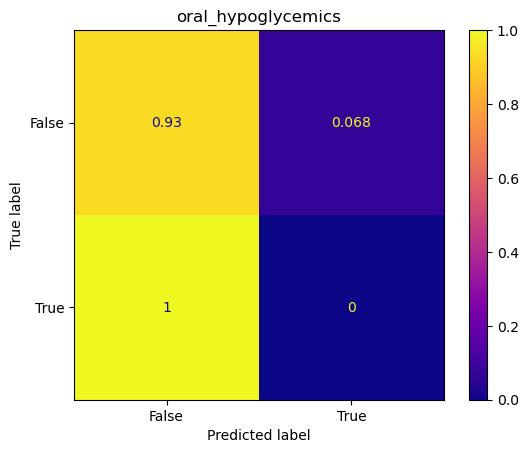

              precision    recall  f1-score   support

       False       0.71      0.93      0.81       147
        True       0.00      0.00      0.00        55

    accuracy                           0.68       202
   macro avg       0.36      0.47      0.40       202
weighted avg       0.52      0.68      0.59       202

Accuracy: 0.68
F1-score: 0.0
F2-score: 0.0
Specificity / Work Saved Over Sampling: 0.93
ROC AUC: 0.47

Class distribution:

shape: (2, 2)
┌─────────┬────────────┐
│ include ┆ proportion │
│ ---     ┆ ---        │
│ bool    ┆ f64        │
╞═════════╪════════════╡
│ true    ┆ 0.270378   │
│ false   ┆ 0.729622   │
└─────────┴────────────┘


In [ ]:
from sklearn.metrics import classification_report, fbeta_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt



matrix = confusion_matrix(y_test, y_pred, labels=[False, True])
matrix_norm = confusion_matrix(y_test, y_pred, labels=[False, True], normalize='true')
tn, fp, fn, tp = matrix.ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=matrix_norm, display_labels=[False, True])
disp.plot(cmap='plasma')
plt.title(f'{subject}')
plt.show()

report = classification_report(y_test, y_pred)
print(report)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', round(accuracy, 2))

f1 = fbeta_score(y_test, y_pred, beta=1)
print(f'F1-score: {round(f1, 2)}')

f2 = fbeta_score(y_test, y_pred, beta=2)
print(f'F2-score: {round(f2, 2)}')

specificity = tn / (tn + fp)
print(f'Specificity / Work Saved Over Sampling: {round(specificity, 2)}')

roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC AUC: {round(roc_auc, 2)}')

print('\nClass distribution:\n')
print(df['include'].value_counts(normalize=True))